# Обучение моделей бинарной классификации для предсказания токсичных комментариев

## Подгрузка необходимых библиотек, функций и данных

### Библиотеки

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import gc
import warnings
import time
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format
random.seed(42)
np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from thundersvm import SVC as TSVC

import optuna
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

from functools import partial

### Функции

In [4]:
from train_functions import train_and_predict_toxicity, show_metrics, get_hyperparams, get_threshold

### Данные

In [ ]:
!wget -O bow_data.zip "$(curl -G "https://cloud-api.yandex.net/v1/disk/public/resources/download" --data-urlencode "public_key=https://disk.yandex.ru/d/NCKPGAdHiBkBcQ" | jq -r '.href')"

In [ ]:
!wget -O tfidf_data.zip "$(curl -G "https://cloud-api.yandex.net/v1/disk/public/resources/download" --data-urlencode "public_key=https://disk.yandex.ru/d/NSOFpY0bpjqXKA" | jq -r '.href')"

In [ ]:
!unzip bow_data.zip

In [ ]:
!unzip tfidf_data.zip

In [7]:
X_train_bow = scipy.sparse.load_npz("bow_data/X_train_bow.npz")
X_val_bow = scipy.sparse.load_npz("bow_data/X_val_bow.npz")
X_test_bow = scipy.sparse.load_npz("bow_data/X_test_bow.npz")

X_train_tfidf = scipy.sparse.load_npz("tfidf_data/X_train_tfidf.npz")
X_val_tfidf = scipy.sparse.load_npz("tfidf_data/X_val_tfidf.npz")
X_test_tfidf = scipy.sparse.load_npz("tfidf_data/X_test_tfidf.npz")

y_train = pd.read_csv("bow_data/y_train.csv", index_col= 0)['toxicity_b']
y_val = pd.read_csv("bow_data/y_val.csv", index_col=0)['toxicity_b']
y_test = pd.read_csv("bow_data/y_test.csv", index_col=0)['toxicity_b']

## Обучение линейных моделей

### Logistic Regression

#### Base BoW

In [11]:
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_val,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(n_jobs=-1),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [12]:
t = get_threshold(y_val, y_log_reg_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.19


LogisticRegression BoW

Precision		Recall			F1

Train: 0.64		Train: 0.72		Train: 0.68
Val: 0.61		Val: 0.68		Val: 0.64
Test: 0.62		Test: 0.68		Test: 0.65


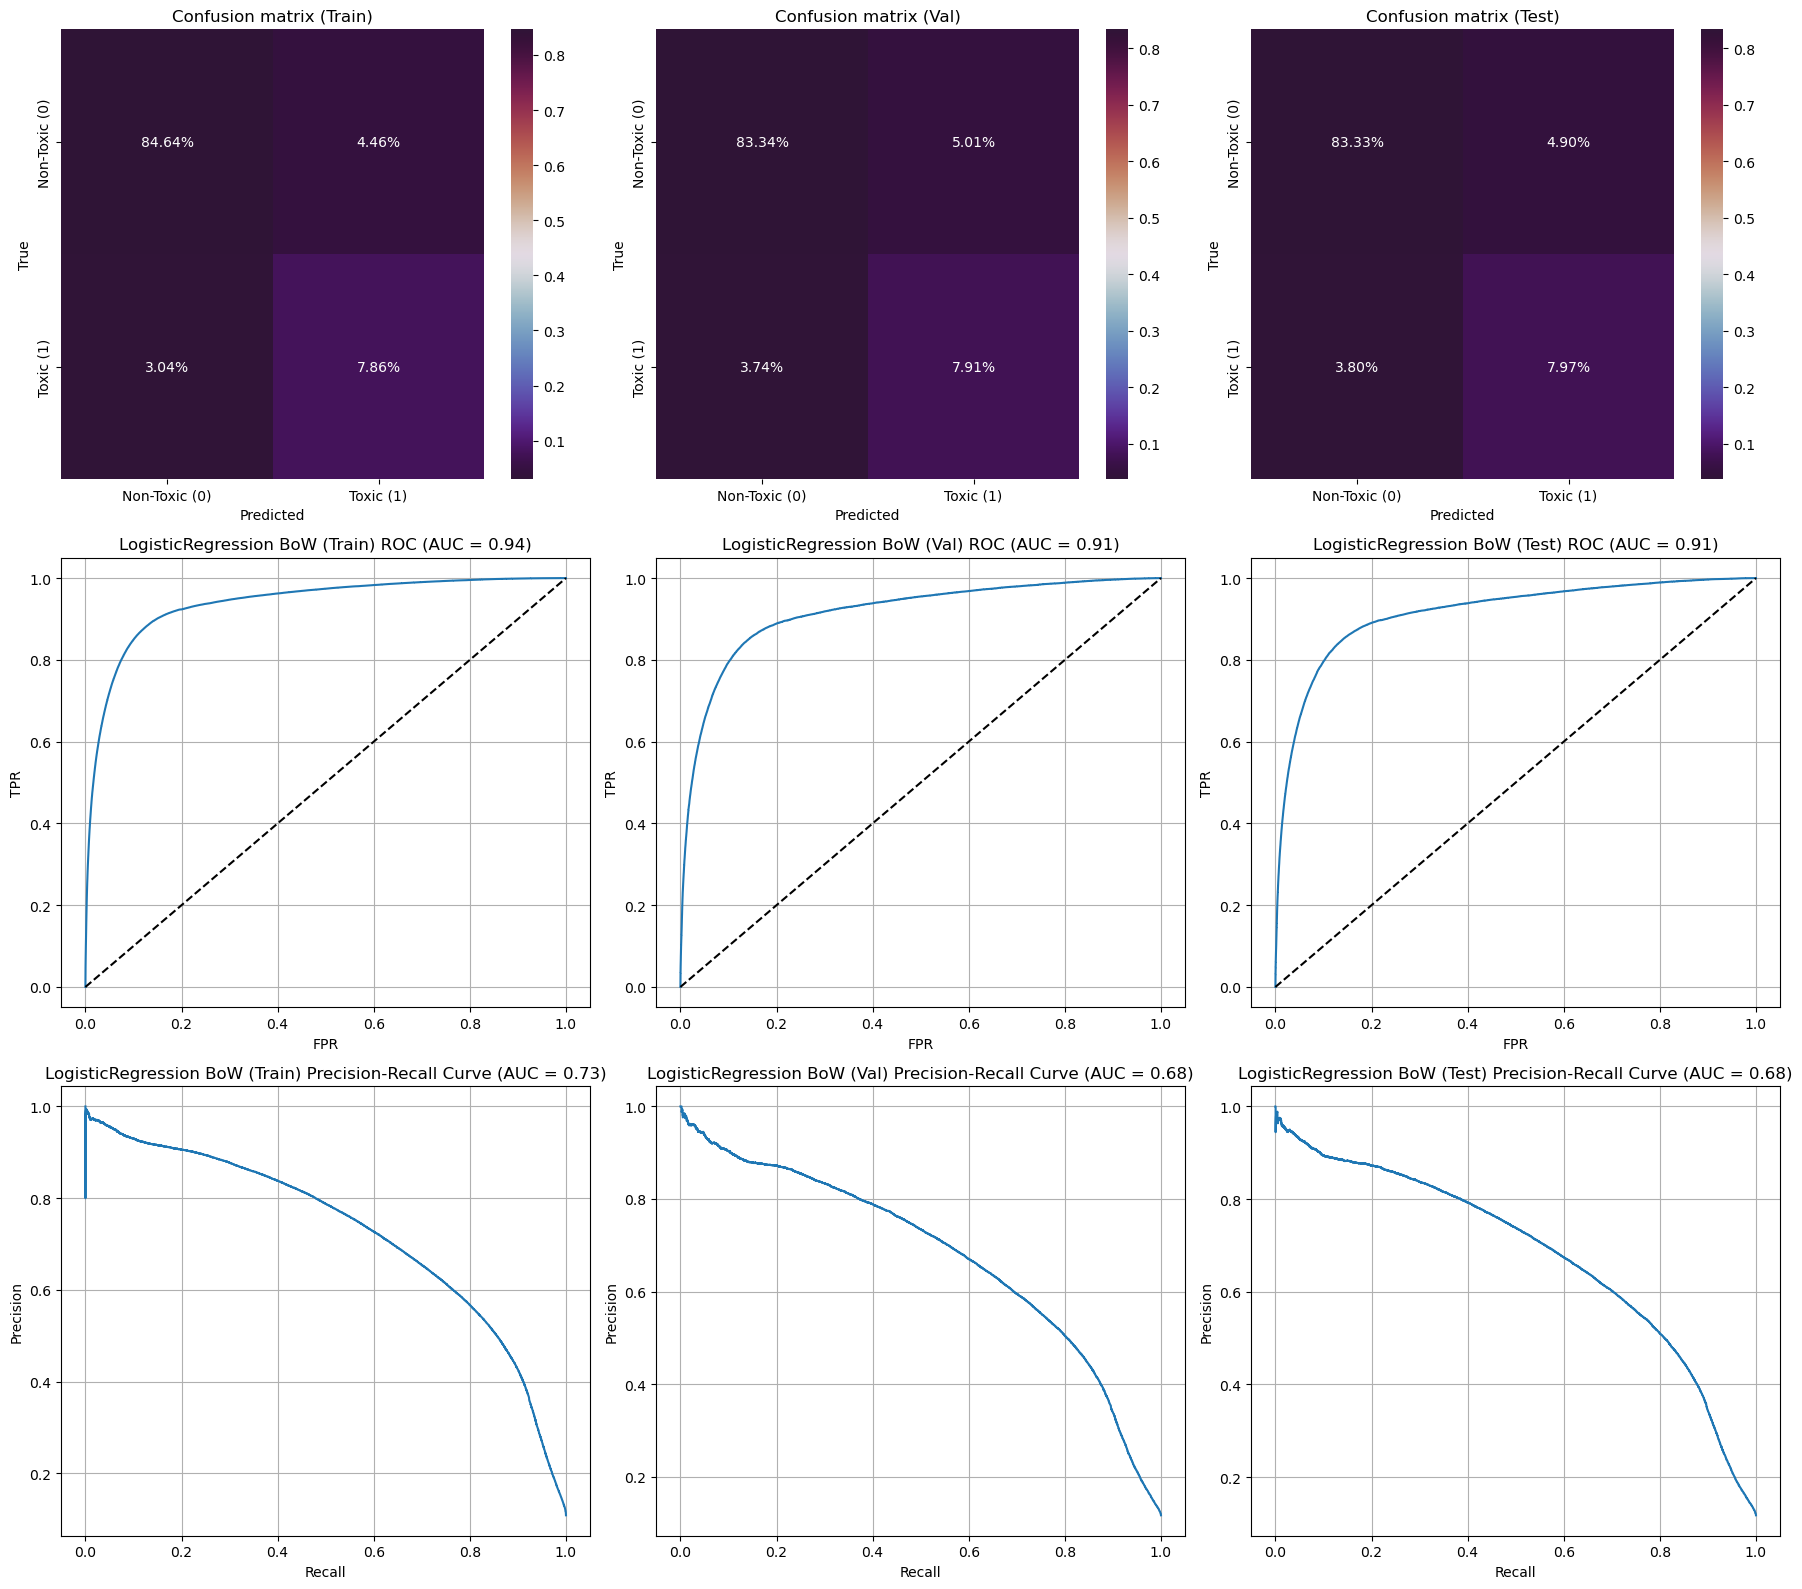

In [13]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_log_reg_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_log_reg_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_log_reg_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

#### Optuna Bow

In [15]:
def logreg_objective(trial, X_train, X_val, y_train, y_val):

    # Оптимизируем гиперпараметры логистической регрессии
    params = {'C': trial.suggest_float("C", 0.1, 10.0, log=True),
             'max_iter': trial.suggest_int('max_iter', 500, 10000),
             'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
             'n_jobs': -1}

    lr = LogisticRegression(**params)
    lr.fit(X_train, y_train)
    y_pred_proba = lr.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [16]:
lr_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, logreg_objective, n_trials=20)

(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_val,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**lr_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-03-06 20:16:13,696] A new study created in memory with name: no-name-40e12d0e-5e34-47d8-889e-419224a6c6b1
[I 2025-03-06 20:16:18,173] Trial 0 finished with value: 0.6701422431965727 and parameters: {'C': 0.9931430543565385, 'max_iter': 9752, 'class_weight': None}. Best is trial 0 with value: 0.6701422431965727.
[I 2025-03-06 20:16:28,535] Trial 1 finished with value: 0.6577690548279967 and parameters: {'C': 1.212203372013619, 'max_iter': 6520, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6701422431965727.
[I 2025-03-06 20:16:35,273] Trial 2 finished with value: 0.6621586266654841 and parameters: {'C': 3.0795874261509537, 'max_iter': 8375, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6701422431965727.
[I 2025-03-06 20:16:42,796] Trial 3 finished with value: 0.6501055229358836 and parameters: {'C': 0.13293513092520562, 'max_iter': 4512, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6701422431965727.
[I 2025-03-06 20:16:46,779] Trial 4 fini

In [18]:
t = get_threshold(y_val, y_log_reg_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.21


LogisticRegression BoW

Precision		Recall			F1

Train: 0.65		Train: 0.71		Train: 0.68
Val: 0.63		Val: 0.66		Val: 0.64
Test: 0.63		Test: 0.66		Test: 0.65


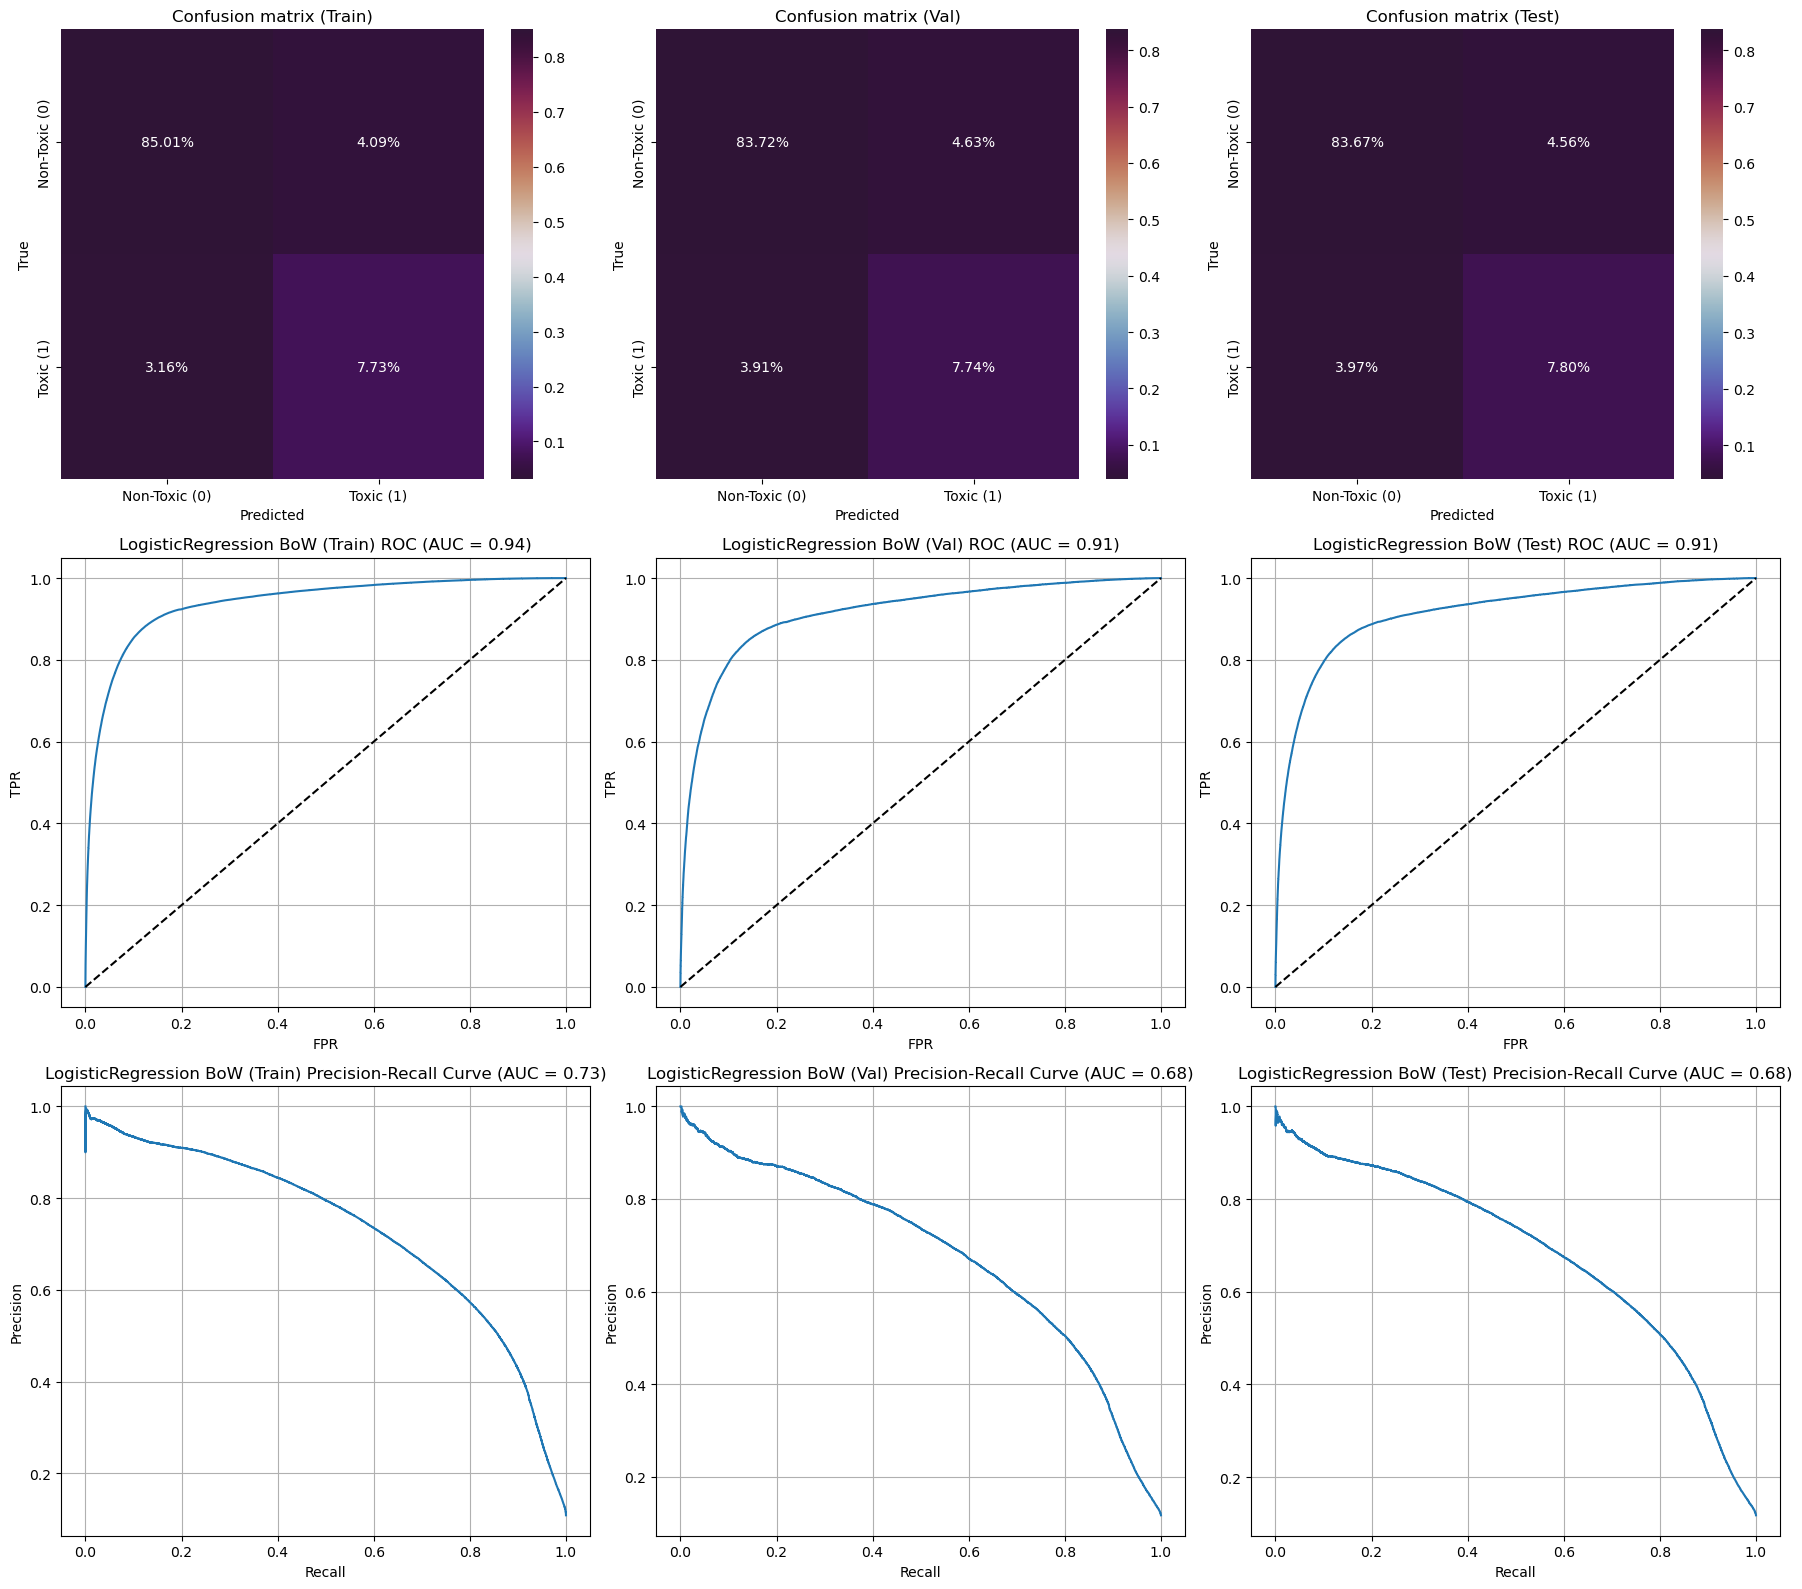

In [19]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_log_reg_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_log_reg_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_log_reg_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

#### Base TF-IDF

In [21]:
(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(n_jobs=-1),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [22]:
t = get_threshold(y_val, y_log_reg_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.24


LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.64		Train: 0.68		Train: 0.66
Val: 0.62		Val: 0.67		Val: 0.65
Test: 0.63		Test: 0.67		Test: 0.65


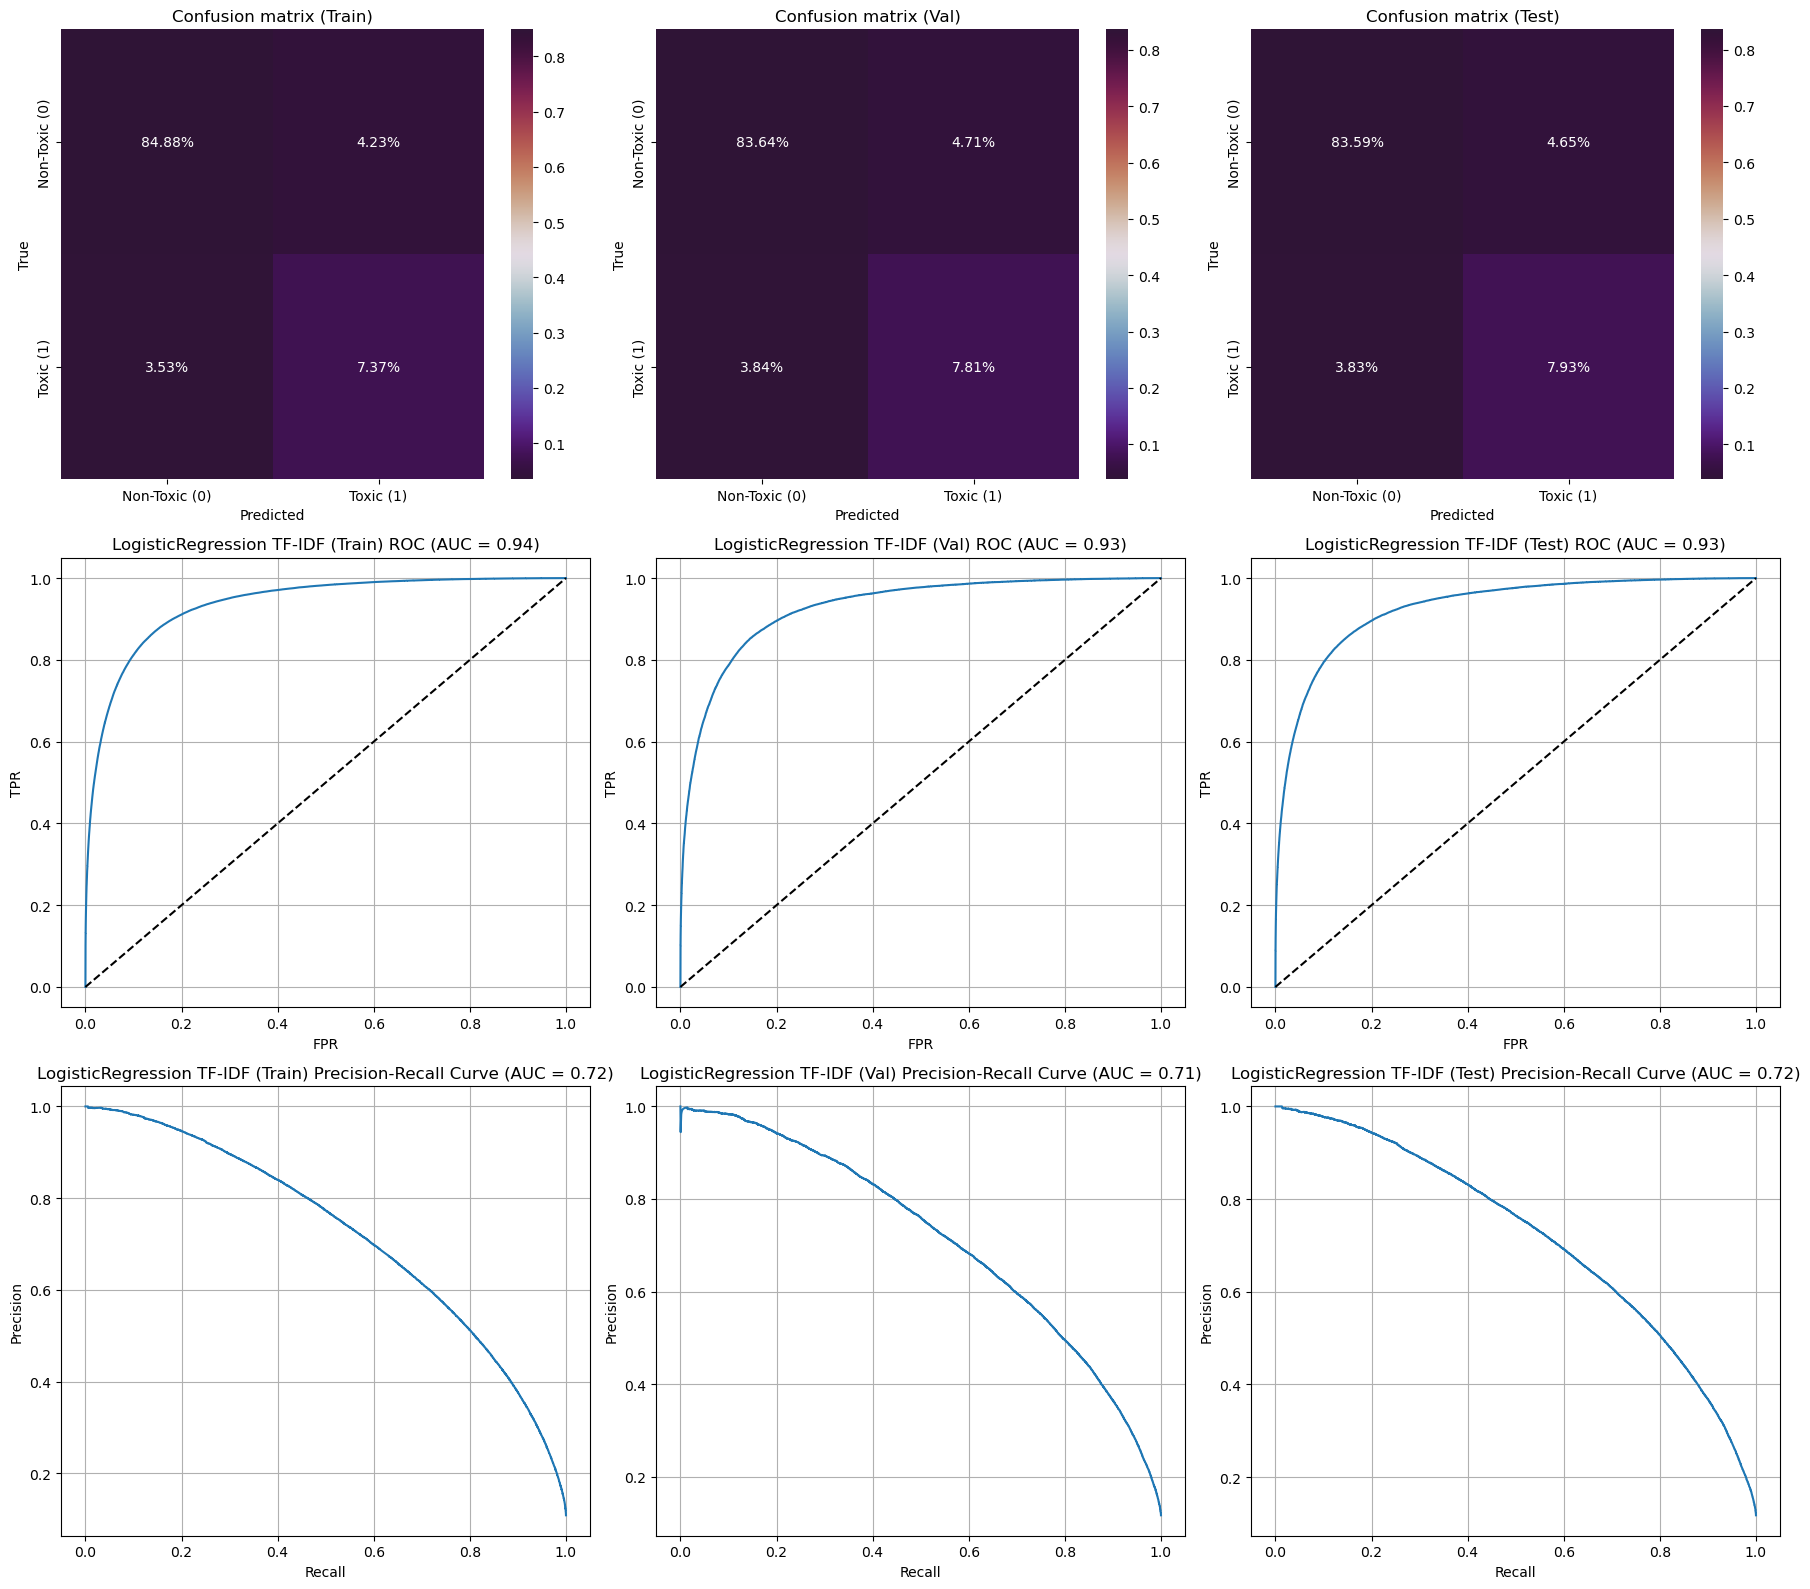

In [23]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_log_reg_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_log_reg_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_log_reg_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

### Optuna TF-IDF

In [25]:
lr_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, logreg_objective, n_trials=20)

(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**lr_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-03-06 20:19:13,459] A new study created in memory with name: no-name-a0483bed-a018-47f7-a4c9-2798b9779113
[I 2025-03-06 20:19:17,047] Trial 0 finished with value: 0.7059267380076236 and parameters: {'C': 0.1735289270015811, 'max_iter': 9819, 'class_weight': None}. Best is trial 0 with value: 0.7059267380076236.
[I 2025-03-06 20:19:20,866] Trial 1 finished with value: 0.7107612491523683 and parameters: {'C': 0.388256307578012, 'max_iter': 3939, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7107612491523683.
[I 2025-03-06 20:19:24,454] Trial 2 finished with value: 0.7175433213527624 and parameters: {'C': 4.4002873457476515, 'max_iter': 5573, 'class_weight': None}. Best is trial 2 with value: 0.7175433213527624.
[I 2025-03-06 20:19:28,407] Trial 3 finished with value: 0.7160894594710773 and parameters: {'C': 1.6486577506928075, 'max_iter': 8293, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7175433213527624.
[I 2025-03-06 20:19:31,883] Trial 4 finished wi

In [26]:
t = get_threshold(y_val, y_log_reg_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.24


LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.63		Train: 0.70		Train: 0.66
Val: 0.62		Val: 0.68		Val: 0.65
Test: 0.63		Test: 0.68		Test: 0.65


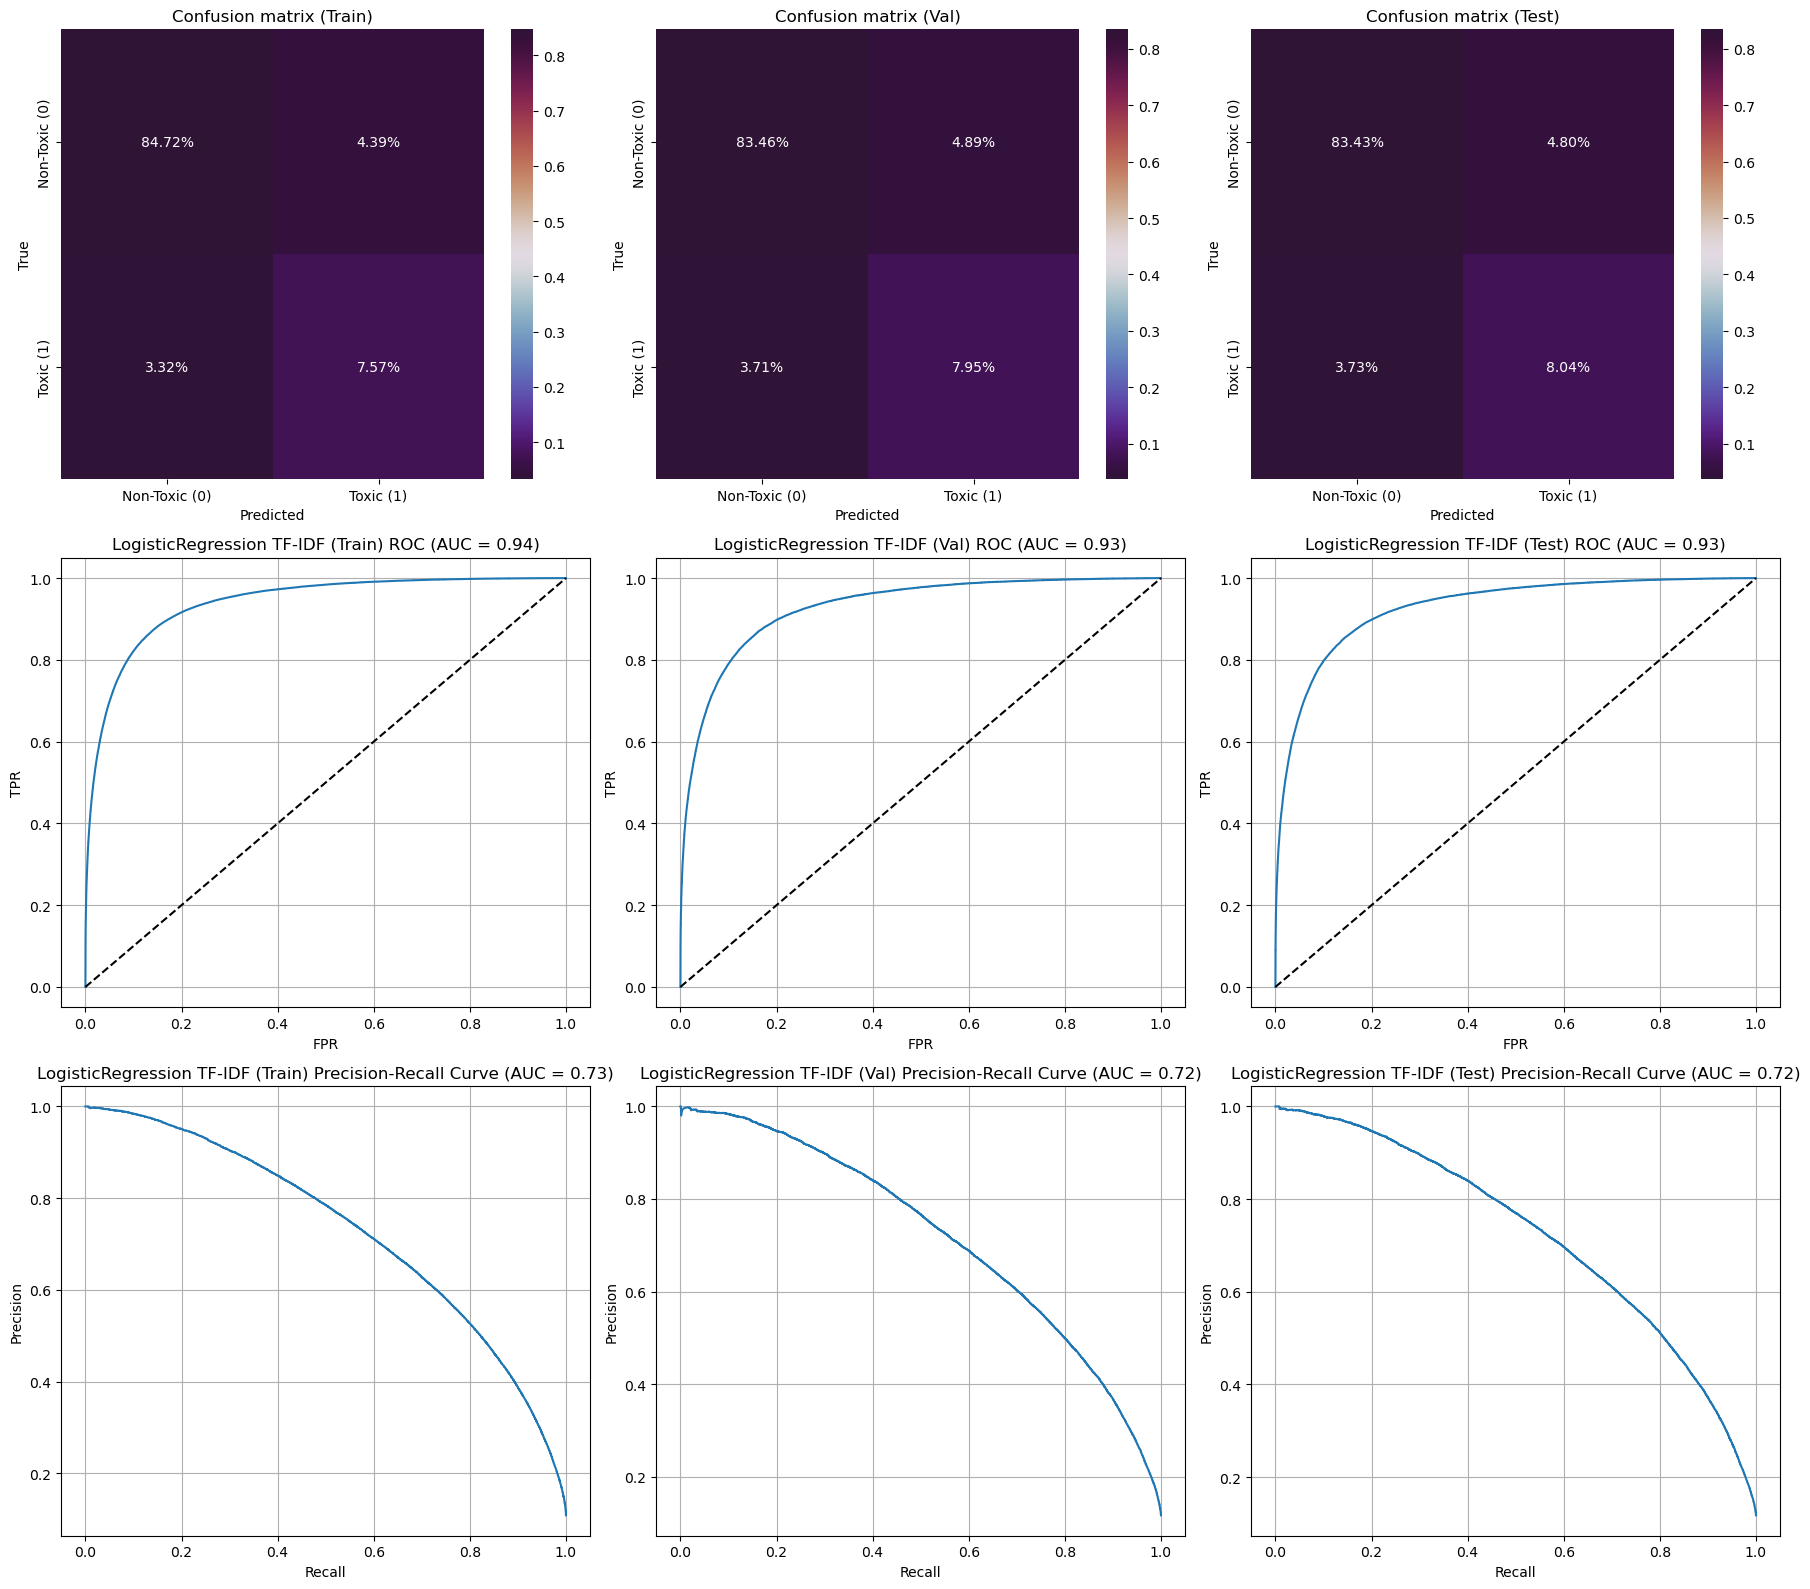

In [27]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_log_reg_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_log_reg_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_log_reg_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

### Linear SVC

#### Base BoW

In [31]:
(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(dual=False), n_jobs = -1),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [32]:
t = get_threshold(y_val, y_linear_svc_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.19


LinearSVC BoW

Precision		Recall			F1

Train: 0.70		Train: 0.77		Train: 0.73
Val: 0.59		Val: 0.67		Val: 0.63
Test: 0.60		Test: 0.67		Test: 0.63


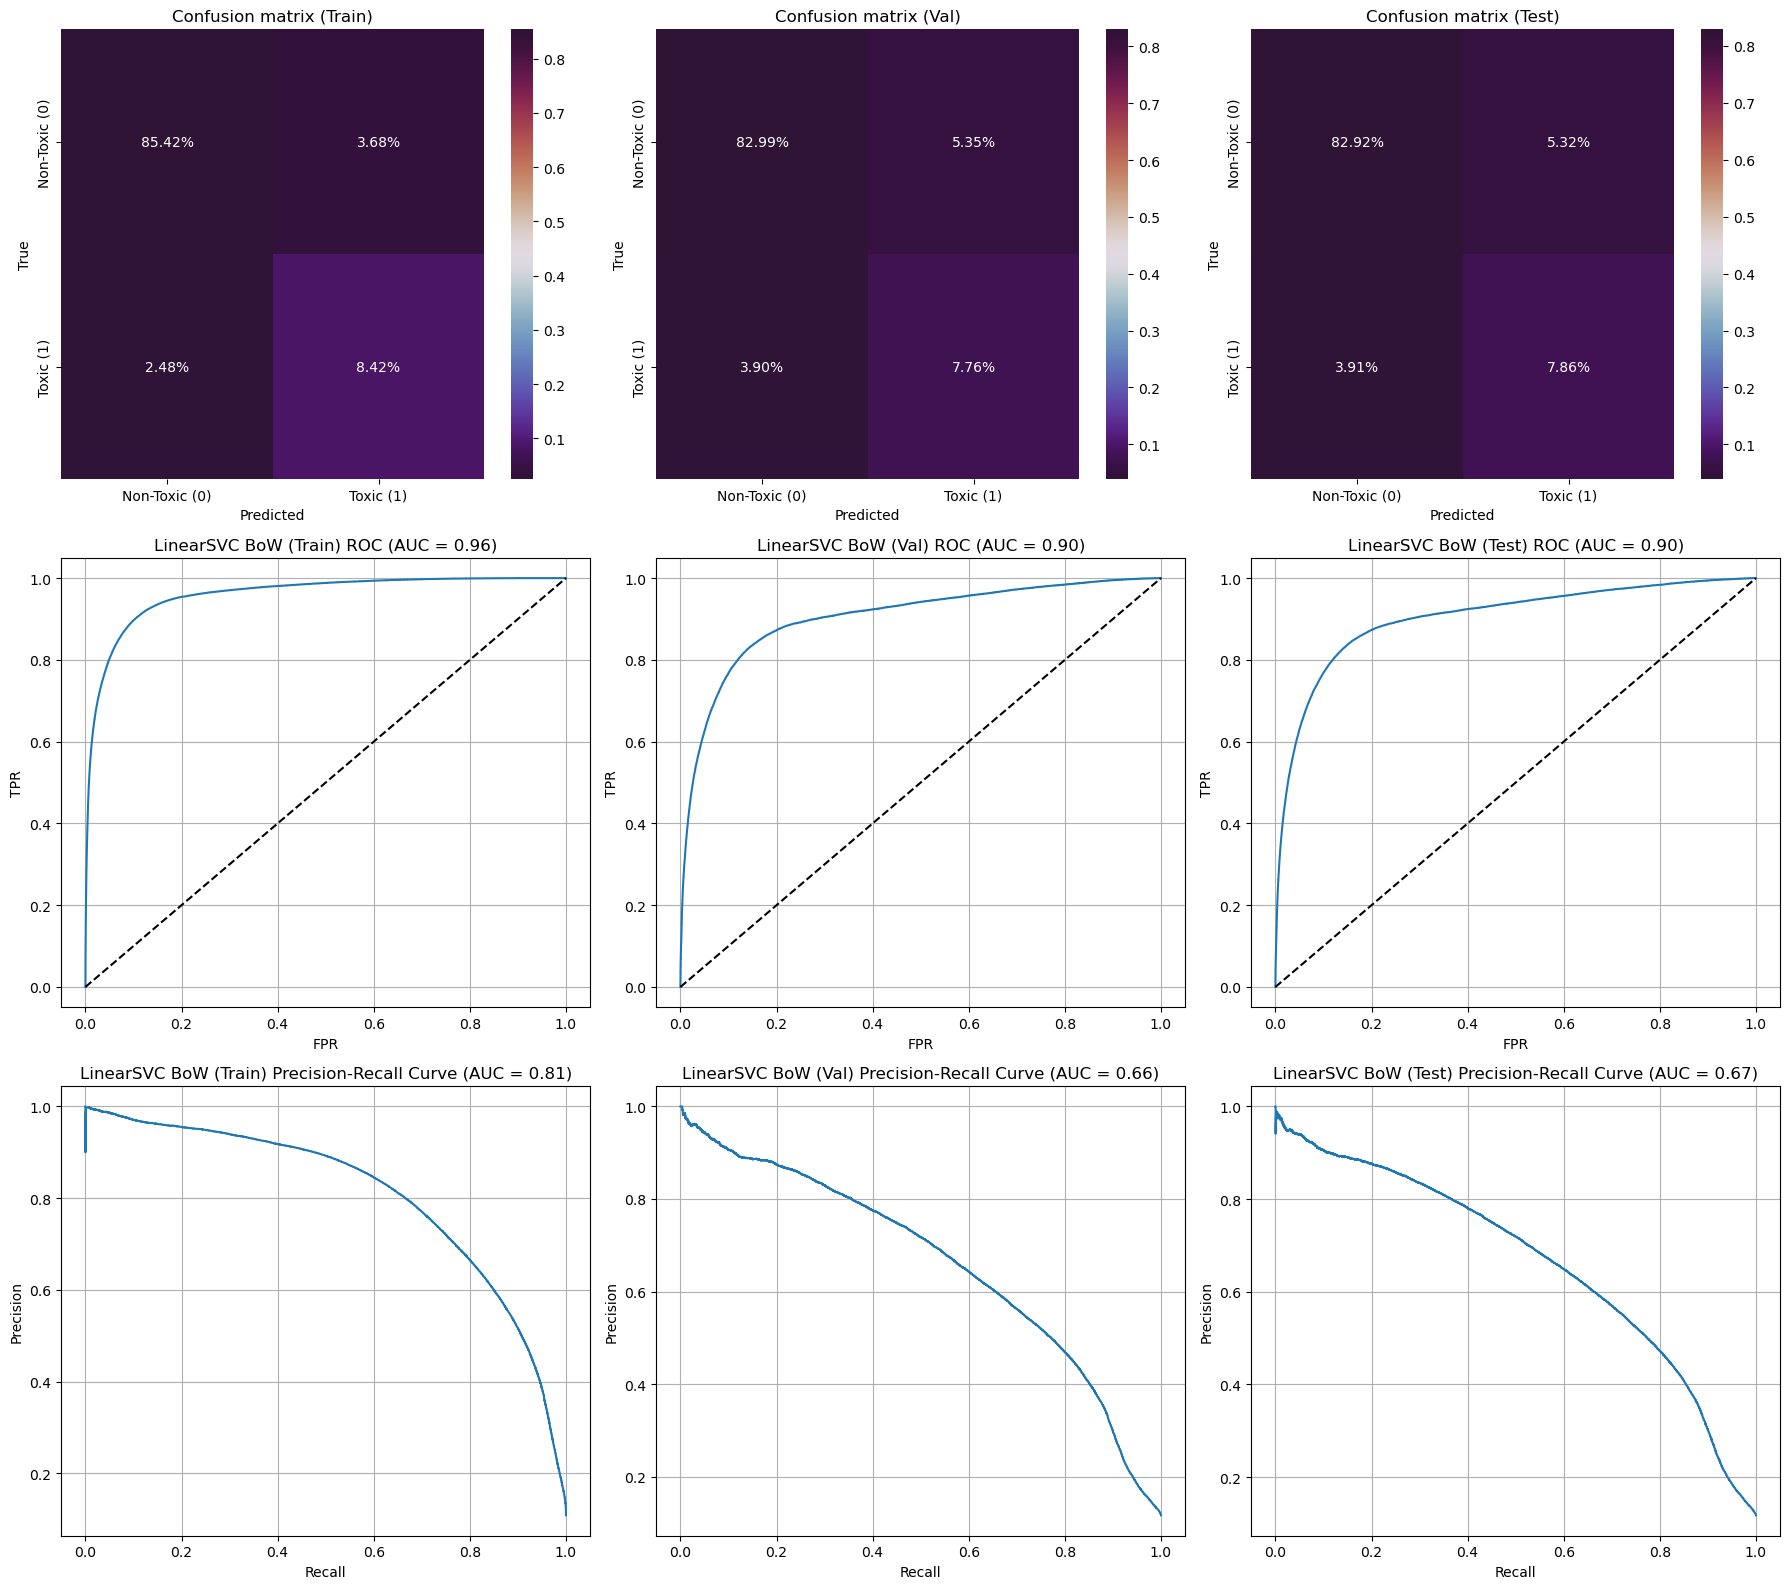

In [35]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_linear_svc_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_linear_svc_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_linear_svc_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='LinearSVC BoW'
)

#### Optuna BoW

In [37]:
def svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-3, 1, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    svc = CalibratedClassifierCV(LinearSVC(C=C, dual=False, penalty = penalty, class_weight=class_weight), n_jobs=-1)
    svc.fit(X_train, y_train)
    
    y_pred_proba = svc.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [38]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, svc_objective, n_trials=20)

(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False)),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-03-06 20:21:46,129] A new study created in memory with name: no-name-f9c155e9-54b7-4f80-9b6a-cca3fcb954f7
[I 2025-03-06 20:21:58,712] Trial 0 finished with value: 0.6832969346671922 and parameters: {'C': 0.07320687411783608, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.6832969346671922.
[I 2025-03-06 20:22:14,758] Trial 1 finished with value: 0.6895499129680196 and parameters: {'C': 0.24586325528431788, 'penalty': 'l1', 'class_weight': None}. Best is trial 1 with value: 0.6895499129680196.
[I 2025-03-06 20:22:18,799] Trial 2 finished with value: 0.5852065237553229 and parameters: {'C': 0.0016016790455859495, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.6895499129680196.
[I 2025-03-06 20:22:25,513] Trial 3 finished with value: 0.6626755831019147 and parameters: {'C': 0.01384961322454483, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.6895499129680196.
[I 2025-03-06 20:22:37,633] Trial 4 finished with value:

In [39]:
t = get_threshold(y_val, y_linear_svc_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.18


LinearSVC BoW

Precision		Recall			F1

Train: 0.63		Train: 0.71		Train: 0.67
Val: 0.61		Val: 0.68		Val: 0.65
Test: 0.62		Test: 0.68		Test: 0.65


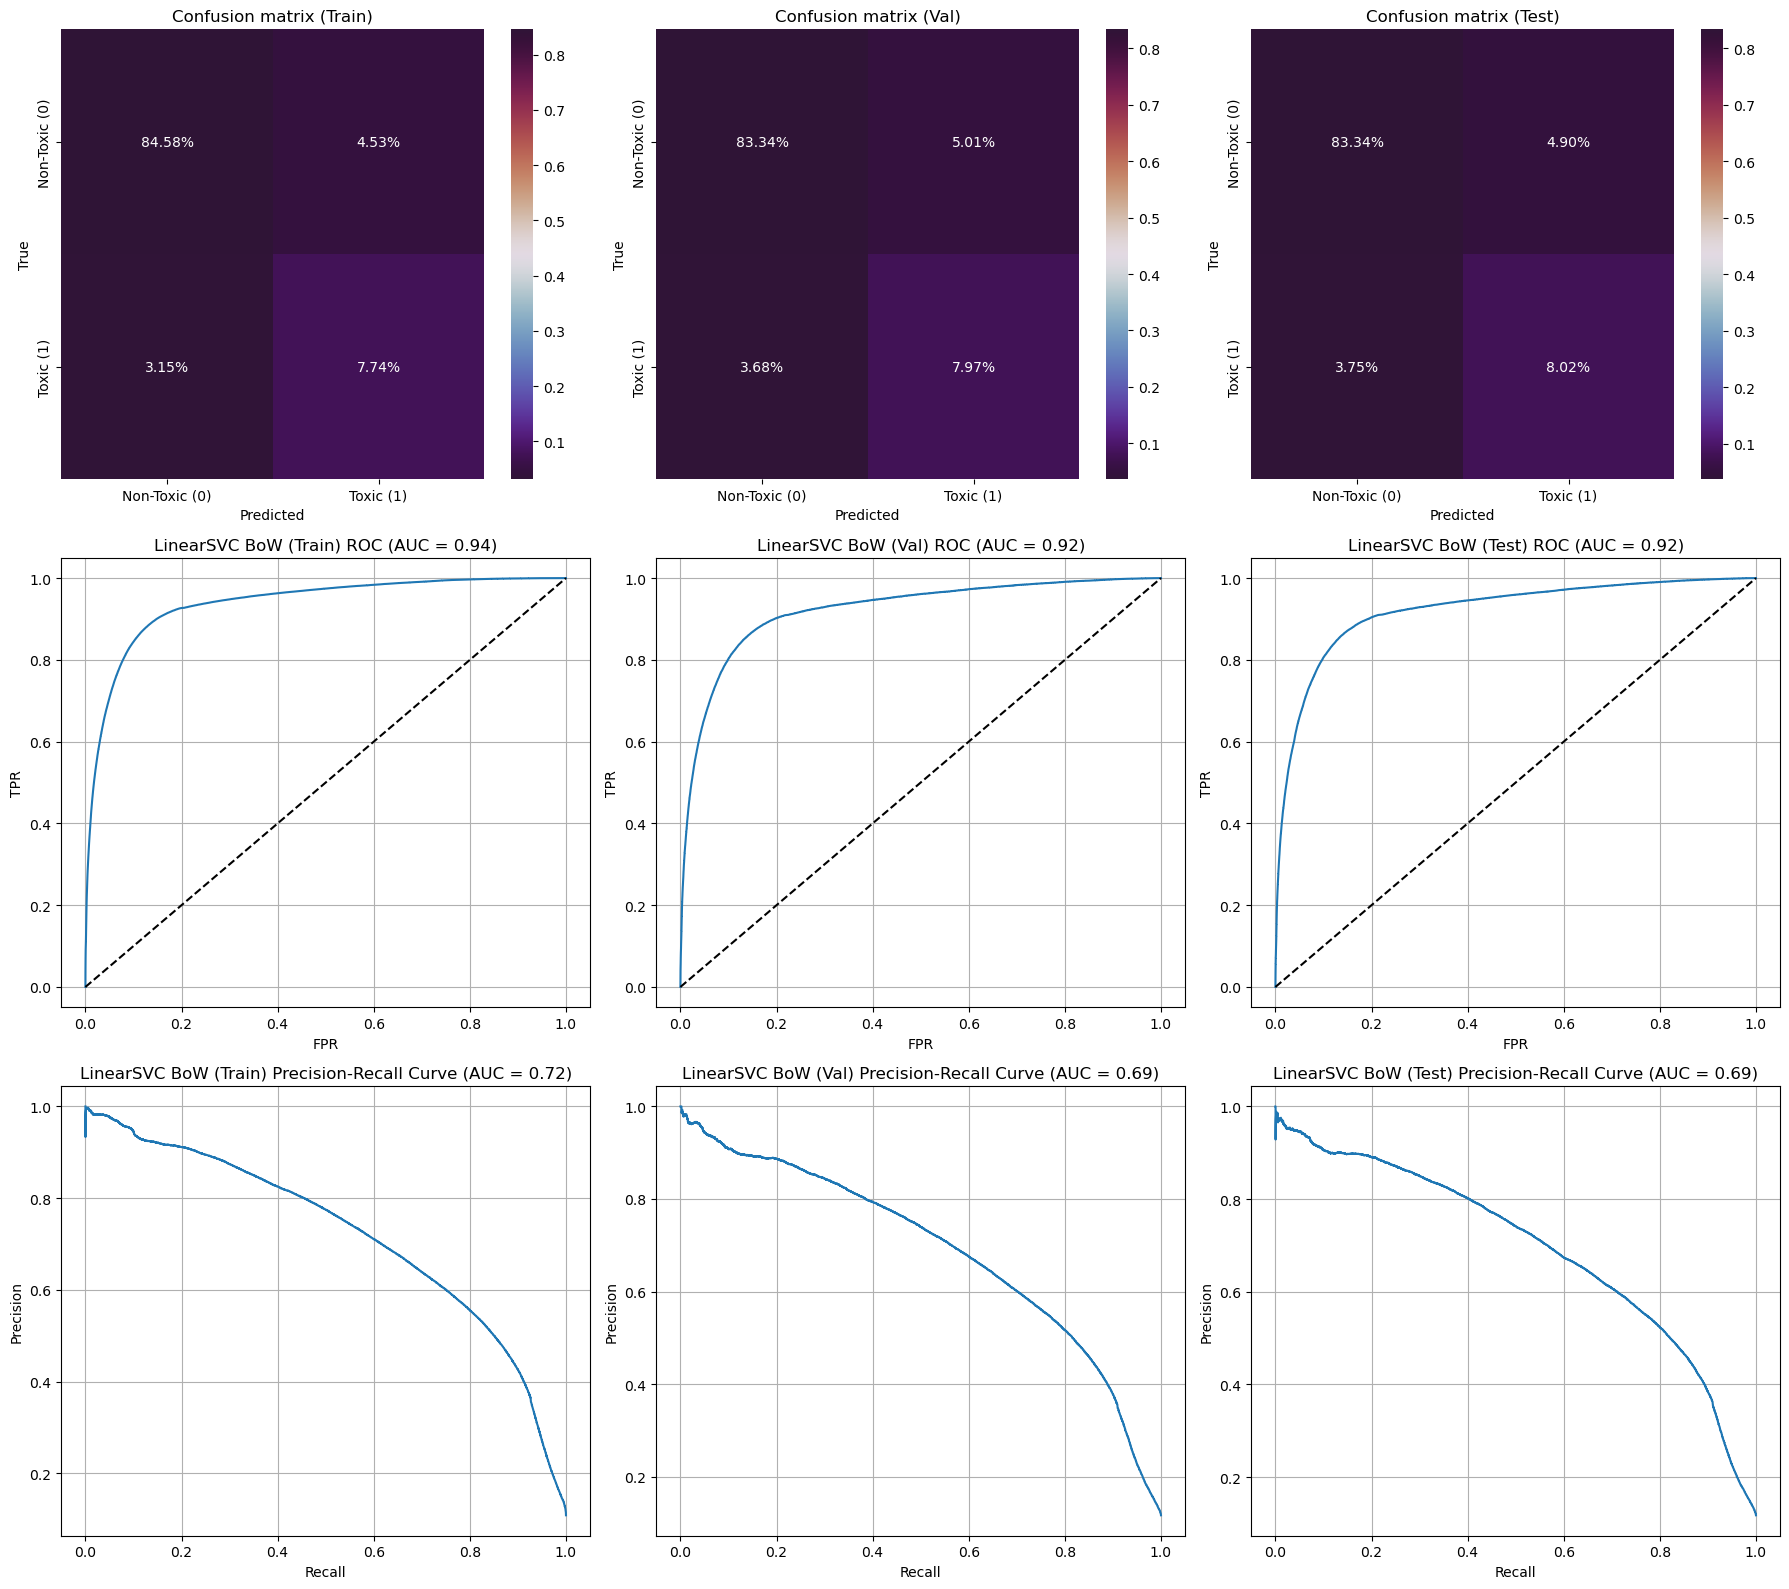

In [40]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_linear_svc_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_linear_svc_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_linear_svc_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='LinearSVC BoW'
)

#### Base TF-IDF

In [42]:
(y_linear_svc_tfidf_pred_train,
 y_linear_svc_tfidf_pred_val,
 y_linear_svc_tfidf_pred_test,
 y_linear_svc_tfidf_pred_proba_train,
 y_linear_svc_tfidf_pred_proba_val,
 y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(dual=False), n_jobs = -1),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [43]:
t = get_threshold(y_val, y_linear_svc_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.23


LinearSVC TF-IDF

Precision		Recall			F1

Train: 0.65		Train: 0.69		Train: 0.67
Val: 0.63		Val: 0.68		Val: 0.65
Test: 0.64		Test: 0.68		Test: 0.66


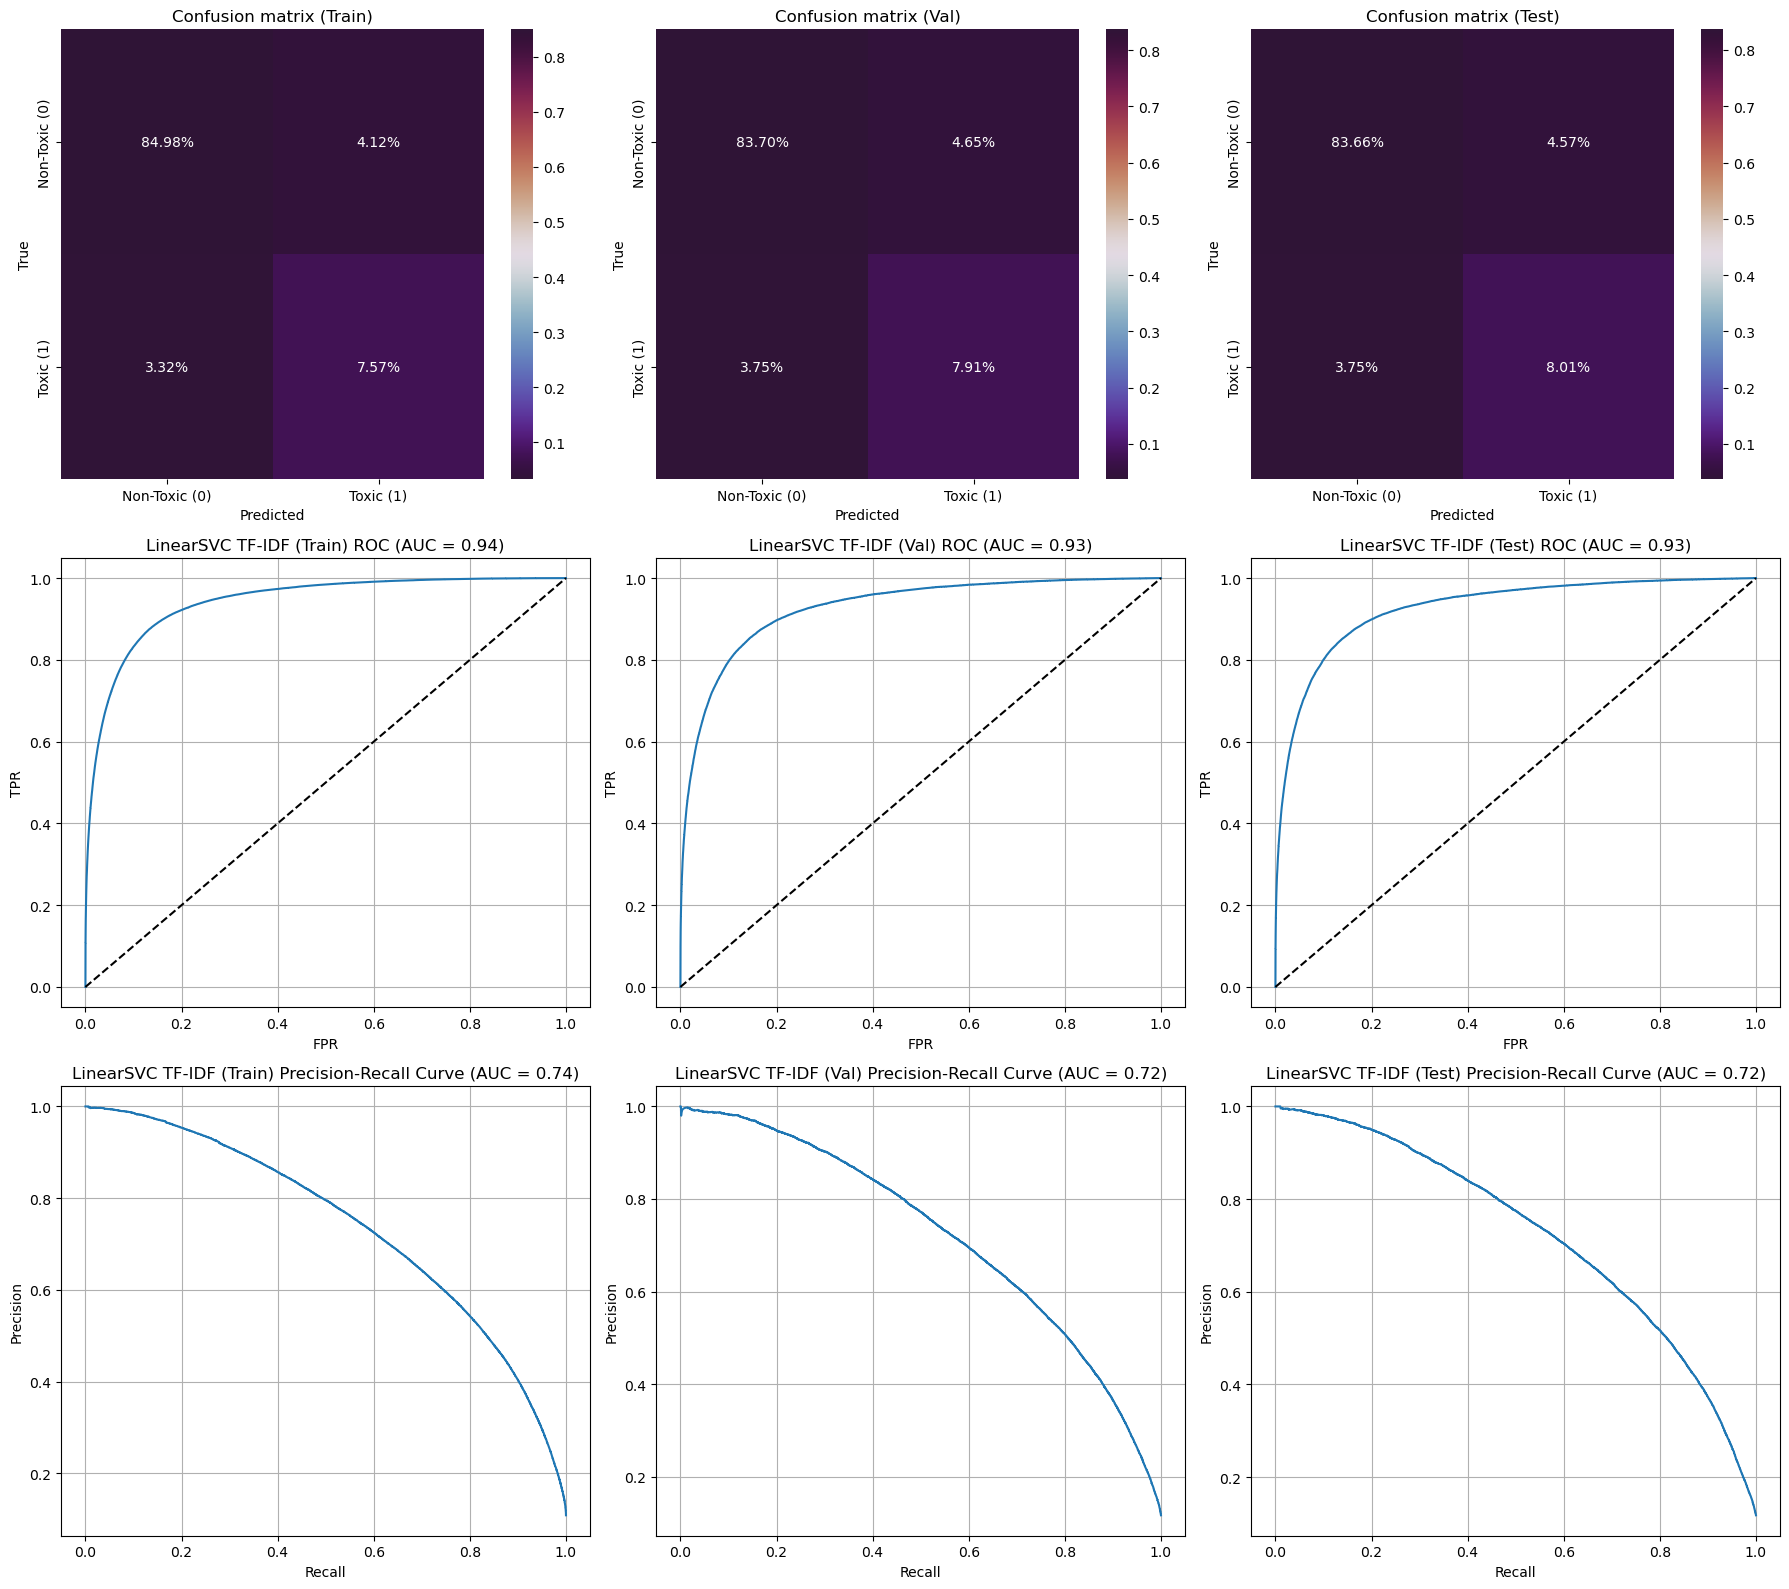

In [44]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_linear_svc_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_linear_svc_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_linear_svc_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='LinearSVC TF-IDF'
)

#### Optuna TF-IDF

In [46]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, svc_objective, n_trials=20)

(y_linear_svc_tfidf_pred_train,
 y_linear_svc_tfidf_pred_val,
 y_linear_svc_tfidf_pred_test,
 y_linear_svc_tfidf_pred_proba_train,
 y_linear_svc_tfidf_pred_proba_val,
 y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False), n_jobs = -1),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-03-06 20:30:06,792] A new study created in memory with name: no-name-7fff0ae9-b707-47c6-93aa-652de8fe5d0d
[I 2025-03-06 20:30:58,108] Trial 0 finished with value: 0.7150088863444934 and parameters: {'C': 0.46275040513138677, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7150088863444934.
[I 2025-03-06 20:31:03,782] Trial 1 finished with value: 0.5842646498456484 and parameters: {'C': 0.001784287814054402, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.7150088863444934.
[I 2025-03-06 20:31:09,614] Trial 2 finished with value: 0.6706347192036907 and parameters: {'C': 0.0034914520759177425, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7150088863444934.
[I 2025-03-06 20:31:14,941] Trial 3 finished with value: 0.6980515944208286 and parameters: {'C': 0.005908231439403471, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.7150088863444934.
[I 2025-03-06 20:31:23,698] Trial 4 finish

In [47]:
t = get_threshold(y_val, y_linear_svc_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.22


LinearSVC TF-IDF

Precision		Recall			F1

Train: 0.64		Train: 0.69		Train: 0.66
Val: 0.63		Val: 0.68		Val: 0.65
Test: 0.63		Test: 0.69		Test: 0.66


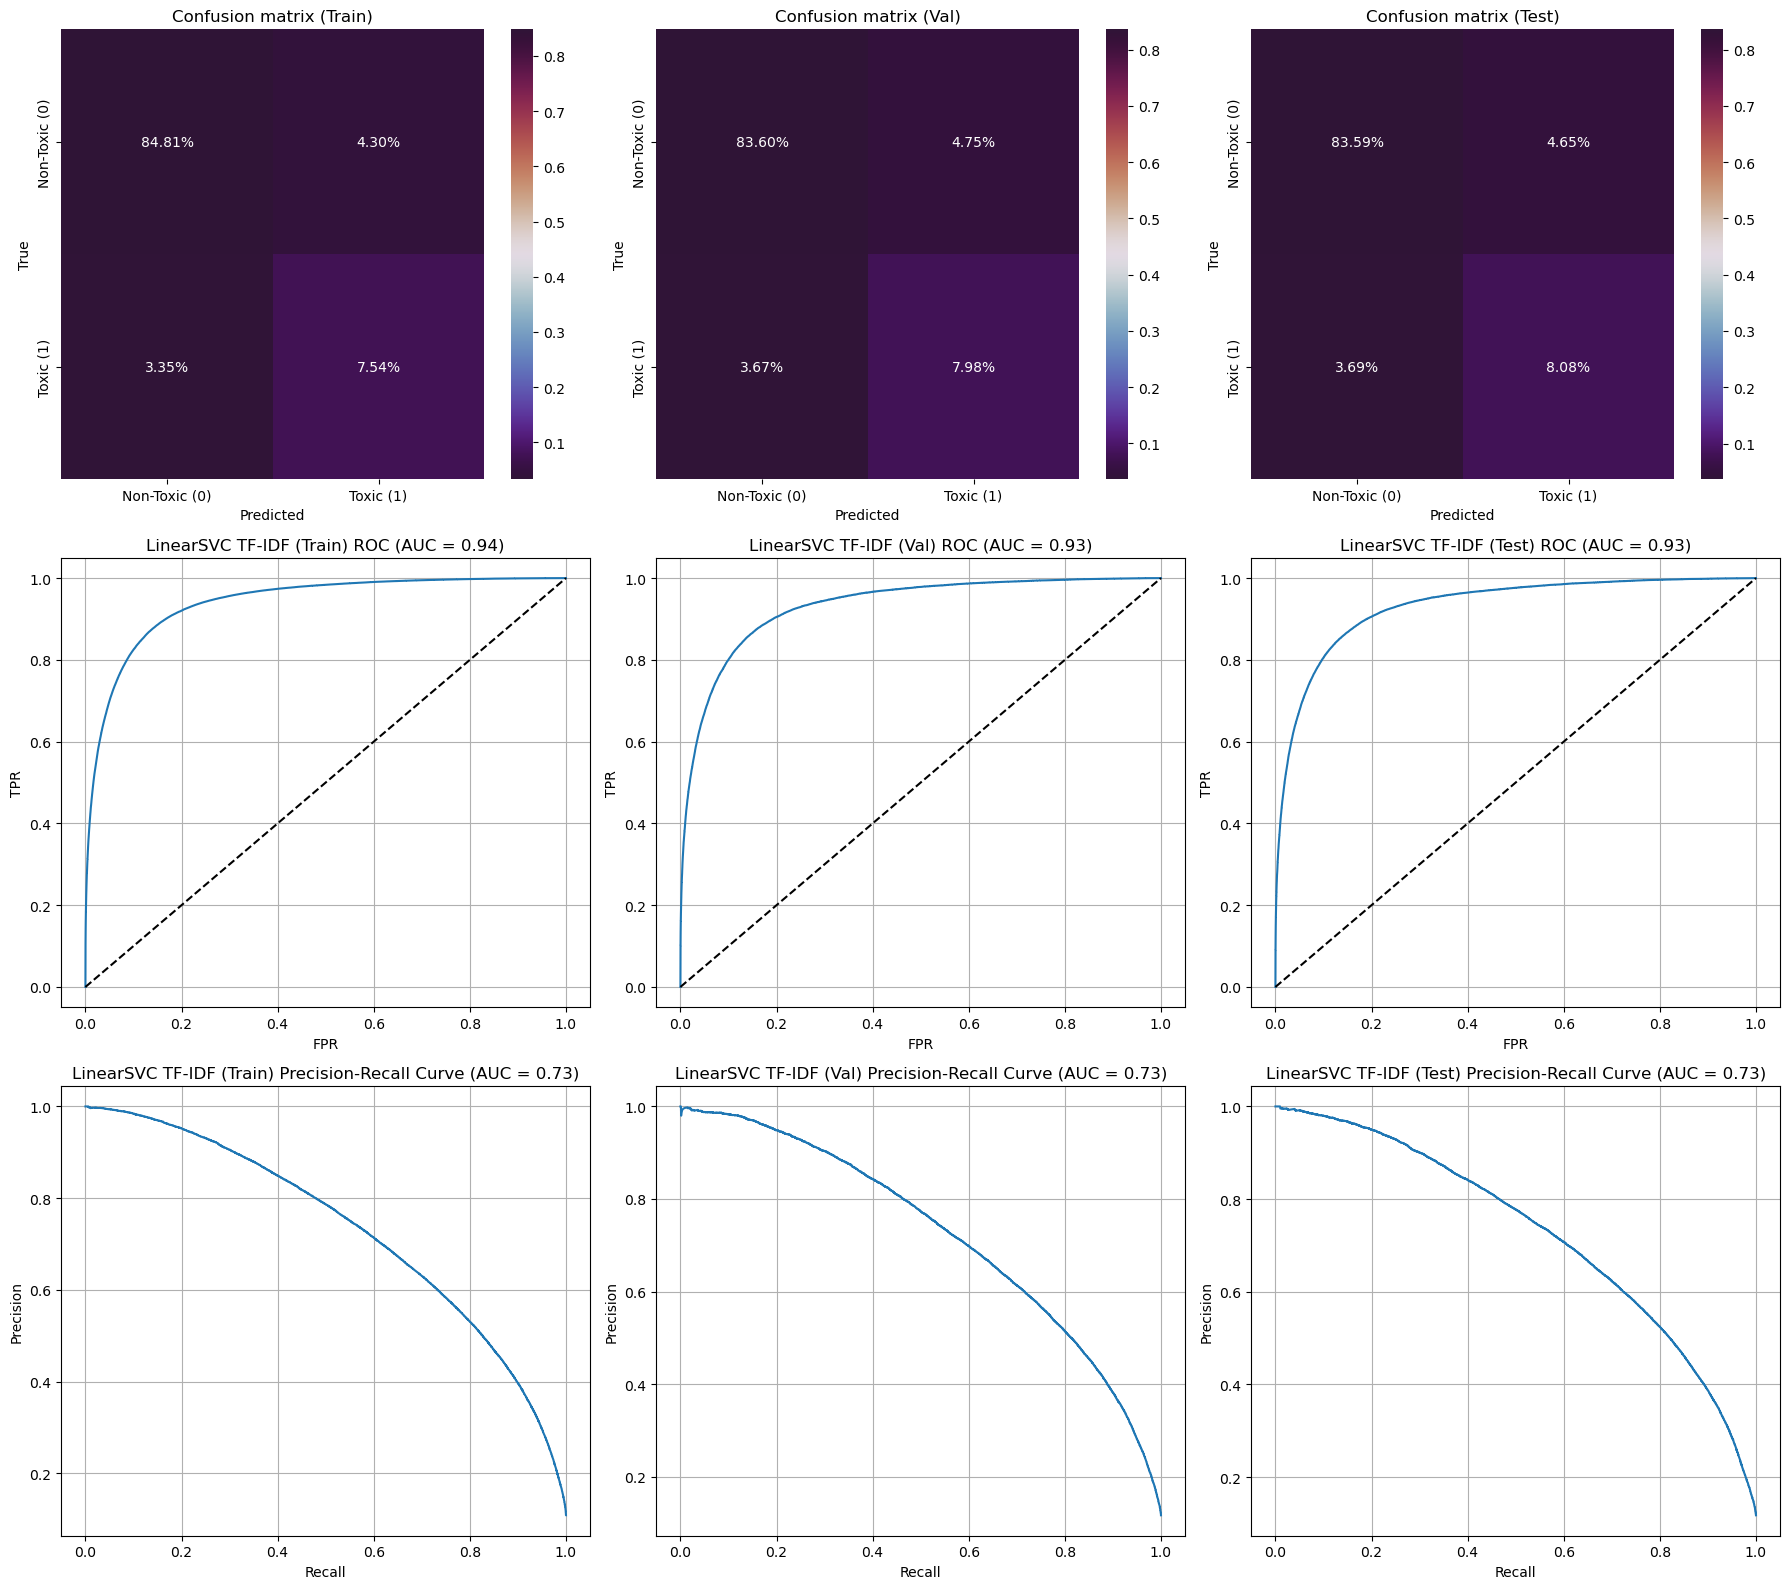

In [48]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_linear_svc_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_linear_svc_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_linear_svc_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='LinearSVC TF-IDF'
)

## Обучение нелиненых моделей

### Decision Tree

#### Base BoW

In [9]:
(
    y_tree_bow_pred_train,
    y_tree_bow_pred_val,
    y_tree_bow_pred_test,
    y_tree_bow_pred_proba_train,
    y_tree_bow_pred_proba_val,
    y_tree_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [10]:
t = get_threshold(y_val, y_tree_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.37


DecisionTree BoW

Precision		Recall			F1

Train: 0.99		Train: 1.00		Train: 1.00
Val: 0.51		Val: 0.51		Val: 0.51
Test: 0.52		Test: 0.51		Test: 0.51


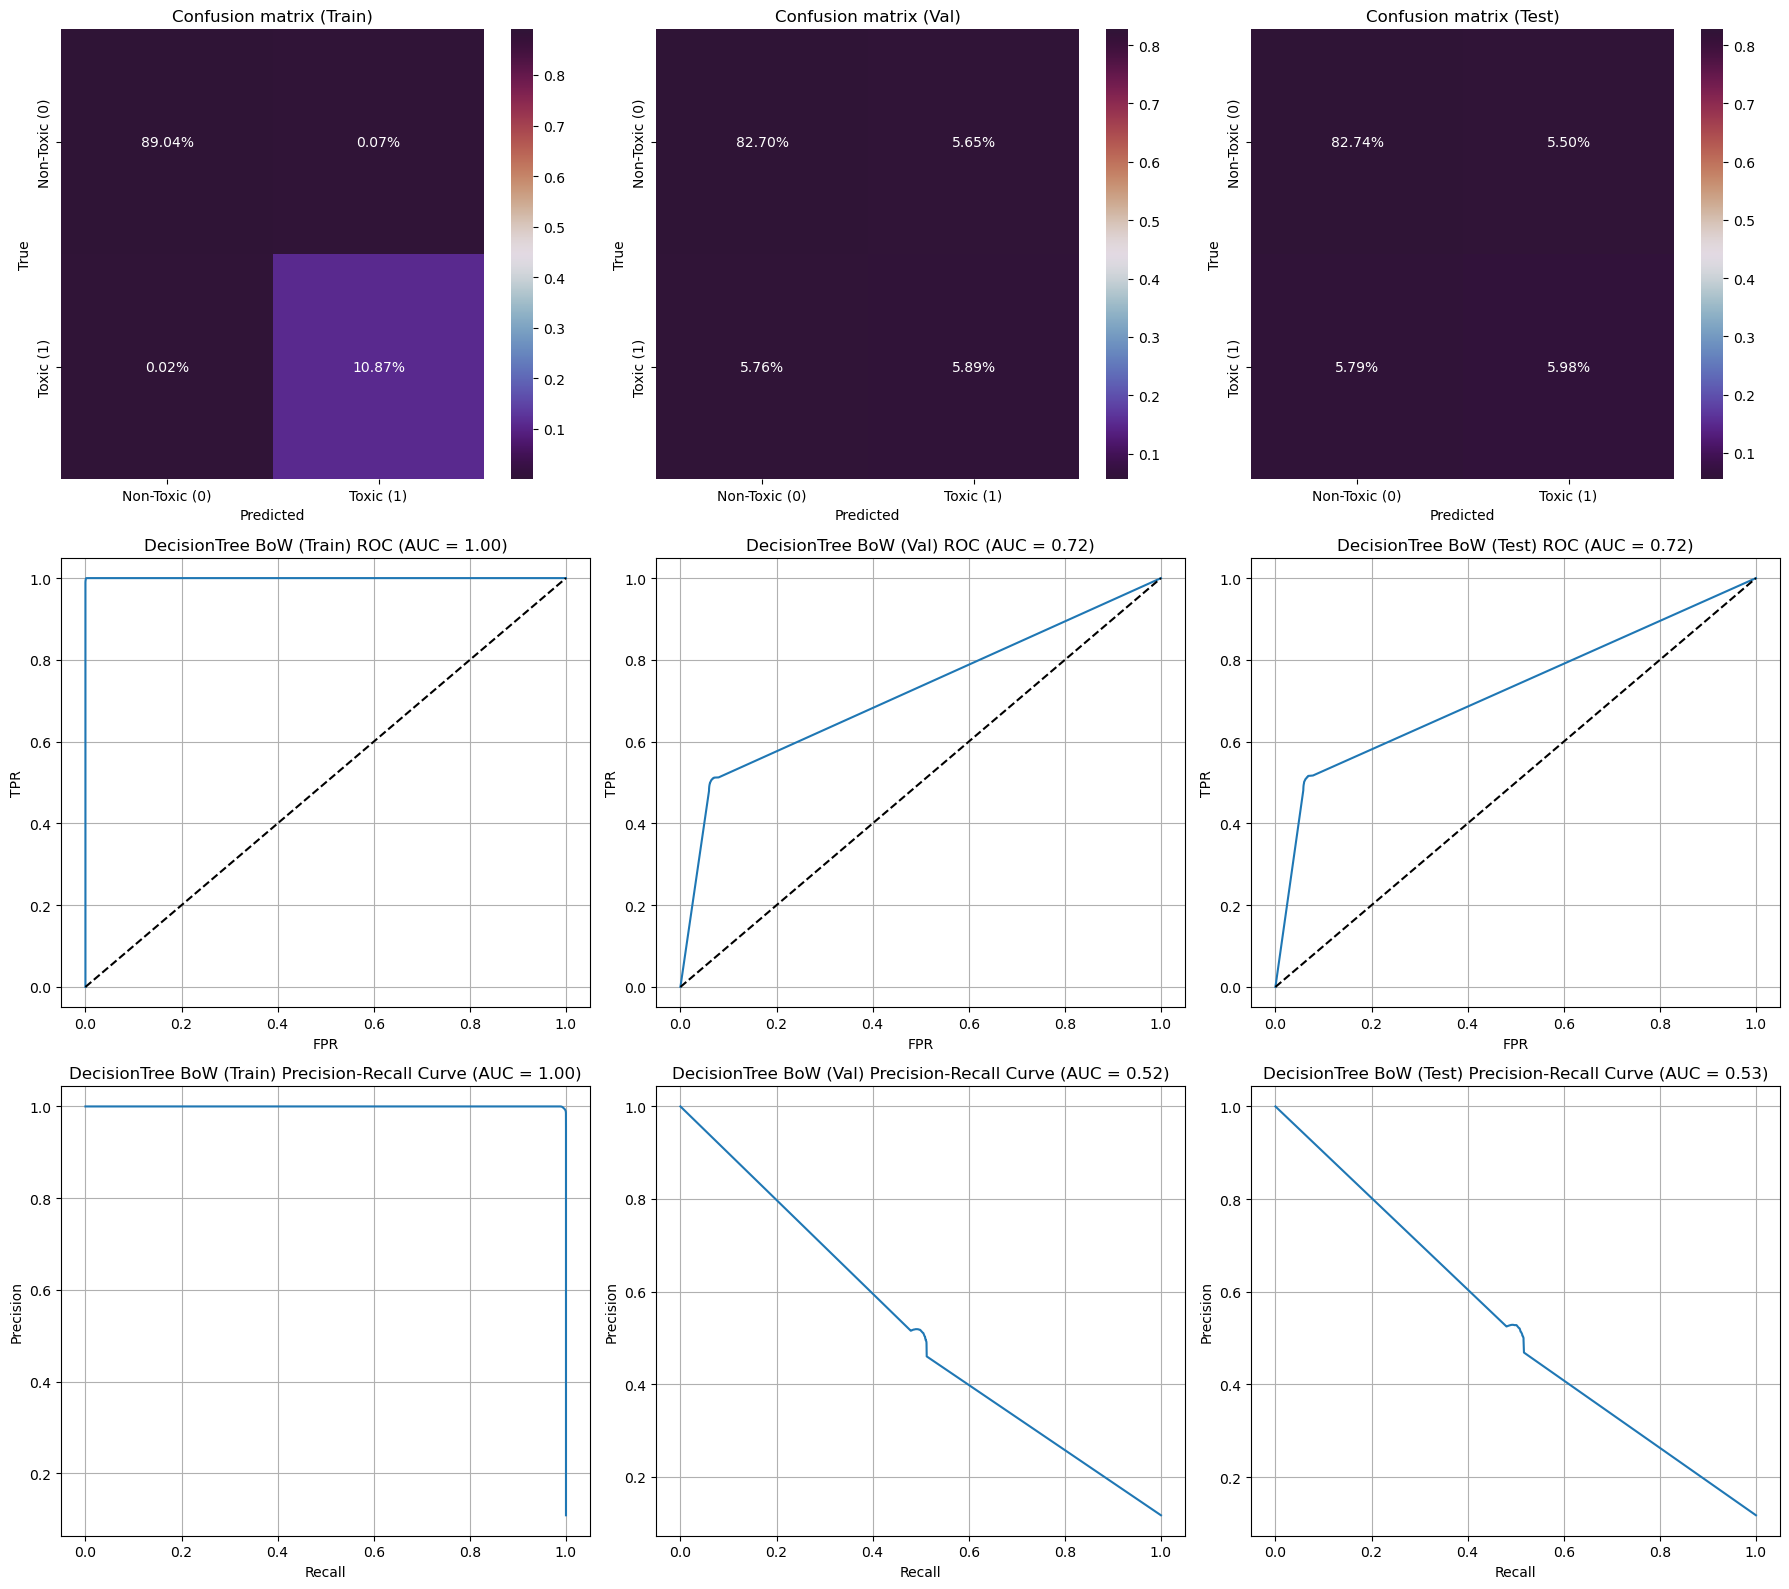

In [11]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_tree_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_tree_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_tree_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_tree_bow_pred_proba_train,
    y_pred_proba_val=y_tree_bow_pred_proba_val,
    y_pred_proba_test=y_tree_bow_pred_proba_test,
    title='DecisionTree BoW'
)

#### Optuna BoW

In [13]:
def tree_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        "max_depth": trial.suggest_int("max_depth", 40, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 1000),
        "max_features": trial.suggest_int("max_features", 500, 5000),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5000, 10000),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
    }
    
    model = DecisionTreeClassifier(**param)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [14]:
best_tree_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, tree_objective, n_trials=30)
(
    y_tree_bow_pred_train,
    y_tree_bow_pred_val,
    y_tree_bow_pred_test,
    y_tree_bow_pred_proba_train,
    y_tree_bow_pred_proba_val,
    y_tree_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(**best_tree_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-03-06 21:41:23,712] A new study created in memory with name: no-name-68bb92dc-fc06-471a-80c0-ef3ea90bd233
[I 2025-03-06 21:41:25,181] Trial 0 finished with value: 0.3186517388927159 and parameters: {'max_depth': 61, 'min_samples_split': 951, 'max_features': 1367, 'min_samples_leaf': 16, 'max_leaf_nodes': 7244, 'criterion': 'gini', 'class_weight': None}. Best is trial 0 with value: 0.3186517388927159.
[I 2025-03-06 21:41:34,189] Trial 1 finished with value: 0.4856866569187984 and parameters: {'max_depth': 82, 'min_samples_split': 763, 'max_features': 4592, 'min_samples_leaf': 11, 'max_leaf_nodes': 8185, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4856866569187984.
[I 2025-03-06 21:41:39,631] Trial 2 finished with value: 0.478099370569951 and parameters: {'max_depth': 85, 'min_samples_split': 507, 'max_features': 2168, 'min_samples_leaf': 13, 'max_leaf_nodes': 6846, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 1 with value: 0

In [15]:
t = get_threshold(y_val, y_tree_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.24


DecisionTree BoW

Precision		Recall			F1

Train: 0.49		Train: 0.58		Train: 0.53
Val: 0.49		Val: 0.57		Val: 0.53
Test: 0.50		Test: 0.58		Test: 0.54


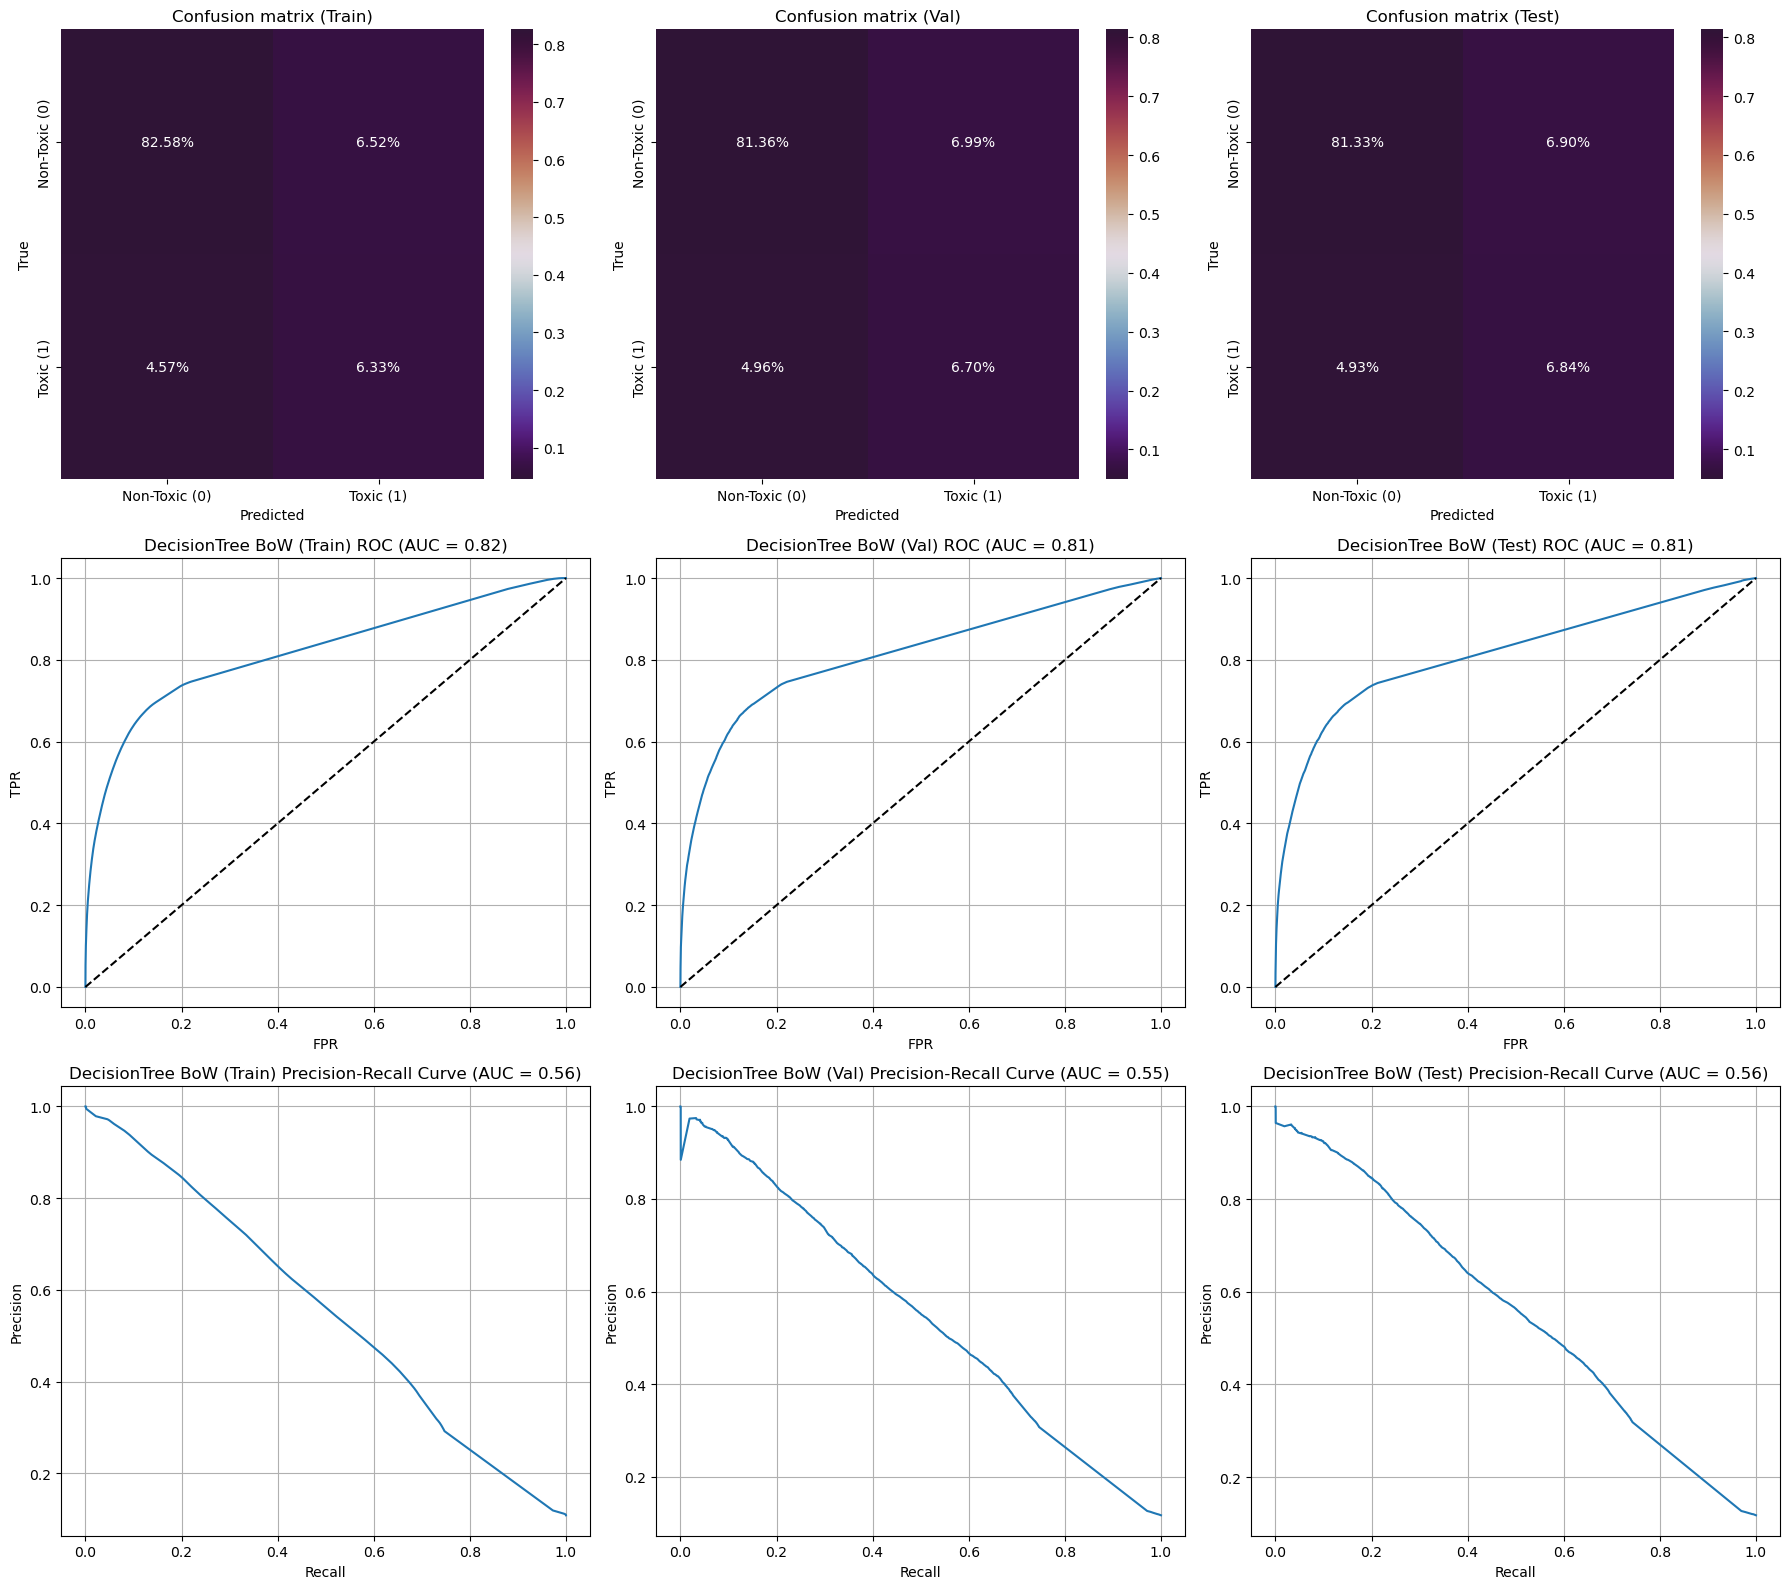

In [16]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_tree_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_tree_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_tree_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_tree_bow_pred_proba_train,
    y_pred_proba_val=y_tree_bow_pred_proba_val,
    y_pred_proba_test=y_tree_bow_pred_proba_test,
    title='DecisionTree BoW'
)

#### Base TF-IDF

In [18]:
(
    y_tree_tfidf_pred_train,
    y_tree_tfidf_pred_val,
    y_tree_tfidf_pred_test,
    y_tree_tfidf_pred_proba_train,
    y_tree_tfidf_pred_proba_val,
    y_tree_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [19]:
t = get_threshold(y_val, y_tree_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.37


DecisionTree TF-IDF

Precision		Recall			F1

Train: 0.99		Train: 1.00		Train: 0.99
Val: 0.54		Val: 0.50		Val: 0.52
Test: 0.55		Test: 0.50		Test: 0.53


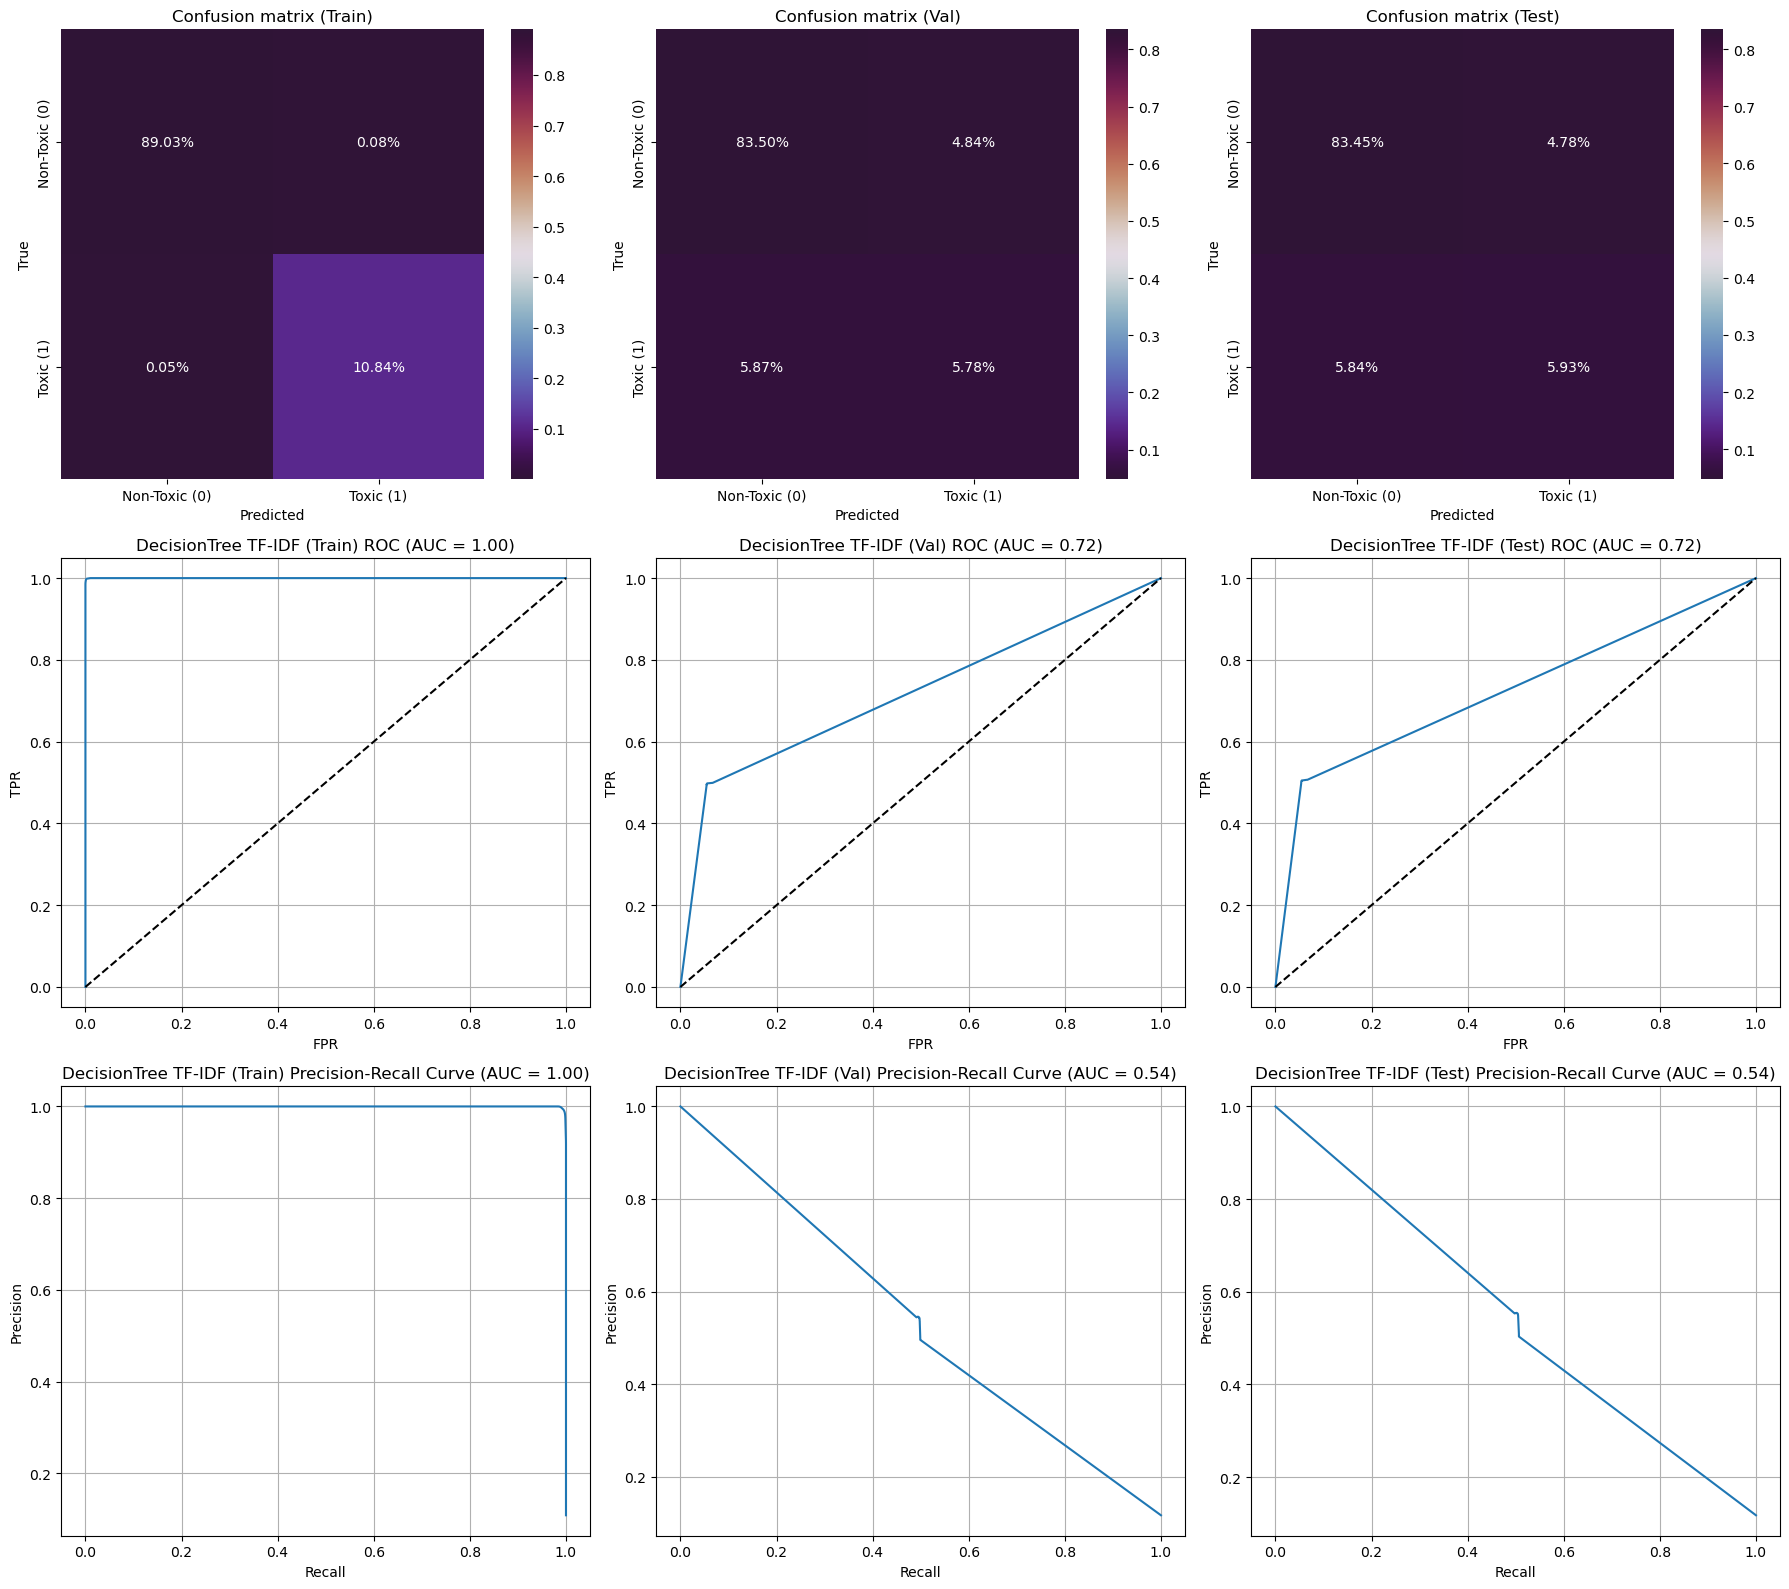

In [20]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_tree_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_tree_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_tree_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_tree_tfidf_pred_proba_train,
    y_pred_proba_val=y_tree_tfidf_pred_proba_val,
    y_pred_proba_test=y_tree_tfidf_pred_proba_test,
    title='DecisionTree TF-IDF'
)

#### Optuna TF-IDF

In [22]:
best_tree_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, tree_objective, n_trials=30)
(
    y_tree_tfidf_pred_train,
    y_tree_tfidf_pred_val,
    y_tree_tfidf_pred_test,
    y_tree_tfidf_pred_proba_train,
    y_tree_tfidf_pred_proba_val,
    y_tree_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(**best_tree_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-03-06 23:15:00,532] A new study created in memory with name: no-name-78244eaa-76cb-44b5-b8c0-21226752e380
[I 2025-03-06 23:16:16,551] Trial 0 finished with value: 0.6040174808148937 and parameters: {'max_depth': 61, 'min_samples_split': 786, 'max_features': 4372, 'min_samples_leaf': 23, 'max_leaf_nodes': 8454, 'criterion': 'entropy', 'class_weight': None}. Best is trial 0 with value: 0.6040174808148937.
[I 2025-03-06 23:16:36,972] Trial 1 finished with value: 0.5576905213626011 and parameters: {'max_depth': 49, 'min_samples_split': 265, 'max_features': 1062, 'min_samples_leaf': 11, 'max_leaf_nodes': 8934, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6040174808148937.
[I 2025-03-06 23:17:27,216] Trial 2 finished with value: 0.5819066669781783 and parameters: {'max_depth': 46, 'min_samples_split': 114, 'max_features': 2705, 'min_samples_leaf': 19, 'max_leaf_nodes': 7334, 'criterion': 'entropy', 'class_weight': None}. Best is trial 0 with value: 

In [23]:
t = get_threshold(y_val, y_tree_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.29


DecisionTree TF-IDF

Precision		Recall			F1

Train: 0.59		Train: 0.64		Train: 0.62
Val: 0.57		Val: 0.62		Val: 0.59
Test: 0.58		Test: 0.62		Test: 0.60


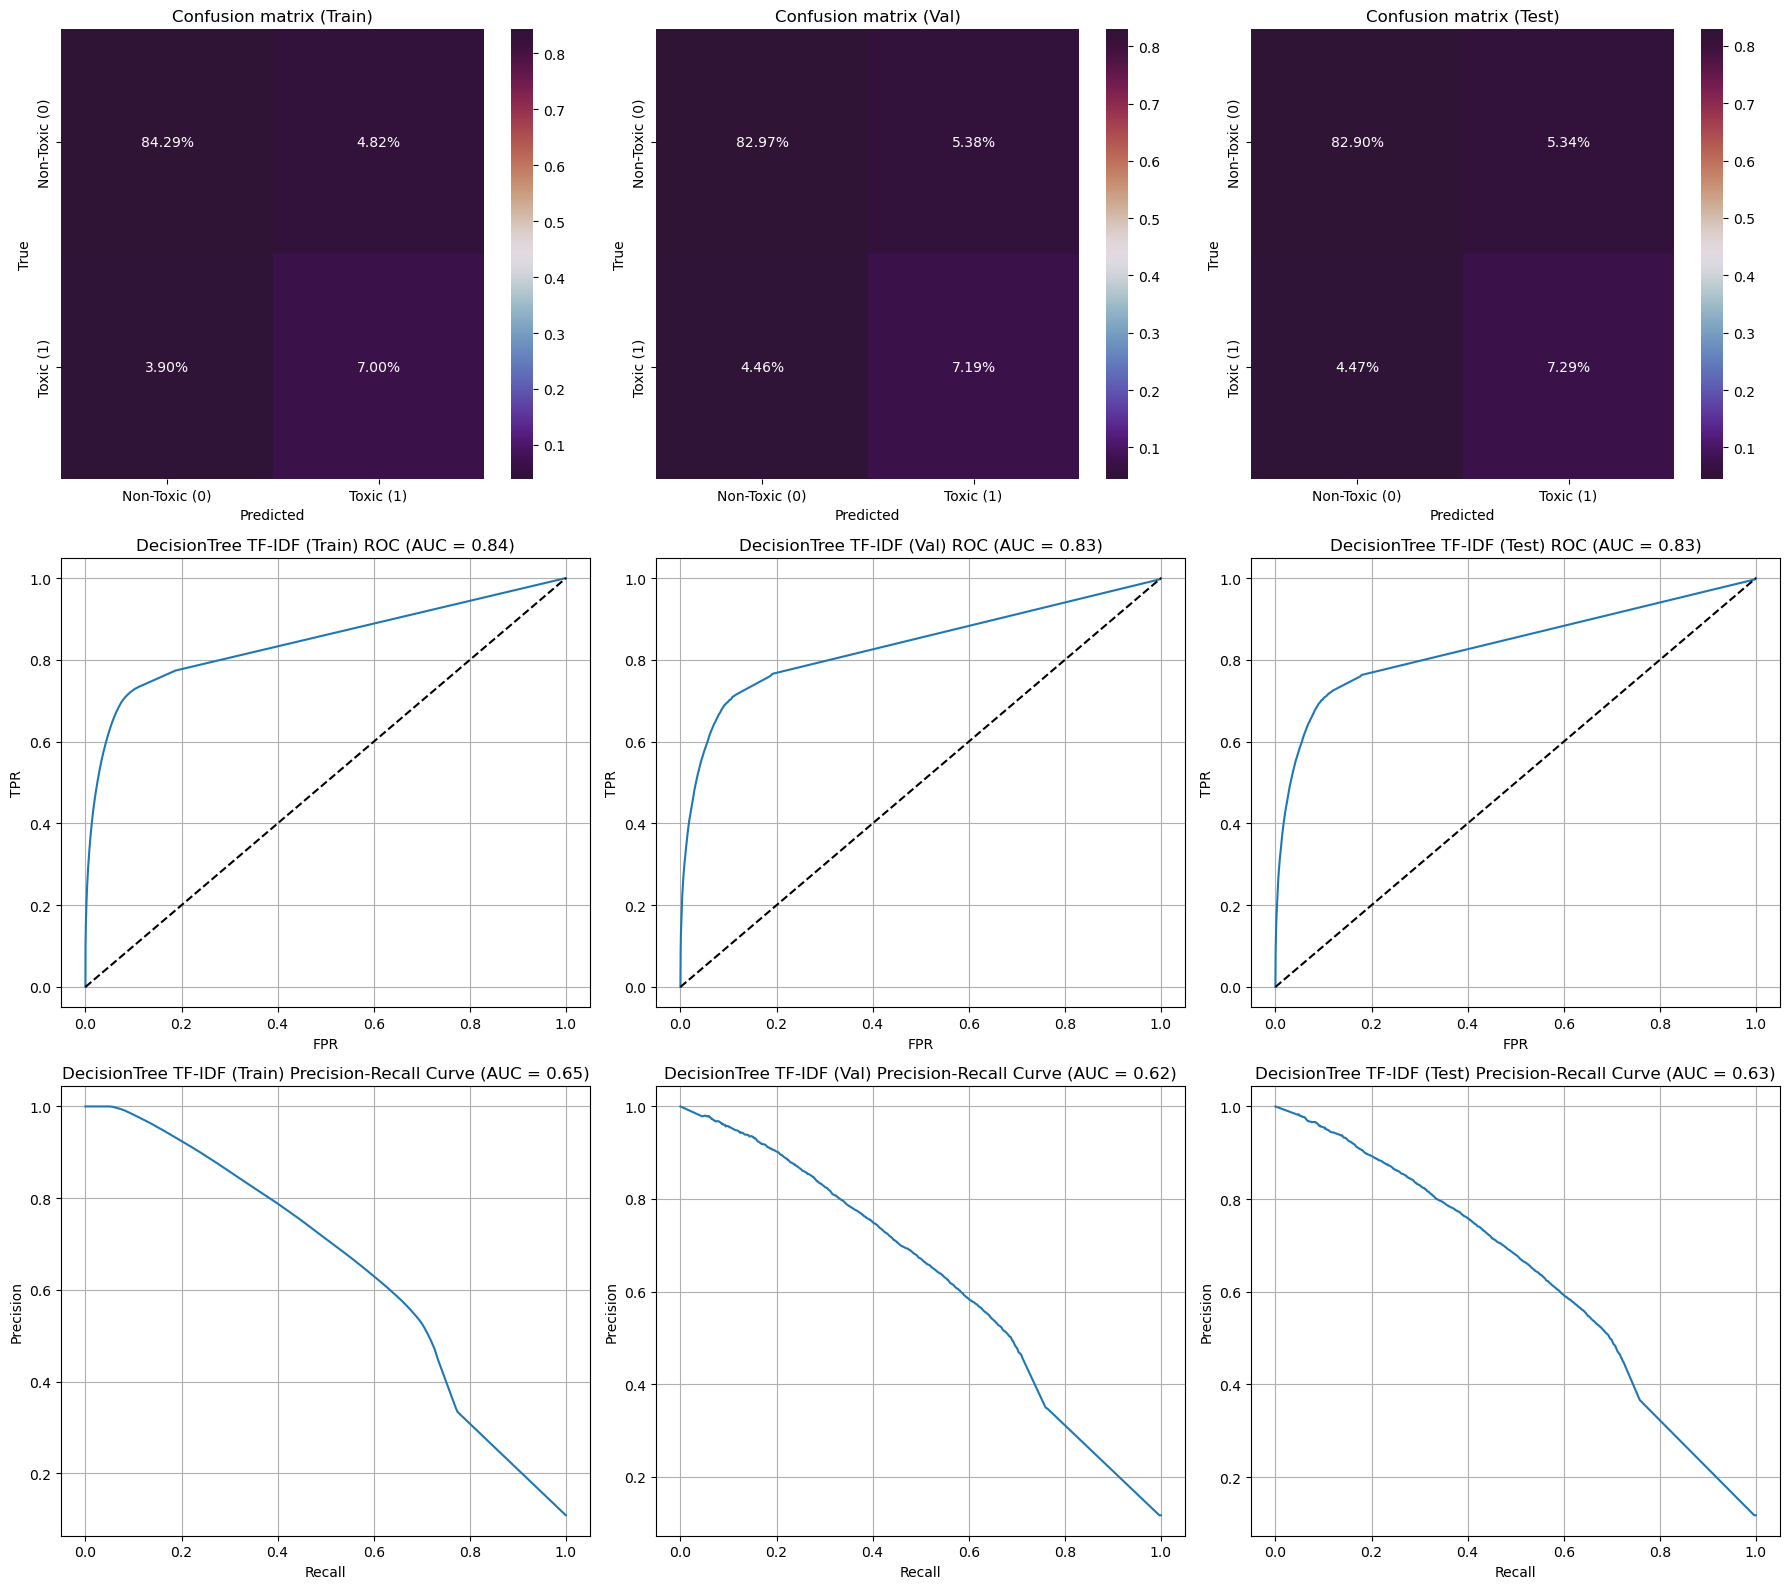

In [24]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_tree_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_tree_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_tree_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_tree_tfidf_pred_proba_train,
    y_pred_proba_val=y_tree_tfidf_pred_proba_val,
    y_pred_proba_test=y_tree_tfidf_pred_proba_test,
    title='DecisionTree TF-IDF'
)

### Random Forest

#### Base BoW

In [55]:
(
    y_rf_bow_pred_train,
    y_rf_bow_pred_val,
    y_rf_bow_pred_test,
    y_rf_bow_pred_proba_train,
    y_rf_bow_pred_proba_val,
    y_rf_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBRFClassifier(),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [56]:
t = get_threshold(y_val, y_rf_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.11


Random Forest BoW

Precision		Recall			F1

Train: 0.76		Train: 0.25		Train: 0.38
Val: 0.78		Val: 0.23		Val: 0.36
Test: 0.78		Test: 0.24		Test: 0.36


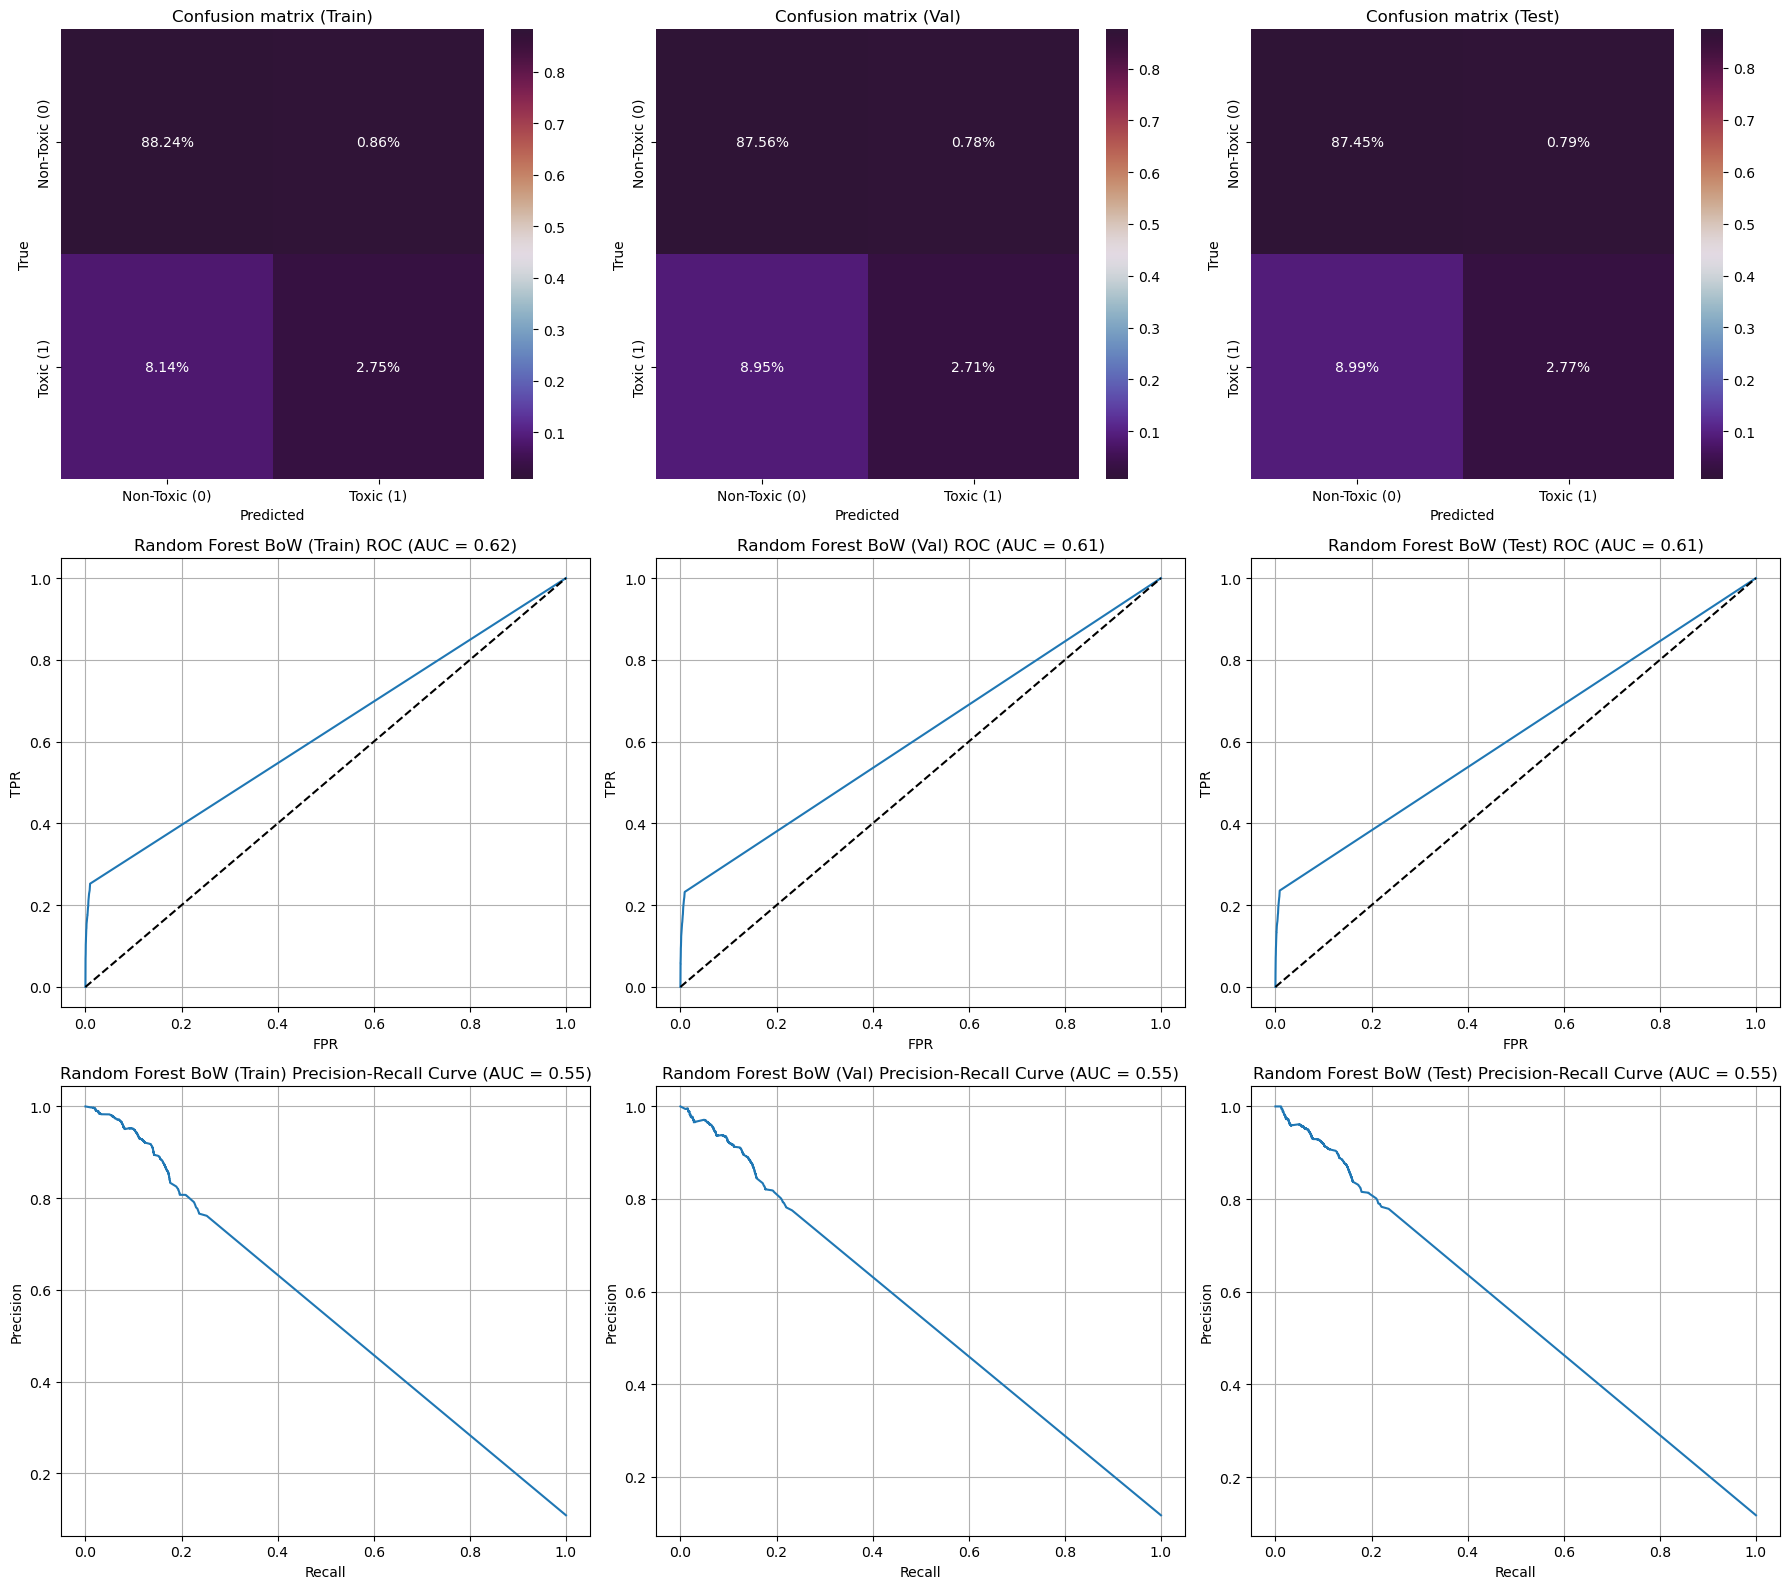

In [57]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_rf_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_rf_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_rf_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_rf_bow_pred_proba_train,
    y_pred_proba_val=y_rf_bow_pred_proba_val,
    y_pred_proba_test=y_rf_bow_pred_proba_test,
    title='Random Forest BoW'
)

#### Optuna BoW

In [9]:
def xgbrf_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),  # Количество деревьев
        "max_depth": trial.suggest_int("max_depth", 20, 50),  # Максимальная глубина деревьев
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Доля объектов при обучении каждого дерева
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.5),  # Доля признаков при обучении каждого дерева
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 40),  # Мин. вес узла
        #"reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  # L2-регуляризация
        #"reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),  # L1-регуляризация
        #"num_parallel_tree": trial.suggest_int("num_parallel_tree", 10, 100),  # Количество деревьев в ансамбле
        "tree_method": "hist",  
        "random_state": 42,
    }

    model = XGBRFClassifier(**param, use_label_encoder=False)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

    del model
    gc.collect()
    
    return auc(recall, precision)

In [11]:
#best_rf_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, xgbrf_objective, n_trials=30)
best_rf_params = {'n_estimators': 130, 'max_depth': 48, 'subsample': 0.9191922352381161,
                  'colsample_bytree': 0.34919544347722553, 'min_child_weight': 11}
(
    y_rf_bow_pred_train,
    y_rf_bow_pred_val,
    y_rf_bow_pred_test,
    y_rf_bow_pred_proba_train,
    y_rf_bow_pred_proba_val,
    y_rf_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBRFClassifier(**best_rf_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [12]:
t = get_threshold(y_val, y_rf_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.19


Random Forest BoW

Precision		Recall			F1

Train: 0.60		Train: 0.63		Train: 0.62
Val: 0.59		Val: 0.63		Val: 0.61
Test: 0.60		Test: 0.62		Test: 0.61


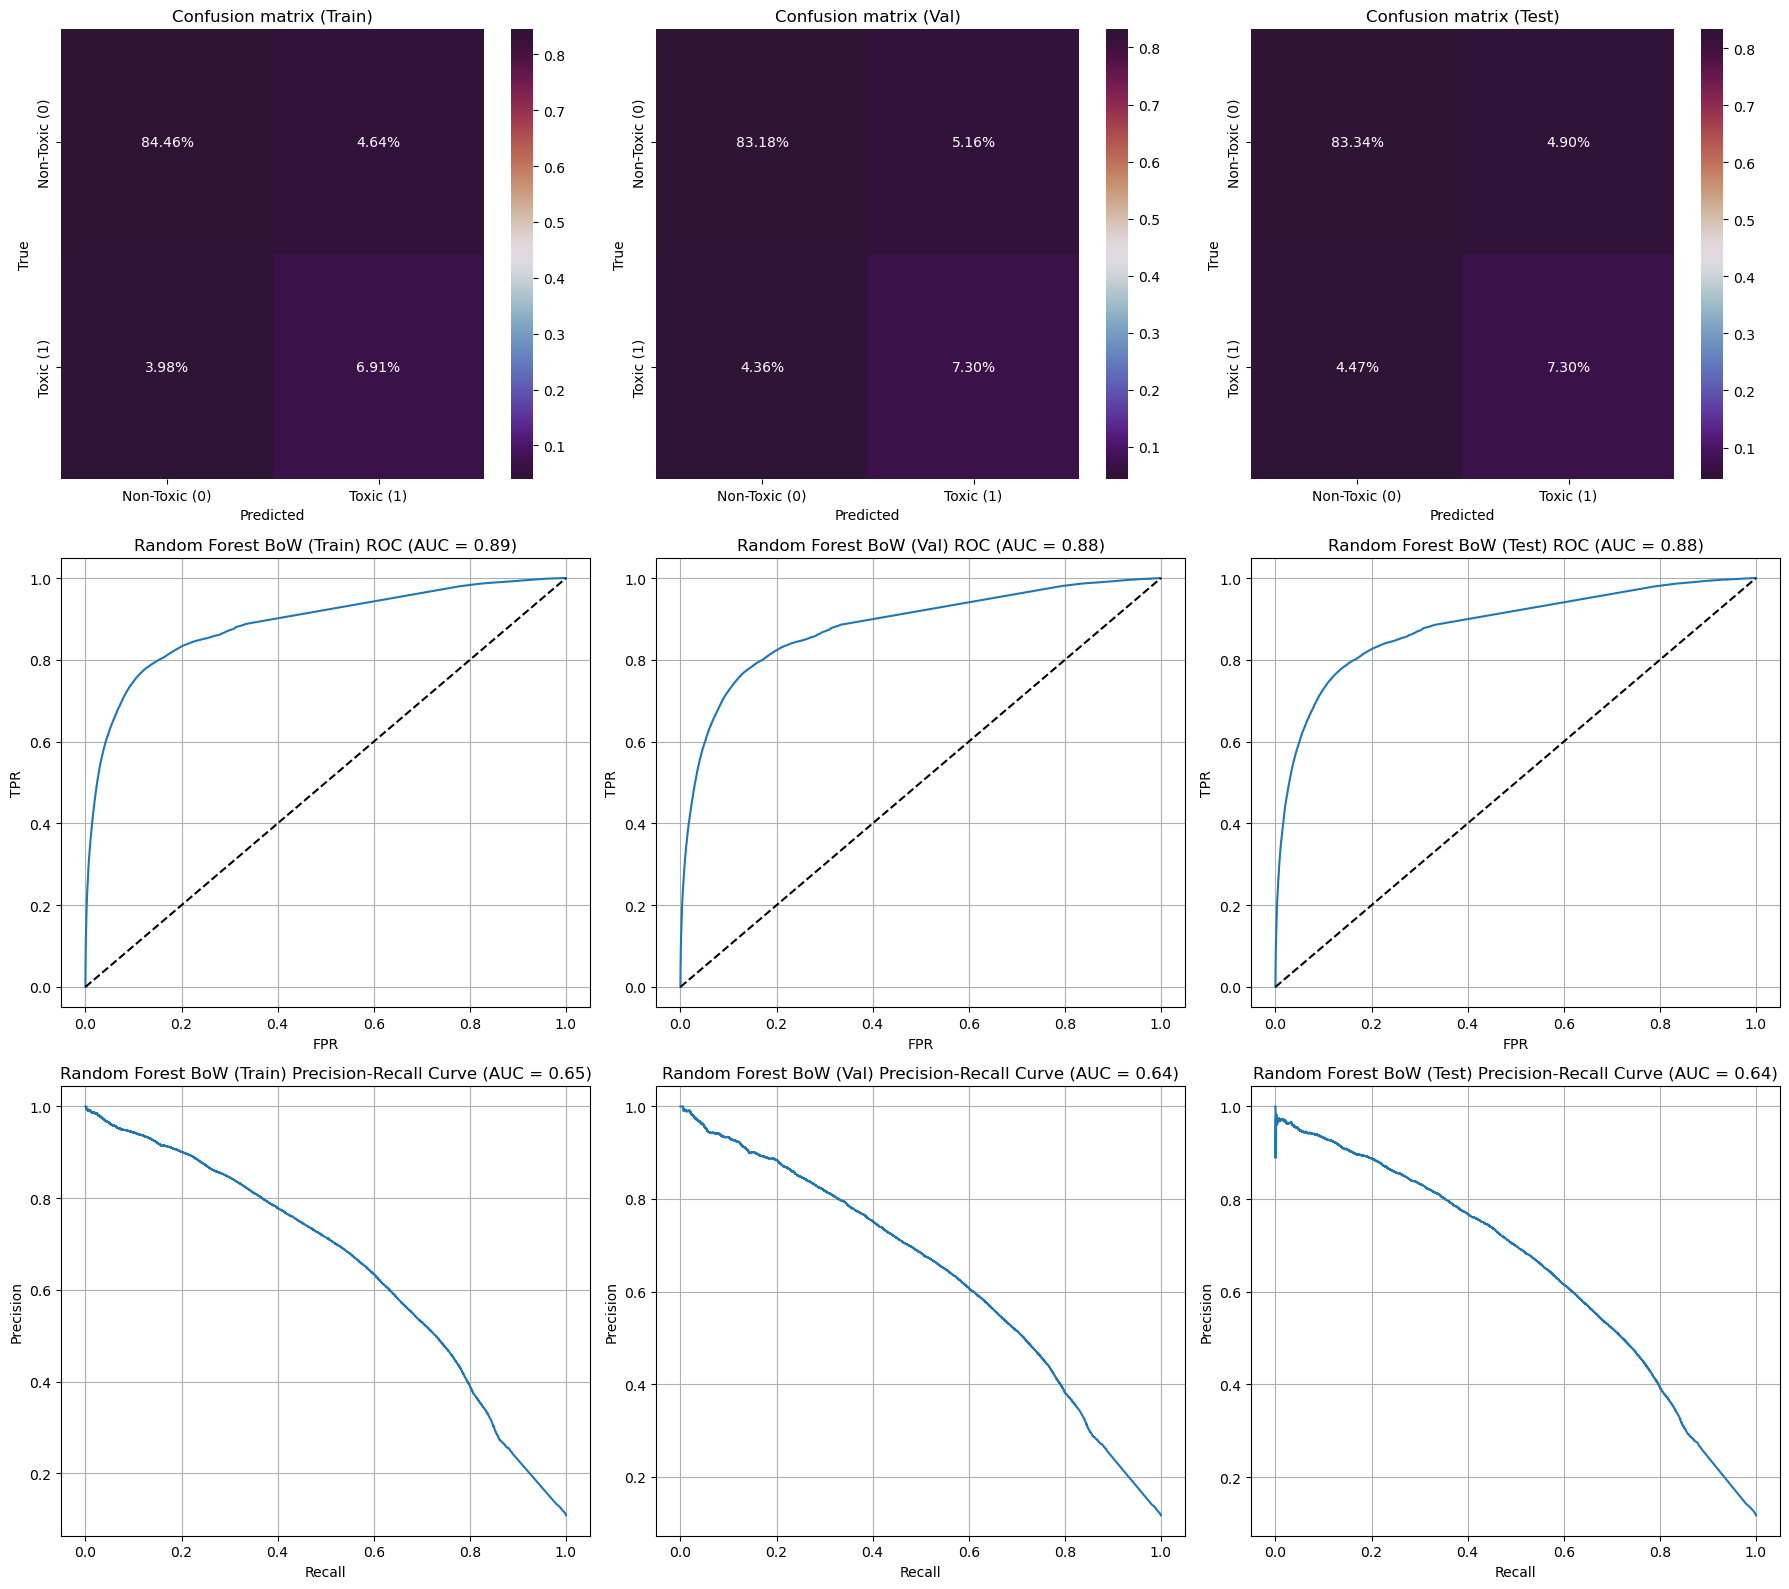

In [13]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_rf_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_rf_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_rf_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_rf_bow_pred_proba_train,
    y_pred_proba_val=y_rf_bow_pred_proba_val,
    y_pred_proba_test=y_rf_bow_pred_proba_test,
    title='Random Forest BoW'
)

#### Base TF-IDF

In [15]:
(
    y_rf_tfidf_pred_train,
    y_rf_tfidf_pred_val,
    y_rf_tfidf_pred_test,
    y_rf_tfidf_pred_proba_train,
    y_rf_tfidf_pred_proba_val,
    y_rf_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBRFClassifier(),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [16]:
t = get_threshold(y_val, y_rf_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.13


Random Forest TF-IDF

Precision		Recall			F1

Train: 0.77		Train: 0.23		Train: 0.36
Val: 0.79		Val: 0.22		Val: 0.34
Test: 0.79		Test: 0.22		Test: 0.34


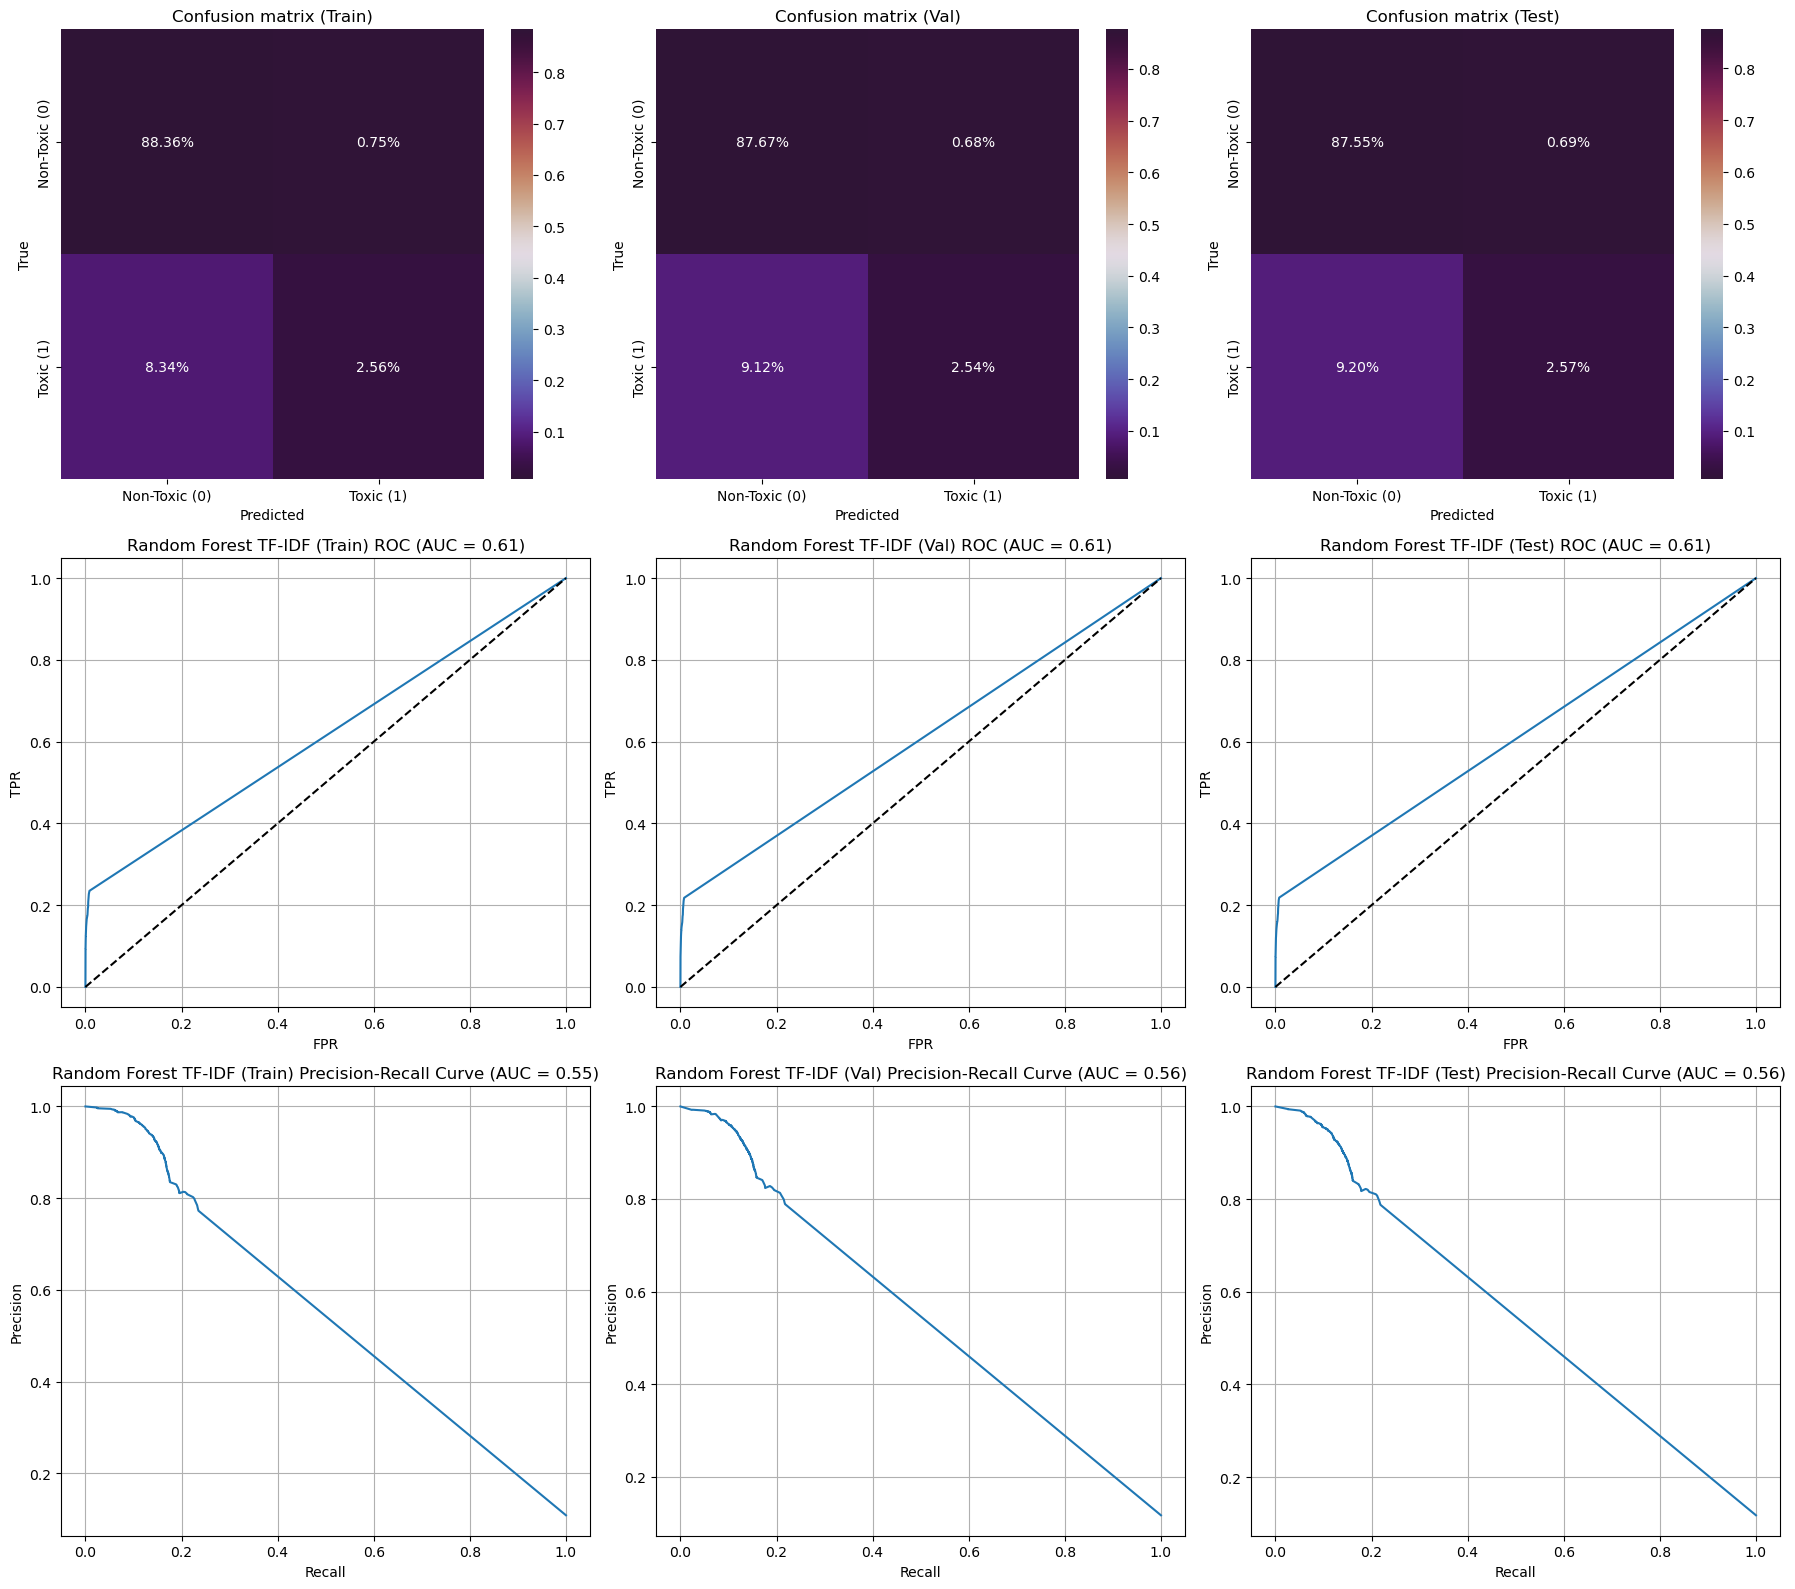

In [17]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_rf_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_rf_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_rf_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_rf_tfidf_pred_proba_train,
    y_pred_proba_val=y_rf_tfidf_pred_proba_val,
    y_pred_proba_test=y_rf_tfidf_pred_proba_test,
    title='Random Forest TF-IDF'
)

#### Optuna TF-IDF

In [19]:
#best_rf_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, xgbrf_objective, n_trials=30)
best_rf_params = {'n_estimators': 407, 'max_depth': 45, 'subsample': 0.9722854939772396,
                  'colsample_bytree': 0.33823168832120015, 'min_child_weight': 36}

(
    y_rf_tfidf_pred_train,
    y_rf_tfidf_pred_val,
    y_rf_tfidf_pred_test,
    y_rf_tfidf_pred_proba_train,
    y_rf_tfidf_pred_proba_val,
    y_rf_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBRFClassifier(**best_rf_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [20]:
t = get_threshold(y_val, y_rf_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.18


Random Forest TF-IDF

Precision		Recall			F1

Train: 0.58		Train: 0.65		Train: 0.62
Val: 0.58		Val: 0.65		Val: 0.61
Test: 0.59		Test: 0.65		Test: 0.62


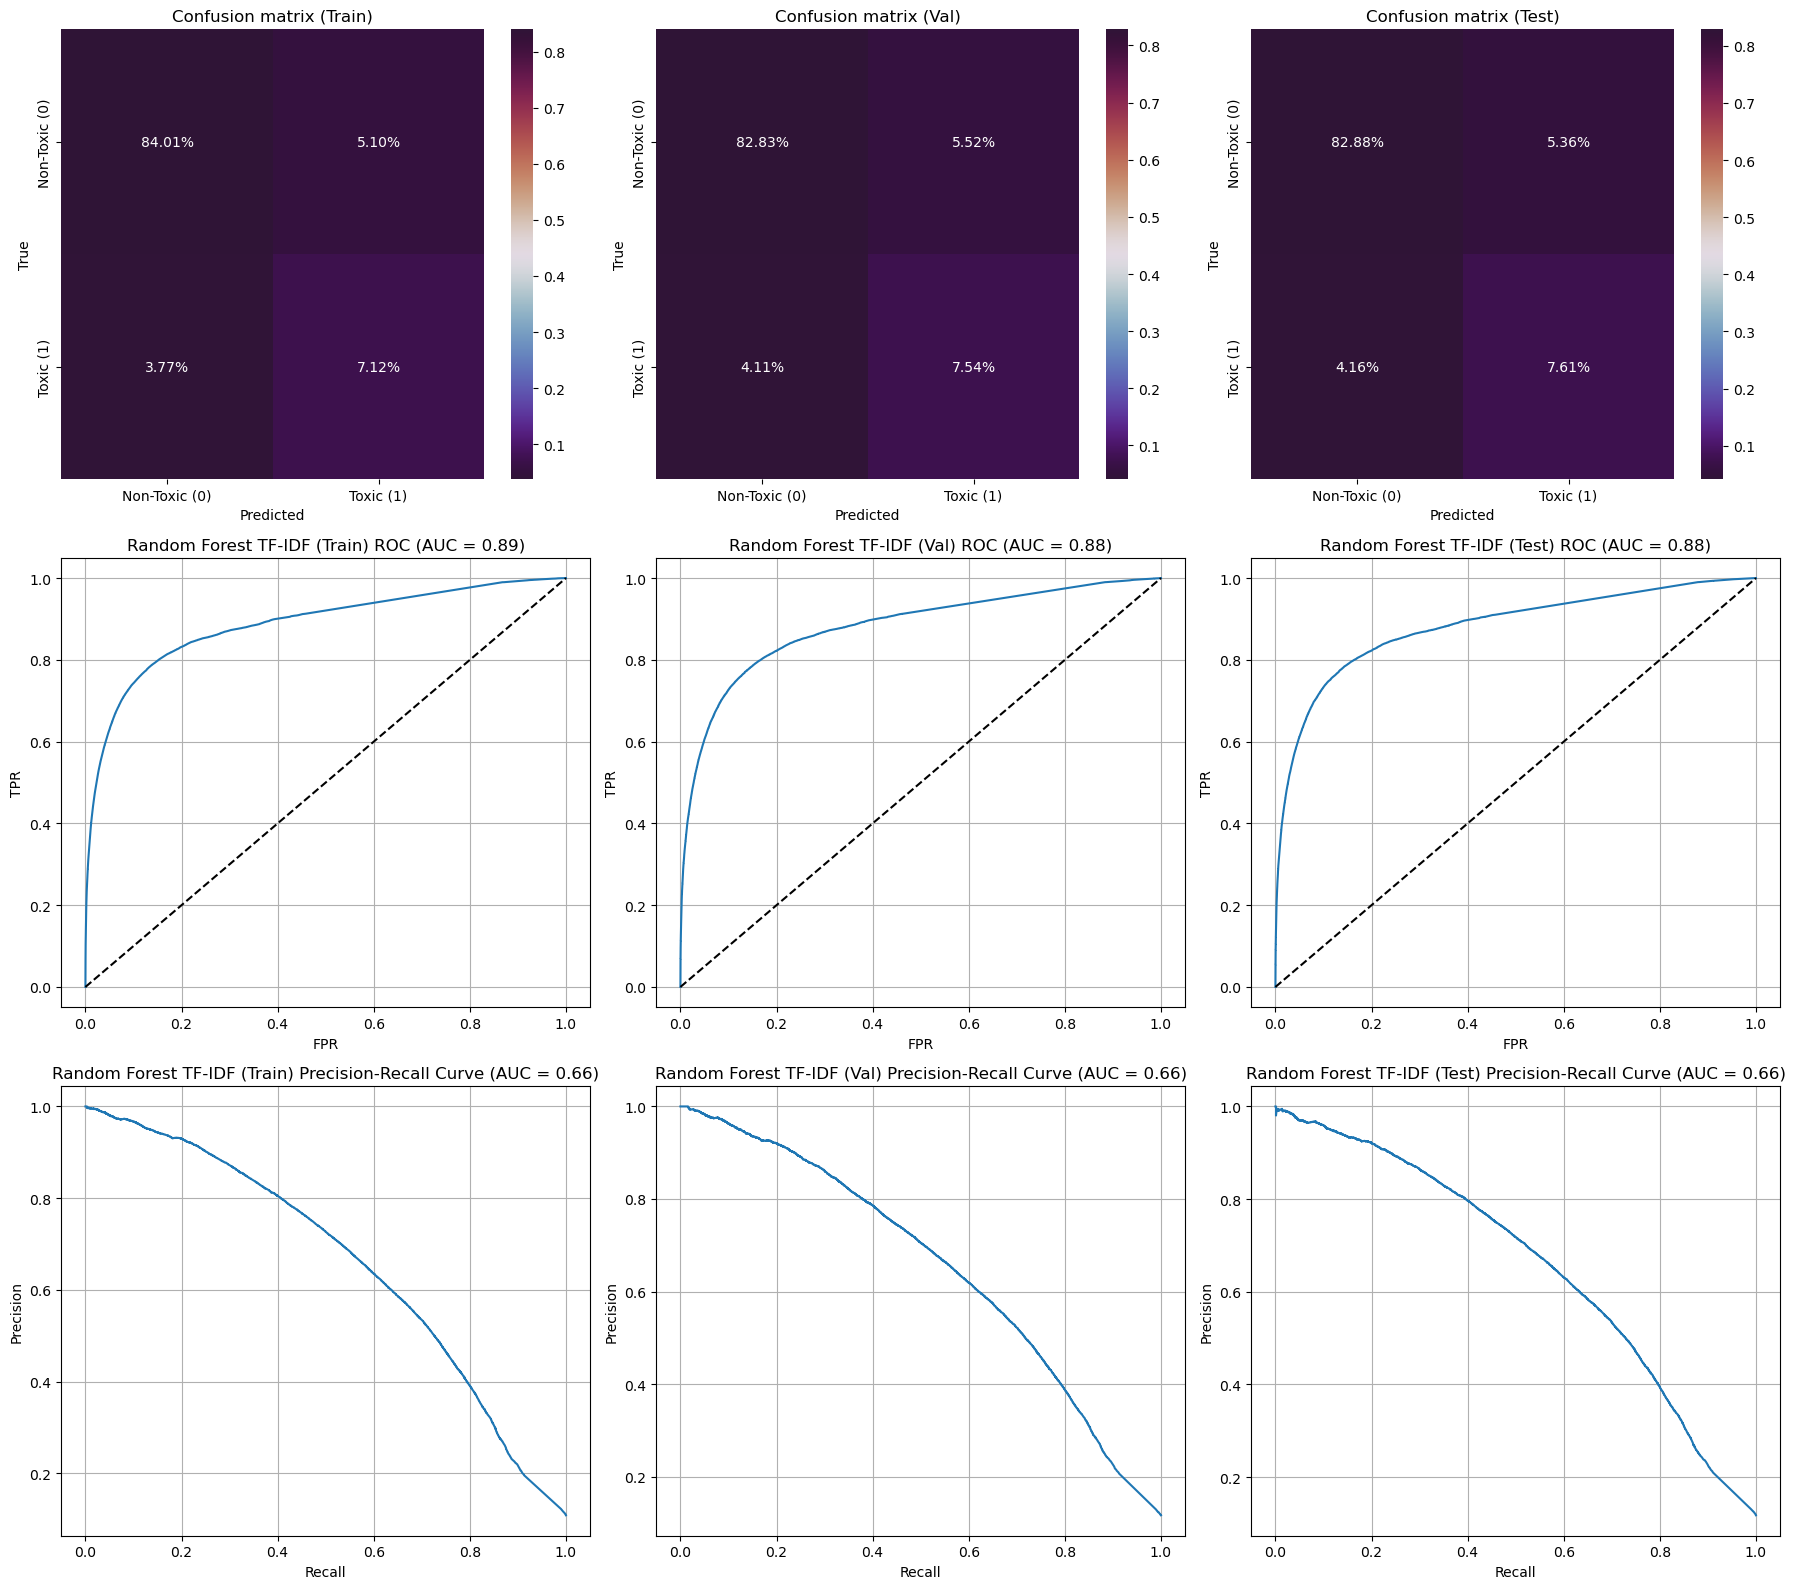

In [21]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_rf_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_rf_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_rf_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_rf_tfidf_pred_proba_train,
    y_pred_proba_val=y_rf_tfidf_pred_proba_val,
    y_pred_proba_test=y_rf_tfidf_pred_proba_test,
    title='Random Forest TF-IDF'
)

### XGBoost

#### Base BoW

In [22]:
(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [23]:
t = get_threshold(y_val, y_m1_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.19


XGBoost BoW

Precision		Recall			F1

Train: 0.61		Train: 0.65		Train: 0.63
Val: 0.60		Val: 0.63		Val: 0.62
Test: 0.61		Test: 0.63		Test: 0.62


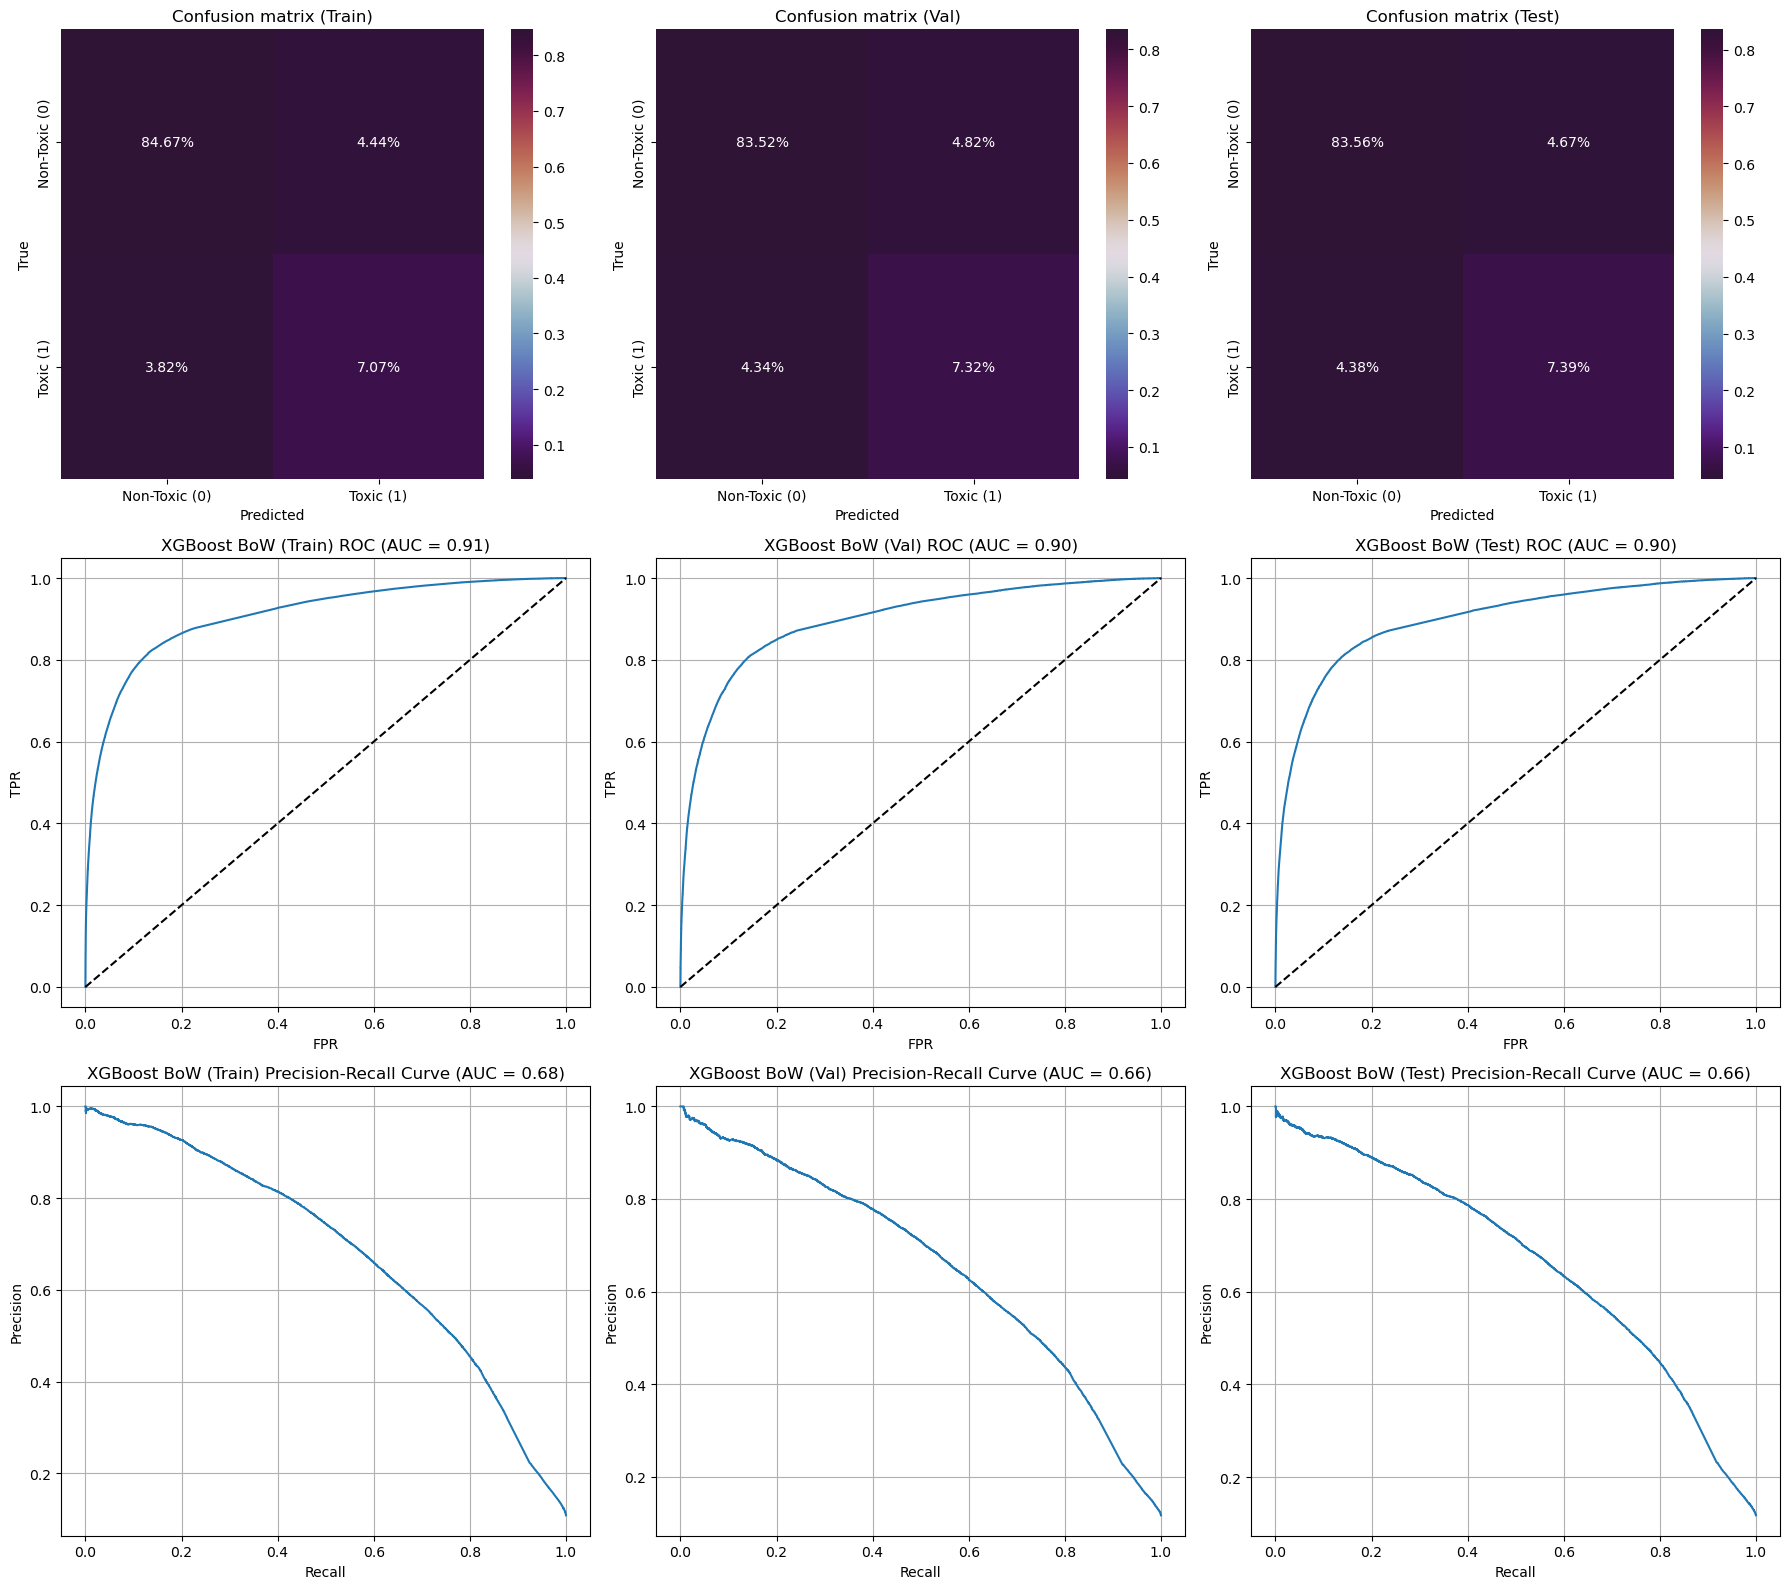

In [24]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_m1_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_m1_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_m1_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_m1_bow_pred_proba_train,
    y_pred_proba_val=y_m1_bow_pred_proba_val,
    y_pred_proba_test=y_m1_bow_pred_proba_test,
    title='XGBoost BoW'
)

#### Optuna BoW

In [26]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.2, 0.5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 10)
    }
    
    model = XGBClassifier(**param)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [27]:
#best_xg_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, xg_objective, n_trials=30)

best_xg_params = {'n_estimators': 484, 'max_depth': 20, 'learning_rate': 0.20004669977662015, 'subsample': 0.8446645954768127,
                  'colsample_bytree': 0.5244295275638243, 'gamma': 1.49384015025754, 'min_child_weight': 6, 'scale_pos_weight': 6}

(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [28]:
t = get_threshold(y_val, y_m1_bow_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.59


XGBoost BoW

Precision		Recall			F1

Train: 0.73		Train: 0.82		Train: 0.77
Val: 0.62		Val: 0.68		Val: 0.65
Test: 0.63		Test: 0.68		Test: 0.66


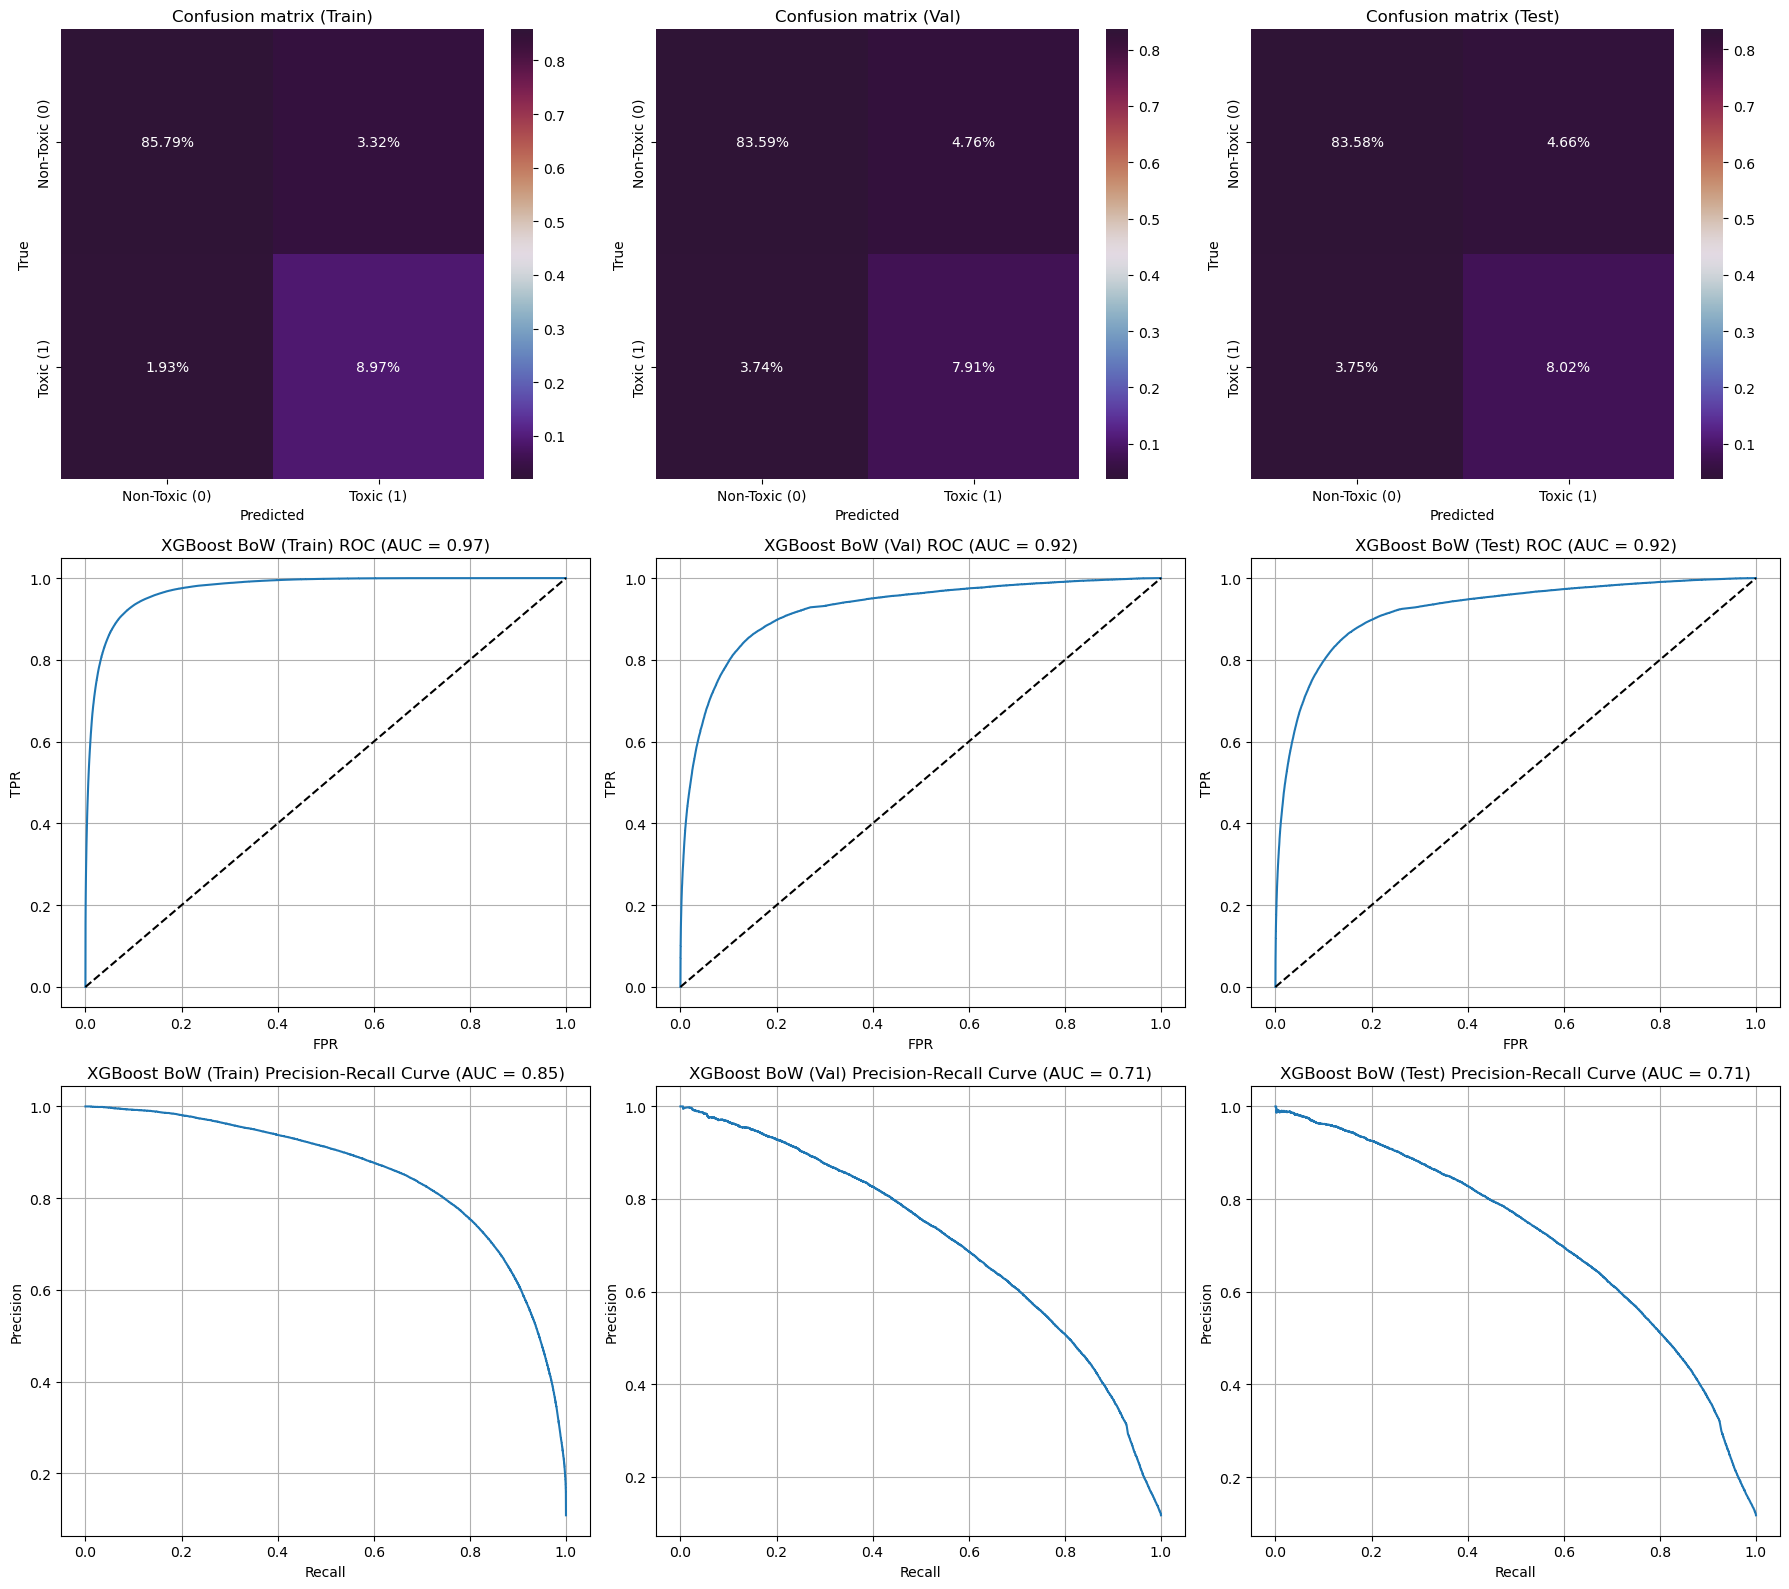

In [29]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_m1_bow_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_m1_bow_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_m1_bow_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_m1_bow_pred_proba_train,
    y_pred_proba_val=y_m1_bow_pred_proba_val,
    y_pred_proba_test=y_m1_bow_pred_proba_test,
    title='XGBoost BoW'
)

#### Base TF-IDF

In [33]:
(
    y_m1_tfidf_pred_train,
    y_m1_tfidf_pred_val,
    y_m1_tfidf_pred_test,
    y_m1_tfidf_pred_proba_train,
    y_m1_tfidf_pred_proba_val,
    y_m1_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [34]:
t = get_threshold(y_val, y_m1_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.22


XGBoost TF-IDF

Precision		Recall			F1

Train: 0.65		Train: 0.66		Train: 0.65
Val: 0.64		Val: 0.63		Val: 0.63
Test: 0.64		Test: 0.63		Test: 0.64


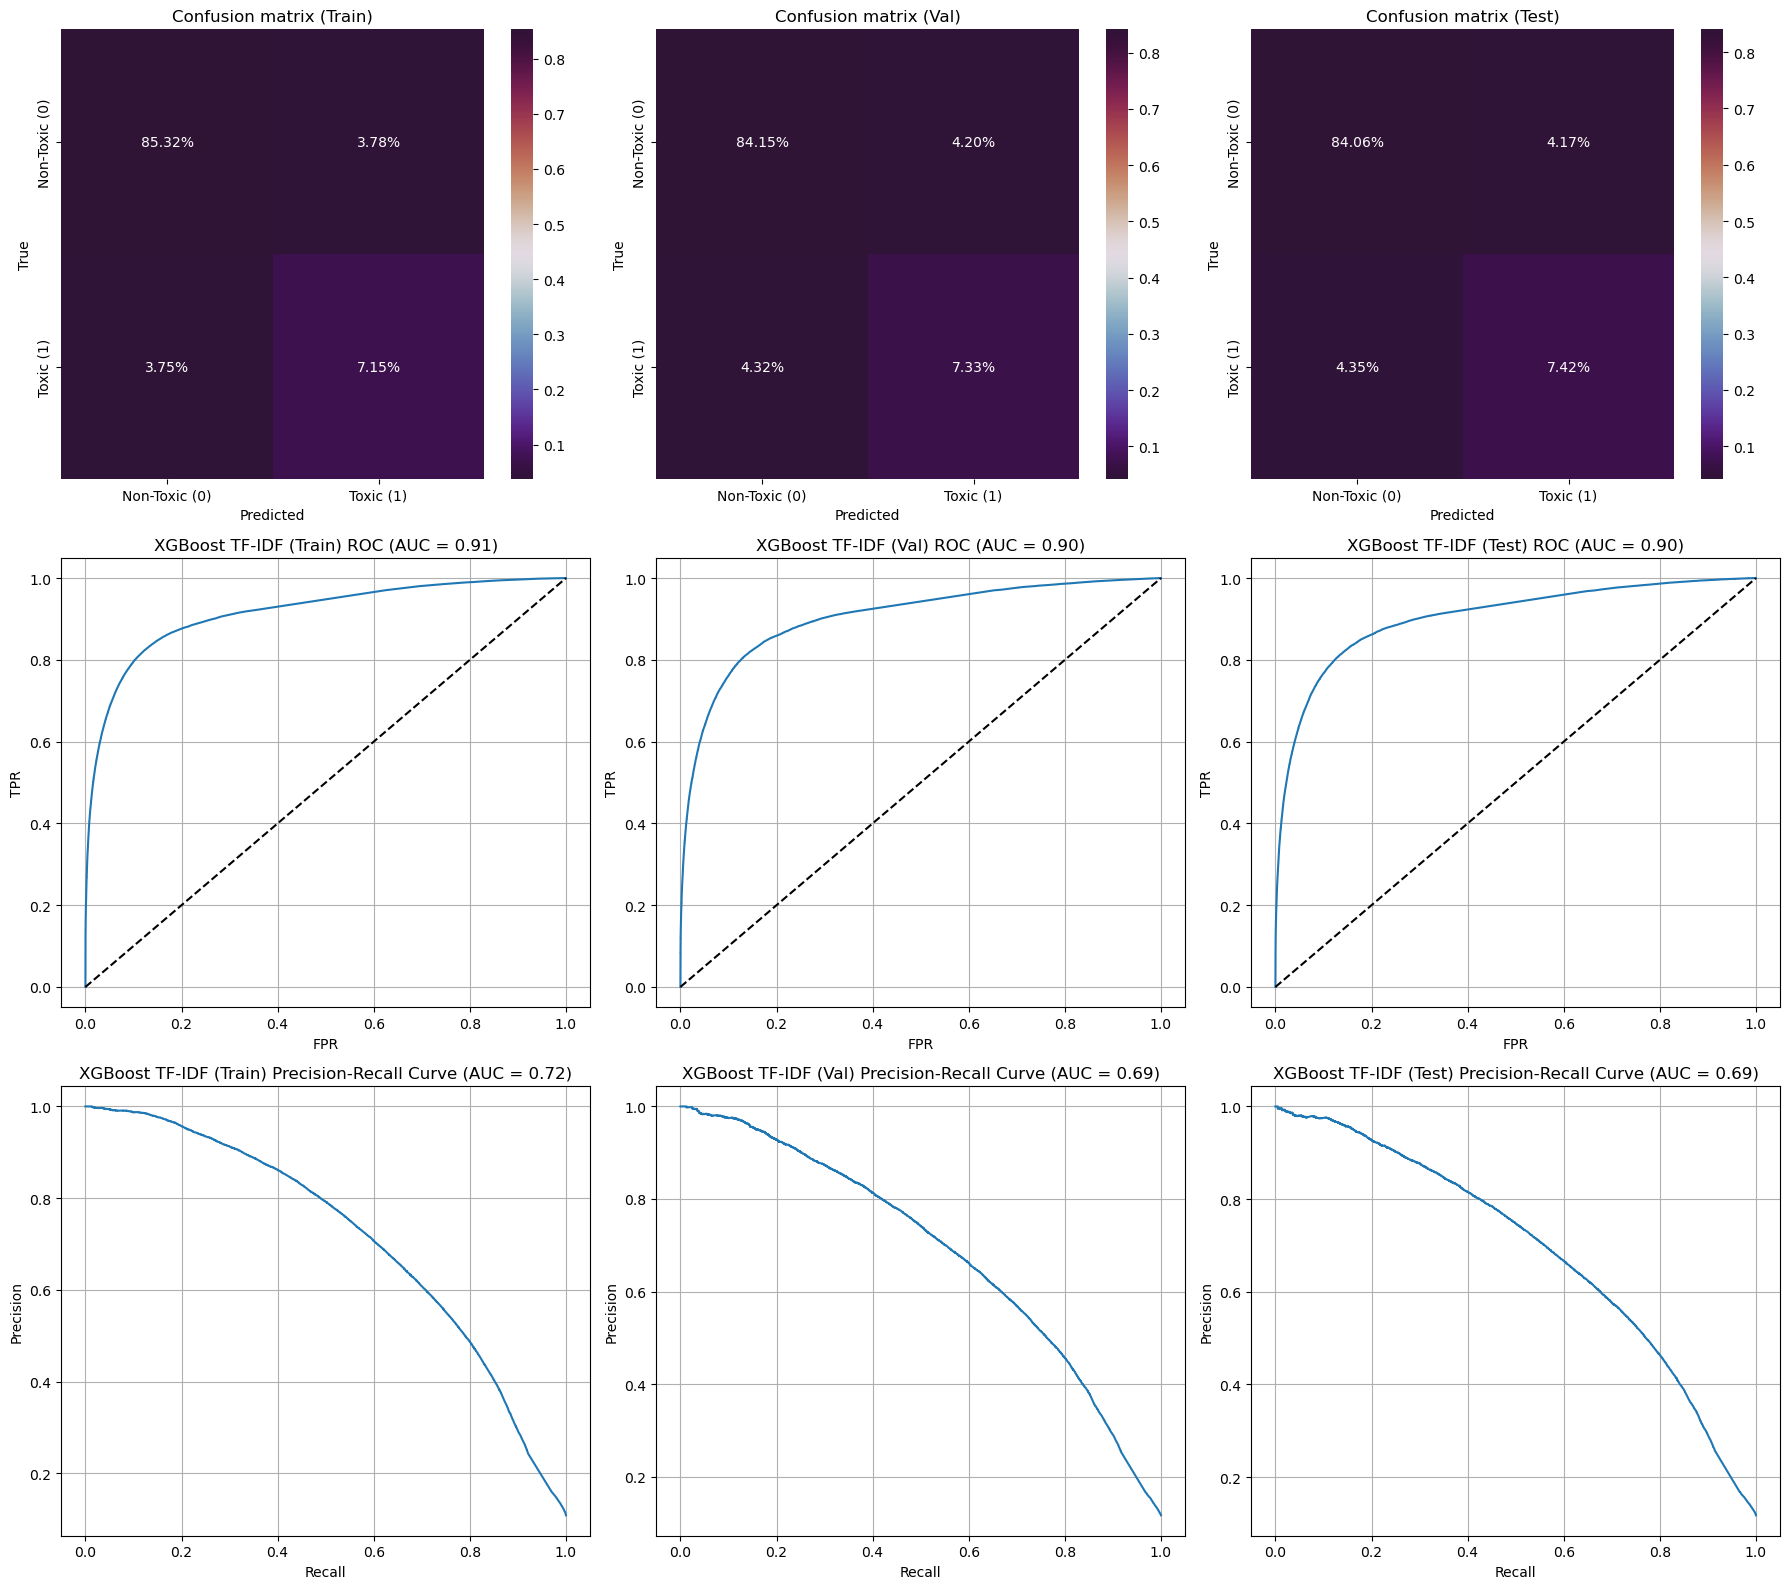

In [35]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_m1_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_m1_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_m1_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_m1_tfidf_pred_proba_train,
    y_pred_proba_val=y_m1_tfidf_pred_proba_val,
    y_pred_proba_test=y_m1_tfidf_pred_proba_test,
    title='XGBoost TF-IDF'
)

#### Optuna TF-IDF

In [37]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        'max_depth': trial.suggest_int('max_depth', 12, 18),  # Меньше глубина, так как данные плотнее
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),  # Более низкая скорость
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Можно больше, т.к. данные вещественные
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Больше признаков, чем в BoW
        'gamma': trial.suggest_float('gamma', 0, 5),  # Не нужно сильно ограничивать разбиения
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Можно меньше, так как значения TF-IDF вещественные
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 5),  # Меньше штрафа, чем в BoW
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 5),  # Балансировка классов, но слабее, чем в BoW
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'random_state': 42
    }
    model = XGBClassifier(**param)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [38]:
#best_xg_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, xg_objective, n_trials=30)
best_xg_params = {'max_depth': 16, 'learning_rate': 0.119567927967194, 'subsample': 0.902346475891198,
 'colsample_bytree': 0.6390555825880484, 'gamma': 3.4281962700115067, 'min_child_weight': 5, 'scale_pos_weight': 1, 'n_estimators': 951}

(
    y_m1_tfidf_pred_train,
    y_m1_tfidf_pred_val,
    y_m1_tfidf_pred_test,
    y_m1_tfidf_pred_proba_train,
    y_m1_tfidf_pred_proba_val,
    y_m1_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [39]:
t = get_threshold(y_val, y_m1_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.25


XGBoost TF-IDF

Precision		Recall			F1

Train: 0.71		Train: 0.77		Train: 0.74
Val: 0.63		Val: 0.68		Val: 0.66
Test: 0.64		Test: 0.68		Test: 0.66


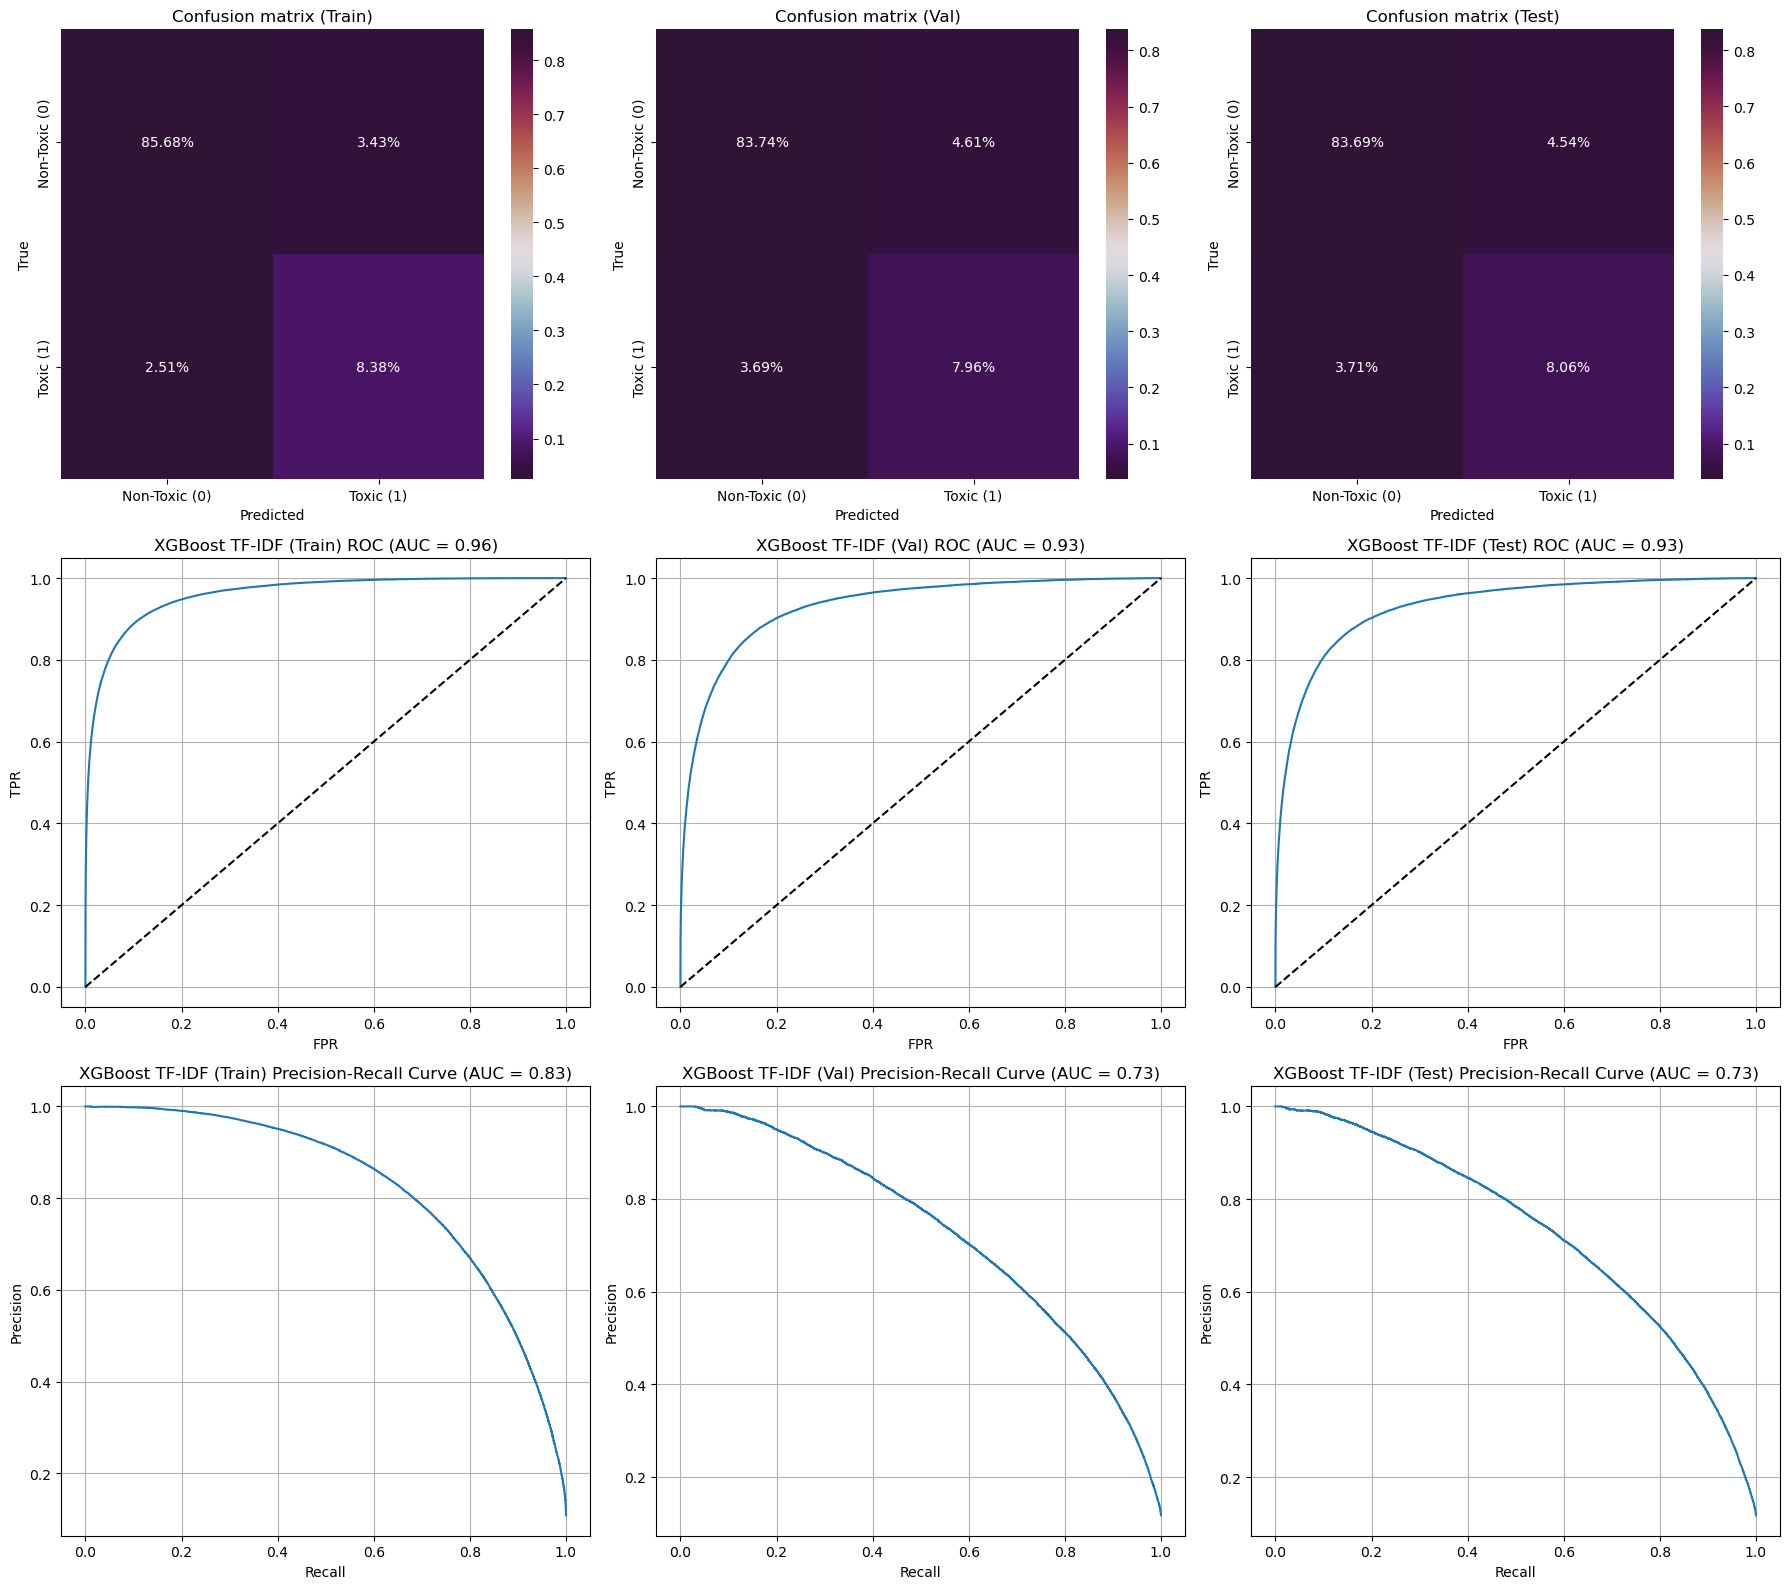

In [40]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_m1_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_m1_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_m1_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_m1_tfidf_pred_proba_train,
    y_pred_proba_val=y_m1_tfidf_pred_proba_val,
    y_pred_proba_test=y_m1_tfidf_pred_proba_test,
    title='XGBoost TF-IDF'
)

## Нелинейный SVC

`kernel = 'poly'`

#### TF-IDF

In [13]:
(
    y_svc_poly_tfidf_pred_train,
    y_svc_poly_tfidf_pred_val,
    y_svc_poly_tfidf_pred_test,
    y_svc_poly_tfidf_pred_proba_train,
    y_svc_poly_tfidf_pred_proba_val,
    y_svc_poly_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=TSVC(kernel='polynomial', probability=True, max_iter=1000),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [14]:
t = get_threshold(y_val, y_svc_poly_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.01


SVC poly TF-IDF

Precision		Recall			F1

Train: 0.11		Train: 1.00		Train: 0.20
Val: 0.12		Val: 1.00		Val: 0.21
Test: 0.12		Test: 1.00		Test: 0.21


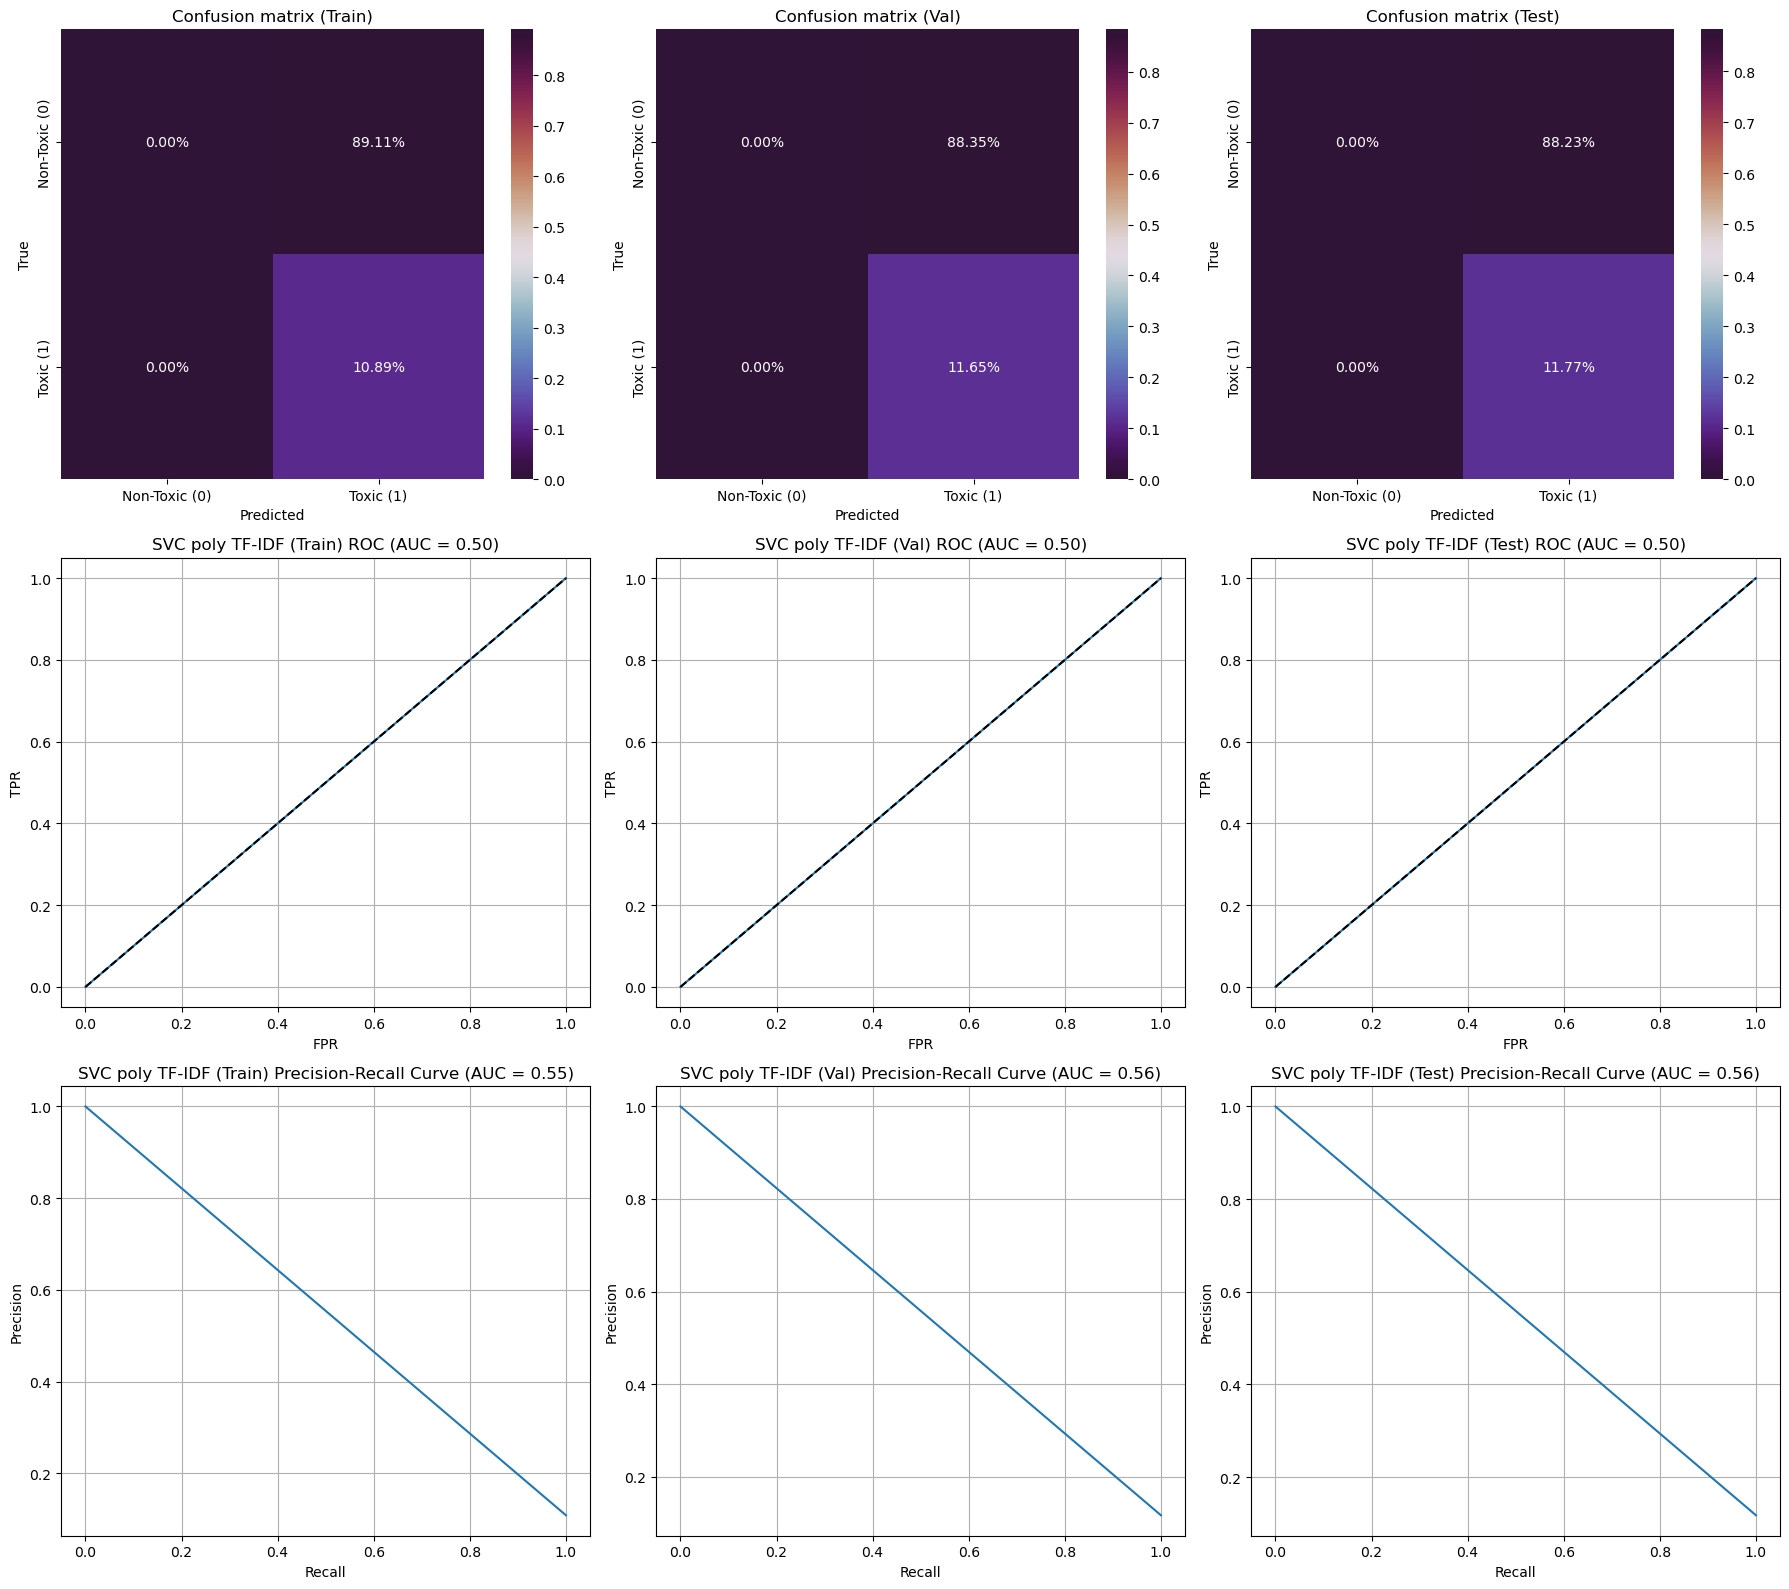

In [15]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_svc_poly_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_svc_poly_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_svc_poly_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_svc_poly_tfidf_pred_proba_train,
    y_pred_proba_val=y_svc_poly_tfidf_pred_proba_val,
    y_pred_proba_test=y_svc_poly_tfidf_pred_proba_test,
    title='SVC poly TF-IDF'
)

`kernel = 'rbf'`

#### TF-IDF

In [16]:
(
    y_svc_rbf_tfidf_pred_train,
    y_svc_rbf_tfidf_pred_val,
    y_svc_rbf_tfidf_pred_test,
    y_svc_rbf_tfidf_pred_proba_train,
    y_svc_rbf_tfidf_pred_proba_val,
    y_svc_rbf_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=TSVC(kernel='rbf', probability=True, max_iter=1000),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [17]:
t = get_threshold(y_val, y_svc_rbf_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.09


SVC rbf TF-IDF

Precision		Recall			F1

Train: 0.58		Train: 0.72		Train: 0.64
Val: 0.57		Val: 0.71		Val: 0.63
Test: 0.58		Test: 0.71		Test: 0.64


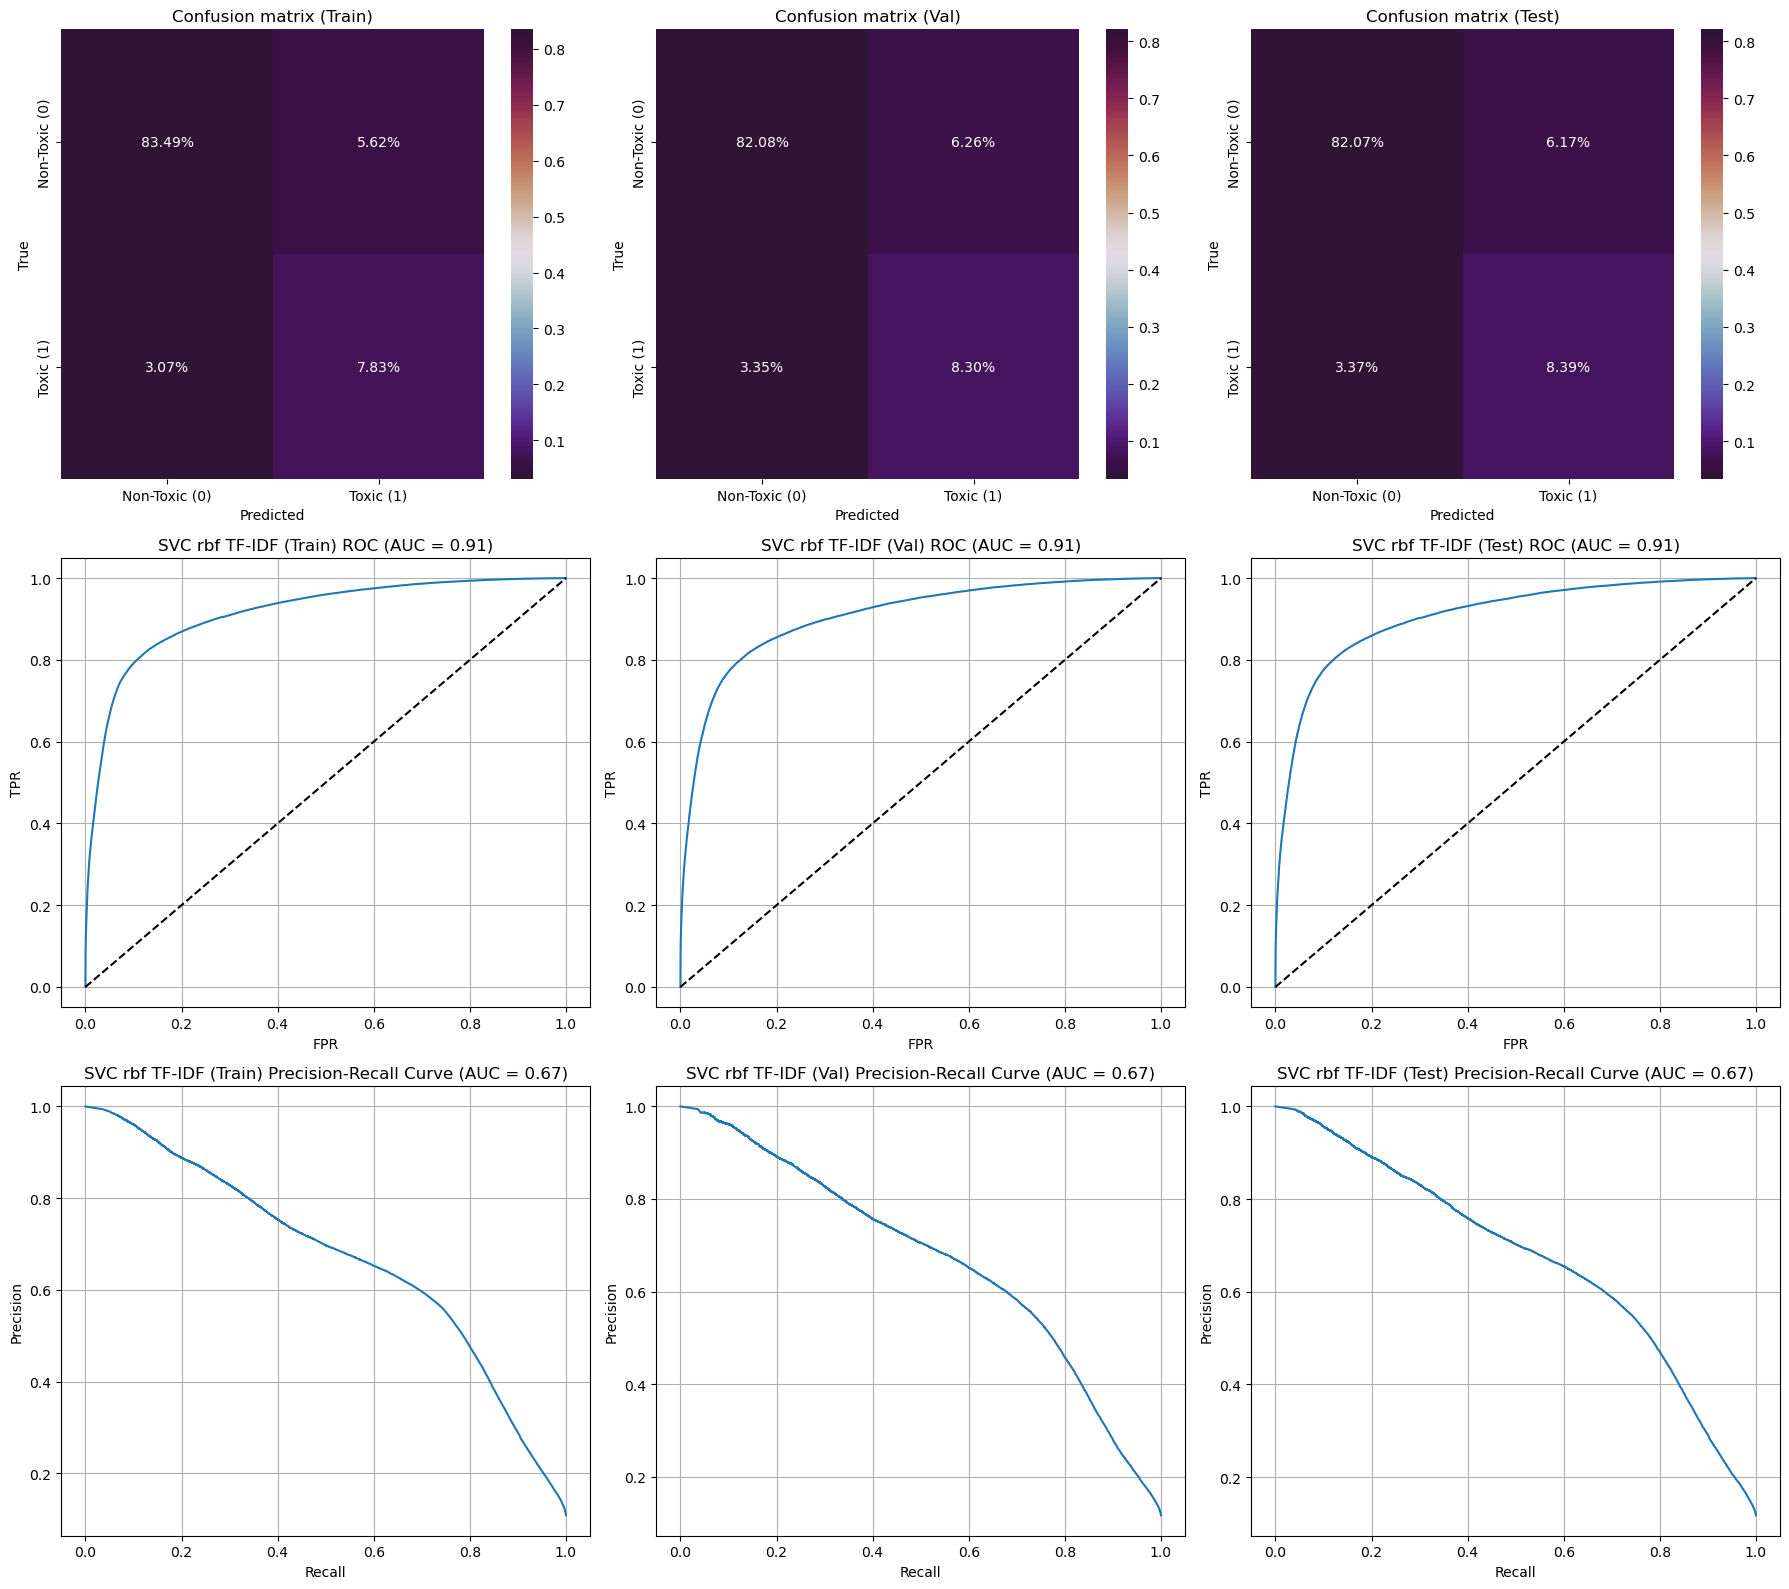

In [18]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_svc_rbf_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_svc_rbf_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_svc_rbf_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_svc_rbf_tfidf_pred_proba_train,
    y_pred_proba_val=y_svc_rbf_tfidf_pred_proba_val,
    y_pred_proba_test=y_svc_rbf_tfidf_pred_proba_test,
    title='SVC rbf TF-IDF'
)

`kernel = 'sigmoid'`

#### TF-IDF

In [19]:
(
    y_svc_sigmoid_tfidf_pred_train,
    y_svc_sigmoid_tfidf_pred_val,
    y_svc_sigmoid_tfidf_pred_test,
    y_svc_sigmoid_tfidf_pred_proba_train,
    y_svc_sigmoid_tfidf_pred_proba_val,
    y_svc_sigmoid_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=TSVC(kernel='sigmoid', probability=True, max_iter=1000),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [20]:
t = get_threshold(y_val, y_svc_sigmoid_tfidf_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.1


SVC sigmoid TF-IDF

Precision		Recall			F1

Train: 0.62		Train: 0.66		Train: 0.64
Val: 0.61		Val: 0.66		Val: 0.64
Test: 0.62		Test: 0.66		Test: 0.64


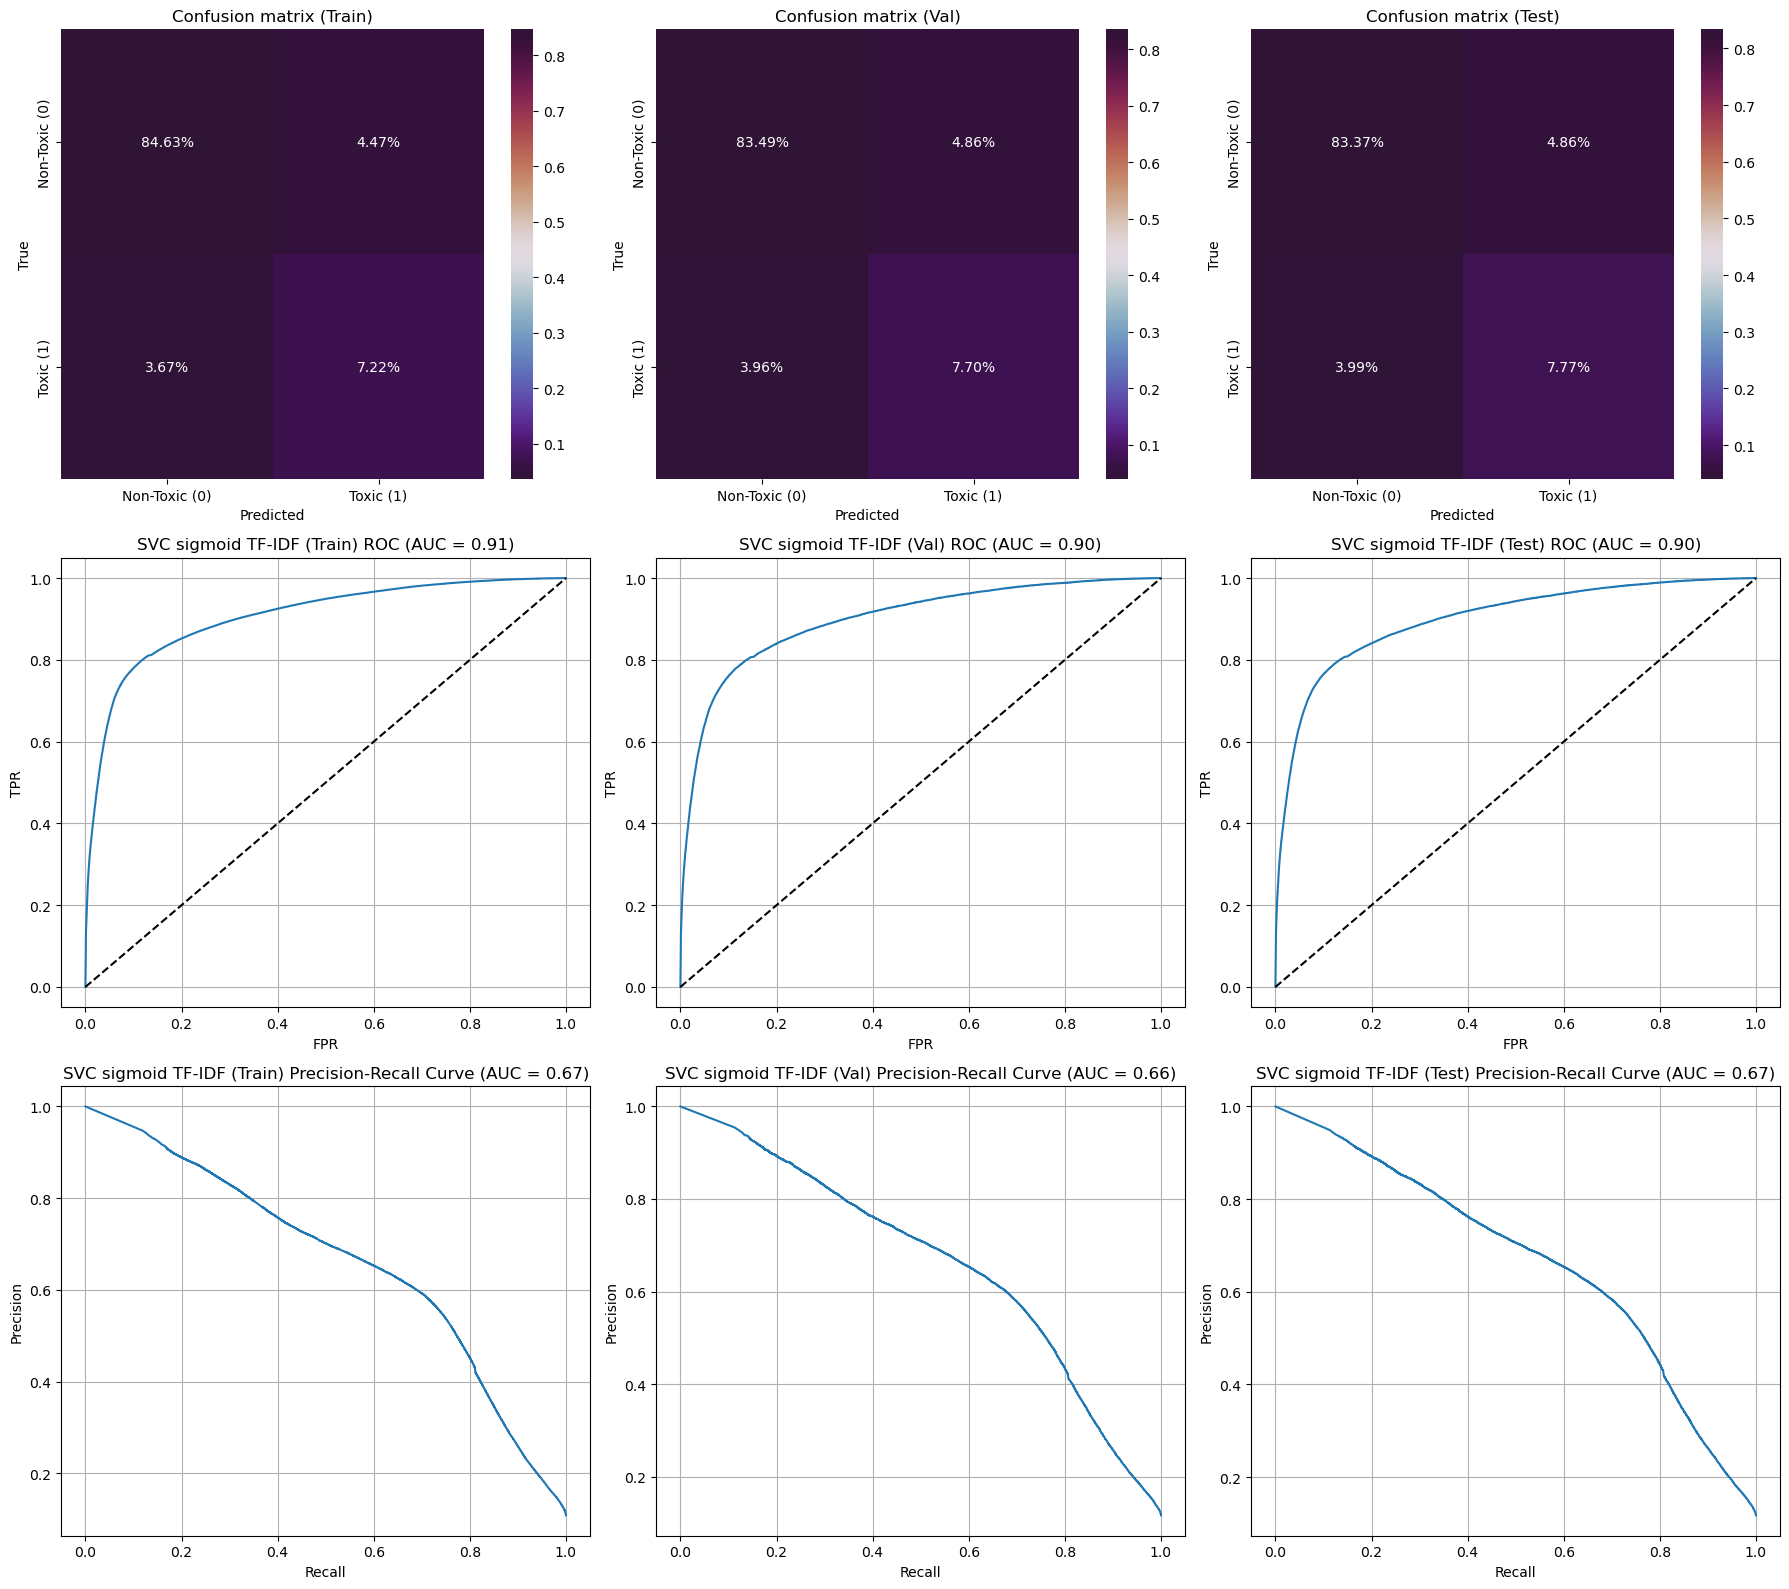

In [31]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_svc_sigmoid_tfidf_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_svc_sigmoid_tfidf_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_svc_sigmoid_tfidf_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_svc_sigmoid_tfidf_pred_proba_train,
    y_pred_proba_val=y_svc_sigmoid_tfidf_pred_proba_val,
    y_pred_proba_test=y_svc_sigmoid_tfidf_pred_proba_test,
    title='SVC sigmoid TF-IDF'
)

## LinearSVC + Hashing + TF-IDF

### Данные

In [ ]:
!wget -O hash_tfidf_data.zip "$(curl -G "https://cloud-api.yandex.net/v1/disk/public/resources/download" --data-urlencode "public_key=https://disk.yandex.ru/d/pwSGL0O5xXLv_w" | jq -r '.href')"

In [ ]:
!unzip hash_tfidf_data.zip

In [30]:
X_train_ht = scipy.sparse.load_npz("hash_tfidf_data/X_train.npz")
X_val_ht = scipy.sparse.load_npz("hash_tfidf_data/X_val.npz")
X_test_ht = scipy.sparse.load_npz("hash_tfidf_data/X_test.npz")

Данные были получены с помощью слияния текстовых данных, которые были векторизированы с помощью `HashingVectorizer()` и `TfidfVectorizer()`. Более подробно ознакомиться с параметрами векторизаторов можно в файле `train_functions.py`.

### Обучение модели

In [34]:
#best_params = get_hyperparams(X_train_c, X_val_c, y_train, y_val, svc_objective, n_trials=40)
best_params = {'C': 0.2638439947399784, 'penalty': 'l1', 'class_weight': None}

(y_linear_svc_ht_pred_train,
 y_linear_svc_ht_pred_val,
 y_linear_svc_ht_pred_test,
 y_linear_svc_ht_pred_proba_train,
 y_linear_svc_ht_pred_proba_val,
 y_linear_svc_ht_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False), n_jobs=-1),
    X_train=X_train_ht,
    X_val=X_val_ht,
    X_test=X_test_ht,
    y_train=y_train,
)

In [35]:
t = get_threshold(y_val, y_linear_svc_ht_pred_proba_val)
print(f'Оптимальный порог вероятности класса {t}')

Оптимальный порог вероятности класса 0.22


LinearSVC HASH + TF-IDF

Precision		Recall			F1

Train: 0.64		Train: 0.71		Train: 0.68
Val: 0.63		Val: 0.69		Val: 0.66
Test: 0.64		Test: 0.70		Test: 0.66


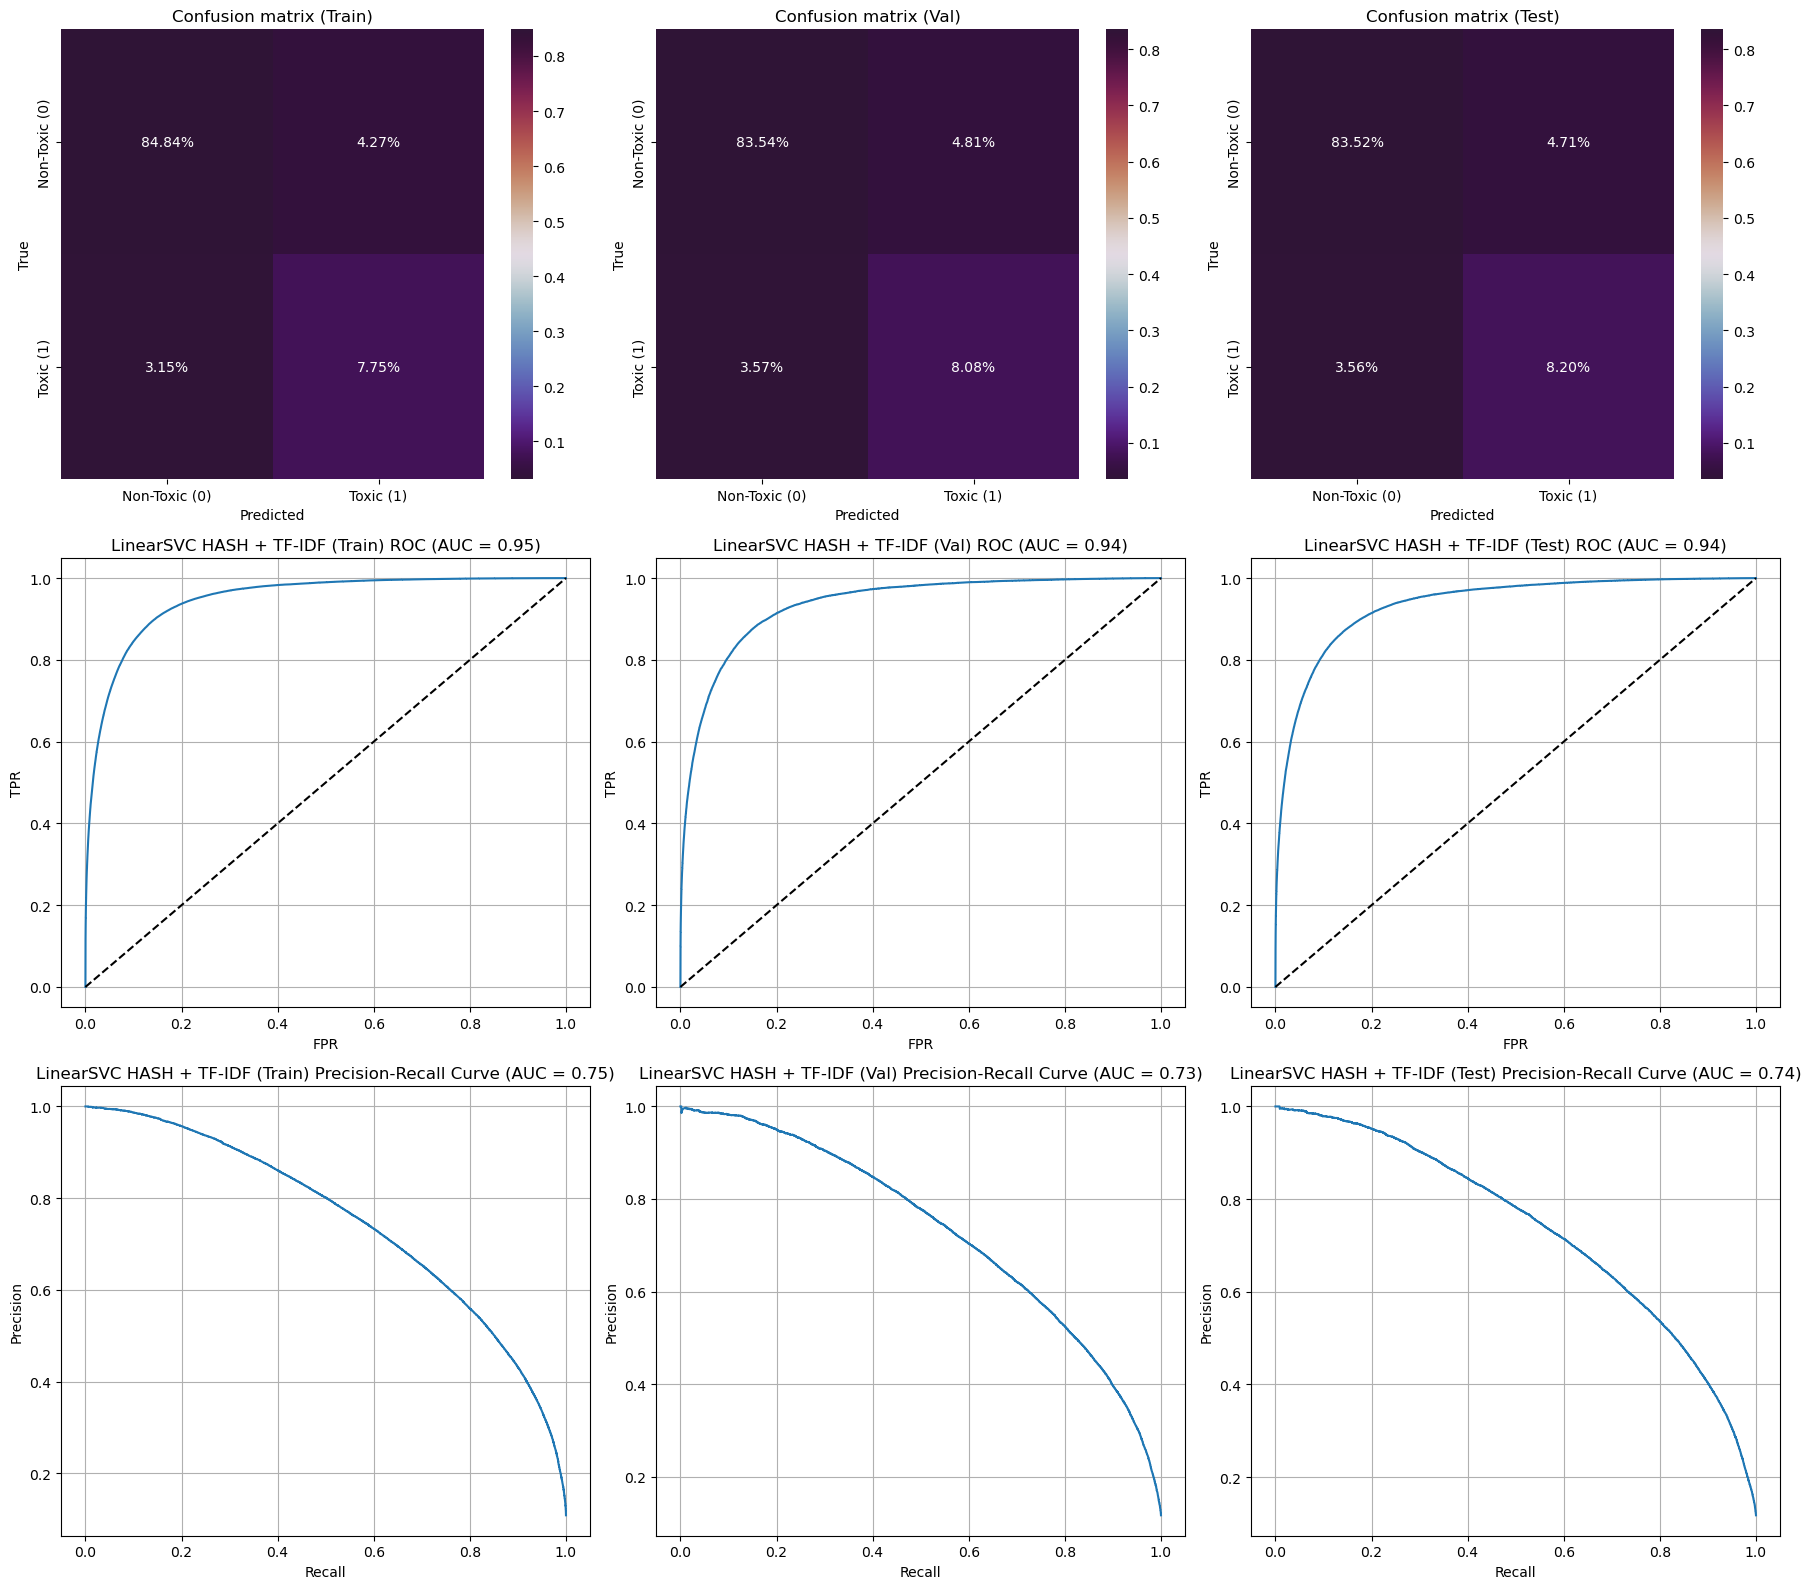

In [38]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=np.where(y_linear_svc_ht_pred_proba_train > t, 1, 0),
    y_pred_val=np.where(y_linear_svc_ht_pred_proba_val > t, 1, 0),
    y_pred_test=np.where(y_linear_svc_ht_pred_proba_test > t, 1, 0),
    y_pred_proba_train=y_linear_svc_ht_pred_proba_train,
    y_pred_proba_val=y_linear_svc_ht_pred_proba_val,
    y_pred_proba_test=y_linear_svc_ht_pred_proba_test,
    title='LinearSVC HASH + TF-IDF'
)

Данная модель, обученная именно на этих данных, демонстрирует наилучшие метрики из всех представленных моделей. Однако вероятно можно получить лучшие результаты с помощью моделей градиентного бустинга, но они к сожалению на текущий момент не могут быть применены из-за ограничений связанных с ОЗУ. Если пытаться как-то обходить эти ограничения различными способами (суженный диапазон метрик, другая обработка данных), то метрики обычно становятся хуже по сравнению с LinearSVC.